## References

In [3]:
# https://radimrehurek.com/gensim/tut2.html#Gensim    
# https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html
# https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# https://pypi.org/project/pyLDAvis/1.0.0/
# https://gist.github.com/tokestermw/3588e6fbbb2f03f89798
# https://stackoverflow.com/questions/11162402/lda-topic-modeling-training-and-testing
# https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

## Prepare Notebook

In [4]:
# import packages
import os.path
from gensim import corpora, models
import logging
import pickle
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import pyLDAvis
from wordcloud import WordCloud

C:\Users\Sebastian Birk\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
# display plots within notebook
%matplotlib inline

In [6]:
# log events
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Load Vectorized Corpora and Dictionaries

In [7]:
# load no pooling corpus
if (os.path.exists("tourism_no_pooling.dict")):
   dictionary_no_pooling = corpora.Dictionary.load('tourism_no_pooling.dict')
   corpus_no_pooling = corpora.MmCorpus('tourism_no_pooling.mm')
   print("Vectorized no pooling corpus loaded!")
else:
   print("Please run preprocessing script first!")

# load user pooling corpus
if (os.path.exists("tourism_user_pooling.dict")):
   dictionary_user_pooling = corpora.Dictionary.load('tourism_user_pooling.dict')
   corpus_user_pooling = corpora.MmCorpus('tourism_user_pooling.mm')
   print("Vectorized user pooling corpus loaded!")
else:
   print("Please run preprocessing script first!")

# load hashtag pooling corpus
if (os.path.exists("tourism_hashtag_pooling.dict")):
   dictionary_hashtag_pooling = corpora.Dictionary.load('tourism_hashtag_pooling.dict')
   corpus_hashtag_pooling = corpora.MmCorpus('tourism_hashtag_pooling.mm')
   print("Vectorized hashtag pooling corpus loaded!")
else:
   print("Please run preprocessing script first!")

2018-10-03 07:51:28,936 : INFO : loading Dictionary object from tourism_no_pooling.dict
2018-10-03 07:51:28,944 : INFO : loaded tourism_no_pooling.dict
2018-10-03 07:51:28,951 : INFO : loaded corpus index from tourism_no_pooling.mm.index
2018-10-03 07:51:28,953 : INFO : initializing cython corpus reader from tourism_no_pooling.mm
2018-10-03 07:51:28,956 : INFO : accepted corpus with 7633 documents, 4790 features, 37016 non-zero entries
2018-10-03 07:51:28,959 : INFO : loading Dictionary object from tourism_user_pooling.dict
2018-10-03 07:51:28,966 : INFO : loaded tourism_user_pooling.dict
2018-10-03 07:51:28,971 : INFO : loaded corpus index from tourism_user_pooling.mm.index
2018-10-03 07:51:28,974 : INFO : initializing cython corpus reader from tourism_user_pooling.mm
2018-10-03 07:51:28,978 : INFO : accepted corpus with 4424 documents, 3990 features, 30119 non-zero entries
2018-10-03 07:51:28,982 : INFO : loading Dictionary object from tourism_hashtag_pooling.dict
2018-10-03 07:51:28

Vectorized no pooling corpus loaded!
Vectorized user pooling corpus loaded!
Vectorized hashtag pooling corpus loaded!


## Load Tokenized Documents

In [8]:
with open ('tokenized_documents_no_pooling.p', 'rb') as fp:
    tokenized_documents_no_pooling = pickle.load(fp)
with open ('tokenized_documents_user_pooling.p', 'rb') as fp:
    tokenized_documents_user_pooling = pickle.load(fp)
with open ('tokenized_documents_hashtag_pooling.p', 'rb') as fp:
    tokenized_documents_hashtag_pooling = pickle.load(fp)

## Implement LDA Models with Different Pooling Methods

#### Two evaluation metrics for topic models come to mind: coherence values and perplexity. Coherence values will be used to evaluate different LDA models (varying the number of topics) as this metric tends to favor better human interpretable topics (which is the objective of this research). The number of topics will be limited to 8 to avoid too much granularity. However, sometimes the highest coherence values do not give the most human interpretable topics. Visualization of the topic models can additionally help to understand and interprete the topics. The c_v measure will be used as a coherence measure to evaluate the LDA models.

In [9]:
# Define function to train various LDA models with different number of topics
# and evaluate their coherence values (choose the number of topics with the highest coherence value)
def compute_coherence_values(dictionary, corpus, texts, limit=9, start=4, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    model_topics = []
    
    for num_topics in range(start, limit, step):
        model= models.LdaModel(corpus=corpus, id2word=dictionary, alpha='auto', eta='auto',
                       eval_every=1, iterations=400, passes=20, num_topics=num_topics)
        model_list.append(model)
        
        model_topics = model.show_topics(formatted=False)
    
        model_topics = [[word for word, prob in topic] for topicid, topic in model_topics]
    
        coherencemodel = CoherenceModel(topics=model_topics, texts=texts, dictionary=dictionary, window_size=10)
        coherence_values.append(coherencemodel.get_coherence())

    return (model_list, coherence_values)

### No Pooling

In [24]:
# train and evaluate different no pooling models by running the function
no_pooling_models = compute_coherence_values(dictionary=dictionary_no_pooling,
                         corpus=corpus_no_pooling, texts=tokenized_documents_no_pooling)

2018-10-03 08:04:26,008 : INFO : using autotuned alpha, starting with [0.25, 0.25, 0.25, 0.25]
2018-10-03 08:04:26,015 : INFO : using serial LDA version on this node
2018-10-03 08:04:26,022 : INFO : running online (multi-pass) LDA training, 4 topics, 20 passes over the supplied corpus of 7633 documents, updating model once every 2000 documents, evaluating perplexity every 2000 documents, iterating 400x with a convergence threshold of 0.001000
2018-10-03 08:04:27,737 : INFO : -9.621 per-word bound, 787.3 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:04:27,738 : INFO : PROGRESS: pass 0, at document #2000/7633
2018-10-03 08:04:28,771 : INFO : optimized alpha [0.18916146, 0.22151817, 0.18471554, 0.19287662]
2018-10-03 08:04:28,773 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:04:28,779 : INFO : topic #0 (0.189): 0.012*"time" + 0.009*"gothic" + 0.008*"quarter" + 0.008*"milà" + 0.007*"#sagradafamili

2018-10-03 08:04:36,238 : INFO : topic #2 (0.167): 0.024*"drinking" + 0.007*"parc" + 0.006*"#streetart" + 0.006*"way" + 0.006*"best" + 0.006*"summer" + 0.005*"#endomondo" + 0.005*"km" + 0.005*"laberint" + 0.004*"finished"
2018-10-03 08:04:36,241 : INFO : topic #3 (0.184): 0.041*"sagrada" + 0.031*"basílica" + 0.028*"família" + 0.011*"night" + 0.010*"familia" + 0.010*"beach" + 0.008*"beautiful" + 0.007*"city" + 0.006*"amazing" + 0.005*"work"
2018-10-03 08:04:36,244 : INFO : topic diff=0.363198, rho=0.414638
2018-10-03 08:04:36,898 : INFO : -8.038 per-word bound, 262.9 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:04:36,899 : INFO : PROGRESS: pass 1, at document #6000/7633
2018-10-03 08:04:37,337 : INFO : optimized alpha [0.1704476, 0.23861401, 0.16920747, 0.18328033]
2018-10-03 08:04:37,339 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:04:37,345 : INFO : topic #0 (0.170): 0.013*"milà" + 0.012*"pe

2018-10-03 08:04:42,443 : INFO : topic #2 (0.165): 0.024*"drinking" + 0.009*"festival" + 0.007*"parc" + 0.007*"#streetart" + 0.007*"#endomondo" + 0.007*"km" + 0.006*"#arteurbano" + 0.006*"best" + 0.006*"summer" + 0.006*"sant"
2018-10-03 08:04:42,445 : INFO : topic #3 (0.185): 0.035*"sagrada" + 0.030*"basílica" + 0.028*"família" + 0.013*"beach" + 0.010*"night" + 0.009*"city" + 0.008*"beautiful" + 0.006*"familia" + 0.006*"see" + 0.006*"amazing"
2018-10-03 08:04:42,446 : INFO : topic diff=0.257932, rho=0.383018
2018-10-03 08:04:43,025 : INFO : -8.054 per-word bound, 265.7 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:04:43,027 : INFO : PROGRESS: pass 3, at document #2000/7633
2018-10-03 08:04:43,472 : INFO : optimized alpha [0.16322933, 0.23558229, 0.15694633, 0.17903262]
2018-10-03 08:04:43,475 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:04:43,480 : INFO : topic #0 (0.163): 0.013*"milà" + 0.01

2018-10-03 08:04:48,306 : INFO : topic #2 (0.153): 0.026*"drinking" + 0.007*"#streetart" + 0.006*"parc" + 0.006*"way" + 0.006*"best" + 0.005*"summer" + 0.005*"#endomondo" + 0.005*"hotel" + 0.005*"festival" + 0.005*"km"
2018-10-03 08:04:48,309 : INFO : topic #3 (0.176): 0.037*"sagrada" + 0.032*"basílica" + 0.030*"família" + 0.011*"beach" + 0.010*"night" + 0.008*"city" + 0.008*"beautiful" + 0.006*"work" + 0.006*"amazing" + 0.006*"see"
2018-10-03 08:04:48,313 : INFO : topic diff=0.194061, rho=0.336784
2018-10-03 08:04:48,874 : INFO : -7.909 per-word bound, 240.4 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:04:48,876 : INFO : PROGRESS: pass 4, at document #6000/7633
2018-10-03 08:04:49,289 : INFO : optimized alpha [0.15593961, 0.23899706, 0.15471505, 0.17578427]
2018-10-03 08:04:49,291 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:04:49,296 : INFO : topic #0 (0.156): 0.014*"milà" + 0.012*"pedrerac

2018-10-03 08:04:53,533 : INFO : topic #2 (0.153): 0.024*"drinking" + 0.009*"festival" + 0.007*"#streetart" + 0.007*"parc" + 0.007*"#endomondo" + 0.007*"#arteurbano" + 0.006*"km" + 0.006*"summer" + 0.006*"sant" + 0.006*"#endorphins"
2018-10-03 08:04:53,536 : INFO : topic #3 (0.176): 0.032*"sagrada" + 0.031*"basílica" + 0.029*"família" + 0.014*"beach" + 0.009*"city" + 0.009*"night" + 0.007*"beautiful" + 0.006*"see" + 0.006*"amazing" + 0.006*"work"
2018-10-03 08:04:53,539 : INFO : topic diff=0.177674, rho=0.319170
2018-10-03 08:04:54,086 : INFO : -7.991 per-word bound, 254.5 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:04:54,087 : INFO : PROGRESS: pass 6, at document #2000/7633
2018-10-03 08:04:54,473 : INFO : optimized alpha [0.15257223, 0.2322835, 0.14739992, 0.17196544]
2018-10-03 08:04:54,475 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:04:54,480 : INFO : topic #0 (0.153): 0.013*"milà" + 0

2018-10-03 08:04:59,232 : INFO : topic #2 (0.145): 0.026*"drinking" + 0.007*"#streetart" + 0.006*"parc" + 0.006*"way" + 0.006*"#endomondo" + 0.006*"festival" + 0.005*"summer" + 0.005*"km" + 0.005*"best" + 0.005*"#arteurbano"
2018-10-03 08:04:59,234 : INFO : topic #3 (0.170): 0.033*"sagrada" + 0.031*"basílica" + 0.031*"família" + 0.012*"beach" + 0.009*"night" + 0.009*"city" + 0.008*"beautiful" + 0.006*"work" + 0.006*"see" + 0.006*"amazing"
2018-10-03 08:04:59,237 : INFO : topic diff=0.150185, rho=0.290908
2018-10-03 08:04:59,779 : INFO : -7.864 per-word bound, 233.0 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:04:59,780 : INFO : PROGRESS: pass 7, at document #6000/7633
2018-10-03 08:05:00,209 : INFO : optimized alpha [0.14802639, 0.23256485, 0.14637423, 0.17022397]
2018-10-03 08:05:00,211 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:05:00,215 : INFO : topic #0 (0.148): 0.014*"milà" + 0.012*"pe

2018-10-03 08:05:04,662 : INFO : topic #2 (0.146): 0.025*"drinking" + 0.009*"festival" + 0.008*"#streetart" + 0.007*"parc" + 0.007*"#endomondo" + 0.007*"#arteurbano" + 0.006*"km" + 0.006*"fashion" + 0.006*"summer" + 0.006*"#endorphins"
2018-10-03 08:05:04,664 : INFO : topic #3 (0.172): 0.030*"sagrada" + 0.030*"basílica" + 0.029*"família" + 0.015*"beach" + 0.010*"city" + 0.009*"night" + 0.007*"beautiful" + 0.007*"see" + 0.006*"amazing" + 0.006*"work"
2018-10-03 08:05:04,666 : INFO : topic diff=0.142507, rho=0.279329
2018-10-03 08:05:05,232 : INFO : -7.957 per-word bound, 248.6 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:05:05,234 : INFO : PROGRESS: pass 9, at document #2000/7633
2018-10-03 08:05:05,614 : INFO : optimized alpha [0.14628321, 0.22496158, 0.14133918, 0.16878049]
2018-10-03 08:05:05,616 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:05:05,622 : INFO : topic #0 (0.146): 0.014*"milà"

2018-10-03 08:05:10,729 : INFO : topic #2 (0.140): 0.026*"drinking" + 0.007*"#streetart" + 0.006*"parc" + 0.006*"way" + 0.006*"festival" + 0.006*"#endomondo" + 0.005*"summer" + 0.005*"km" + 0.005*"#arteurbano" + 0.005*"#endorphins"
2018-10-03 08:05:10,731 : INFO : topic #3 (0.168): 0.031*"sagrada" + 0.030*"família" + 0.030*"basílica" + 0.012*"beach" + 0.009*"city" + 0.009*"night" + 0.007*"beautiful" + 0.006*"see" + 0.006*"work" + 0.006*"happy"
2018-10-03 08:05:10,733 : INFO : topic diff=0.125872, rho=0.259793
2018-10-03 08:05:11,255 : INFO : -7.840 per-word bound, 229.2 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:05:11,256 : INFO : PROGRESS: pass 10, at document #6000/7633
2018-10-03 08:05:11,613 : INFO : optimized alpha [0.14275818, 0.22408512, 0.1411251, 0.16759174]
2018-10-03 08:05:11,615 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:05:11,620 : INFO : topic #0 (0.143): 0.014*"milà" + 0.01

2018-10-03 08:05:16,315 : INFO : topic #2 (0.141): 0.025*"drinking" + 0.010*"festival" + 0.008*"#streetart" + 0.007*"parc" + 0.007*"#endomondo" + 0.007*"#arteurbano" + 0.006*"km" + 0.006*"fashion" + 0.006*"summer" + 0.006*"way"
2018-10-03 08:05:16,317 : INFO : topic #3 (0.168): 0.029*"família" + 0.029*"sagrada" + 0.029*"basílica" + 0.015*"beach" + 0.010*"city" + 0.009*"night" + 0.007*"beautiful" + 0.007*"see" + 0.006*"amazing" + 0.006*"work"
2018-10-03 08:05:16,320 : INFO : topic diff=0.122782, rho=0.251446
2018-10-03 08:05:16,871 : INFO : -7.936 per-word bound, 244.8 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:05:16,872 : INFO : PROGRESS: pass 12, at document #2000/7633
2018-10-03 08:05:17,270 : INFO : optimized alpha [0.14184256, 0.21544419, 0.13706927, 0.16602826]
2018-10-03 08:05:17,272 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:05:17,277 : INFO : topic #0 (0.142): 0.014*"milà" + 0.01

2018-10-03 08:05:21,679 : INFO : topic #2 (0.136): 0.026*"drinking" + 0.007*"#streetart" + 0.006*"parc" + 0.006*"festival" + 0.006*"way" + 0.006*"#endomondo" + 0.005*"summer" + 0.005*"km" + 0.005*"#arteurbano" + 0.005*"#endorphins"
2018-10-03 08:05:21,681 : INFO : topic #3 (0.165): 0.030*"sagrada" + 0.030*"família" + 0.029*"basílica" + 0.013*"beach" + 0.010*"city" + 0.009*"night" + 0.007*"beautiful" + 0.006*"see" + 0.006*"happy" + 0.006*"work"
2018-10-03 08:05:21,684 : INFO : topic diff=0.109976, rho=0.236913
2018-10-03 08:05:22,218 : INFO : -7.825 per-word bound, 226.8 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:05:22,220 : INFO : PROGRESS: pass 13, at document #6000/7633
2018-10-03 08:05:22,565 : INFO : optimized alpha [0.13896614, 0.21593386, 0.13708401, 0.16549239]
2018-10-03 08:05:22,568 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:05:22,574 : INFO : topic #0 (0.139): 0.014*"milà" + 0.0

2018-10-03 08:05:26,728 : INFO : topic #2 (0.137): 0.025*"drinking" + 0.010*"festival" + 0.008*"#streetart" + 0.007*"parc" + 0.007*"#endomondo" + 0.007*"#arteurbano" + 0.006*"km" + 0.006*"fashion" + 0.006*"summer" + 0.006*"way"
2018-10-03 08:05:26,730 : INFO : topic #3 (0.166): 0.029*"família" + 0.029*"sagrada" + 0.028*"basílica" + 0.015*"beach" + 0.011*"city" + 0.009*"night" + 0.007*"beautiful" + 0.007*"see" + 0.006*"best" + 0.006*"amazing"
2018-10-03 08:05:26,732 : INFO : topic diff=0.108888, rho=0.230532
2018-10-03 08:05:27,288 : INFO : -7.920 per-word bound, 242.2 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:05:27,289 : INFO : PROGRESS: pass 15, at document #2000/7633
2018-10-03 08:05:27,659 : INFO : optimized alpha [0.13856319, 0.20973381, 0.13387196, 0.16452755]
2018-10-03 08:05:27,660 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:05:27,666 : INFO : topic #0 (0.139): 0.014*"milà" + 0.01

2018-10-03 08:05:32,560 : INFO : topic #2 (0.133): 0.026*"drinking" + 0.007*"#streetart" + 0.006*"festival" + 0.006*"parc" + 0.006*"way" + 0.006*"#endomondo" + 0.006*"summer" + 0.005*"km" + 0.005*"#arteurbano" + 0.005*"#endorphins"
2018-10-03 08:05:32,563 : INFO : topic #3 (0.164): 0.030*"família" + 0.030*"sagrada" + 0.029*"basílica" + 0.013*"beach" + 0.010*"city" + 0.009*"night" + 0.007*"beautiful" + 0.007*"see" + 0.006*"happy" + 0.006*"work"
2018-10-03 08:05:32,568 : INFO : topic diff=0.098641, rho=0.219178
2018-10-03 08:05:33,071 : INFO : -7.815 per-word bound, 225.3 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:05:33,072 : INFO : PROGRESS: pass 16, at document #6000/7633
2018-10-03 08:05:33,449 : INFO : optimized alpha [0.13629344, 0.21117646, 0.13433528, 0.16433285]
2018-10-03 08:05:33,450 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:05:33,456 : INFO : topic #0 (0.136): 0.014*"milà" + 0.0

2018-10-03 08:05:37,560 : INFO : topic #2 (0.135): 0.025*"drinking" + 0.010*"festival" + 0.008*"#streetart" + 0.007*"parc" + 0.007*"#endomondo" + 0.007*"#arteurbano" + 0.006*"km" + 0.006*"fashion" + 0.006*"summer" + 0.006*"way"
2018-10-03 08:05:37,563 : INFO : topic #3 (0.165): 0.029*"família" + 0.028*"sagrada" + 0.028*"basílica" + 0.015*"beach" + 0.011*"city" + 0.009*"night" + 0.007*"beautiful" + 0.007*"see" + 0.006*"best" + 0.006*"amazing"
2018-10-03 08:05:37,565 : INFO : topic diff=0.098760, rho=0.214095
2018-10-03 08:05:38,140 : INFO : -7.908 per-word bound, 240.3 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:05:38,141 : INFO : PROGRESS: pass 18, at document #2000/7633
2018-10-03 08:05:38,539 : INFO : optimized alpha [0.13625044, 0.20635284, 0.13179028, 0.16359495]
2018-10-03 08:05:38,541 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:05:38,546 : INFO : topic #0 (0.136): 0.014*"milà" + 0.01

2018-10-03 08:05:42,949 : INFO : topic #2 (0.131): 0.027*"drinking" + 0.007*"#streetart" + 0.007*"festival" + 0.007*"parc" + 0.006*"way" + 0.006*"#endomondo" + 0.006*"summer" + 0.005*"km" + 0.005*"#arteurbano" + 0.005*"#endorphins"
2018-10-03 08:05:42,952 : INFO : topic #3 (0.163): 0.030*"família" + 0.030*"sagrada" + 0.028*"basílica" + 0.013*"beach" + 0.011*"city" + 0.009*"night" + 0.007*"beautiful" + 0.007*"see" + 0.006*"happy" + 0.006*"work"
2018-10-03 08:05:42,954 : INFO : topic diff=0.090187, rho=0.204909
2018-10-03 08:05:43,476 : INFO : -7.807 per-word bound, 223.9 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:05:43,477 : INFO : PROGRESS: pass 19, at document #6000/7633
2018-10-03 08:05:43,811 : INFO : optimized alpha [0.13443629, 0.20809409, 0.13252212, 0.16350426]
2018-10-03 08:05:43,813 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:05:43,818 : INFO : topic #0 (0.134): 0.014*"milà" + 0.0

2018-10-03 08:05:49,778 : INFO : 46 batches submitted to accumulate stats from 2944 documents (4234 virtual)
2018-10-03 08:05:49,785 : INFO : 47 batches submitted to accumulate stats from 3008 documents (4327 virtual)
2018-10-03 08:05:49,790 : INFO : 48 batches submitted to accumulate stats from 3072 documents (4383 virtual)
2018-10-03 08:05:49,807 : INFO : 49 batches submitted to accumulate stats from 3136 documents (4422 virtual)
2018-10-03 08:05:49,811 : INFO : 50 batches submitted to accumulate stats from 3200 documents (4498 virtual)
2018-10-03 08:05:49,829 : INFO : 51 batches submitted to accumulate stats from 3264 documents (4579 virtual)
2018-10-03 08:05:49,839 : INFO : 52 batches submitted to accumulate stats from 3328 documents (4630 virtual)
2018-10-03 08:05:49,864 : INFO : 53 batches submitted to accumulate stats from 3392 documents (4647 virtual)
2018-10-03 08:05:49,878 : INFO : 54 batches submitted to accumulate stats from 3456 documents (4752 virtual)
2018-10-03 08:05:49

2018-10-03 08:05:55,563 : INFO : topic #3 (0.161): 0.049*"gothic" + 0.045*"quarter" + 0.013*"milà" + 0.012*"pedreracasa" + 0.008*"#endomondo" + 0.007*"km" + 0.007*"#endorphins" + 0.006*"art" + 0.006*"best" + 0.006*"time"
2018-10-03 08:05:55,566 : INFO : topic #4 (0.162): 0.018*"#sagradafamilia" + 0.014*"#gaudi" + 0.011*"festival" + 0.009*"#love" + 0.008*"sagrada" + 0.007*"parc" + 0.007*"#architecture" + 0.007*"#travel" + 0.006*"new" + 0.006*"today"
2018-10-03 08:05:55,568 : INFO : topic diff=0.883650, rho=0.500000
2018-10-03 08:05:56,171 : INFO : -8.239 per-word bound, 302.2 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:05:56,172 : INFO : PROGRESS: pass 1, at document #2000/7633
2018-10-03 08:05:56,589 : INFO : optimized alpha [0.16405688, 0.148113, 0.14275499, 0.15594207, 0.15799873]
2018-10-03 08:05:56,591 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:05:56,598 : INFO : topic #0 (0.164): 0.1

2018-10-03 08:06:00,258 : INFO : topic #3 (0.156): 0.046*"gothic" + 0.042*"quarter" + 0.014*"milà" + 0.012*"pedreracasa" + 0.007*"art" + 0.007*"time" + 0.006*"#endomondo" + 0.006*"km" + 0.006*"casa" + 0.006*"street"
2018-10-03 08:06:00,260 : INFO : topic #4 (0.156): 0.018*"#sagradafamilia" + 0.012*"#gaudi" + 0.009*"#catalonia" + 0.009*"#love" + 0.009*"#architecture" + 0.007*"#travel" + 0.006*"festival" + 0.006*"new" + 0.006*"#photography" + 0.005*"happy"
2018-10-03 08:06:00,262 : INFO : topic diff=0.318367, rho=0.383018
2018-10-03 08:06:00,823 : INFO : -7.933 per-word bound, 244.4 perplexity estimate based on a held-out corpus of 2000 documents with 9957 words
2018-10-03 08:06:00,825 : INFO : PROGRESS: pass 2, at document #4000/7633
2018-10-03 08:06:01,613 : INFO : optimized alpha [0.1692432, 0.14287142, 0.14026208, 0.15547843, 0.15551153]
2018-10-03 08:06:01,615 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:06:01,621 : INFO : topic #0 (0.169

2018-10-03 08:06:05,910 : INFO : topic #4 (0.155): 0.019*"#sagradafamilia" + 0.013*"#gaudi" + 0.010*"#love" + 0.010*"#travel" + 0.009*"#architecture" + 0.008*"#catalonia" + 0.007*"#photography" + 0.006*"today" + 0.006*"happy" + 0.006*"parc"
2018-10-03 08:06:05,912 : INFO : topic diff=0.217926, rho=0.357679
2018-10-03 08:06:06,511 : INFO : -7.969 per-word bound, 250.5 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:06:06,513 : INFO : PROGRESS: pass 3, at document #6000/7633
2018-10-03 08:06:06,873 : INFO : optimized alpha [0.17250423, 0.1416081, 0.13971847, 0.15604079, 0.15626518]
2018-10-03 08:06:06,875 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:06:06,881 : INFO : topic #0 (0.173): 0.125*"sagrada" + 0.083*"familia" + 0.040*"basílica" + 0.031*"família" + 0.021*"#sagradafamilia" + 0.010*"beautiful" + 0.009*"ramblas" + 0.008*"gaudi" + 0.006*"#gaudi" + 0.006*"inside"
2018-10-03 08:06:06,883 : INFO

2018-10-03 08:06:10,380 : INFO : topic diff=0.184307, rho=0.336784
2018-10-03 08:06:10,807 : INFO : -7.994 per-word bound, 254.9 perplexity estimate based on a held-out corpus of 1633 documents with 7943 words
2018-10-03 08:06:10,809 : INFO : PROGRESS: pass 4, at document #7633/7633
2018-10-03 08:06:11,085 : INFO : optimized alpha [0.17138606, 0.14298655, 0.14389308, 0.15833645, 0.15584236]
2018-10-03 08:06:11,086 : INFO : merging changes from 1633 documents into a model of 7633 documents
2018-10-03 08:06:11,092 : INFO : topic #0 (0.171): 0.119*"sagrada" + 0.077*"familia" + 0.040*"basílica" + 0.032*"família" + 0.021*"#sagradafamilia" + 0.010*"beautiful" + 0.009*"gaudi" + 0.008*"ramblas" + 0.007*"inside" + 0.006*"#gaudi"
2018-10-03 08:06:11,094 : INFO : topic #1 (0.143): 0.018*"beach" + 0.013*"city" + 0.010*"#streetart" + 0.008*"#arteurbano" + 0.007*"night" + 0.007*"marbella" + 0.007*"bar" + 0.006*"#digerible" + 0.006*"tapa" + 0.006*"arena"
2018-10-03 08:06:11,097 : INFO : topic #2 (0.1

2018-10-03 08:06:14,975 : INFO : -7.968 per-word bound, 250.3 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:06:14,976 : INFO : PROGRESS: pass 6, at document #2000/7633
2018-10-03 08:06:15,327 : INFO : optimized alpha [0.16763563, 0.1388019, 0.13839841, 0.15422326, 0.15320417]
2018-10-03 08:06:15,329 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:06:15,335 : INFO : topic #0 (0.168): 0.117*"sagrada" + 0.071*"familia" + 0.043*"basílica" + 0.035*"família" + 0.020*"#sagradafamilia" + 0.010*"beautiful" + 0.009*"gaudi" + 0.007*"inside" + 0.006*"#gaudi" + 0.006*"amazing"
2018-10-03 08:06:15,337 : INFO : topic #1 (0.139): 0.014*"beach" + 0.012*"city" + 0.009*"#streetart" + 0.008*"bar" + 0.008*"tapa" + 0.007*"night" + 0.006*"arena" + 0.006*"#arteurbano" + 0.006*"place" + 0.006*"marbella"
2018-10-03 08:06:15,339 : INFO : topic #2 (0.138): 0.022*"drinking" + 0.013*"barceloneta" + 0.010*"playa" + 0.010*"tim

2018-10-03 08:06:19,365 : INFO : PROGRESS: pass 7, at document #4000/7633
2018-10-03 08:06:19,699 : INFO : optimized alpha [0.16947012, 0.13815542, 0.13730574, 0.15303595, 0.15226685]
2018-10-03 08:06:19,701 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:06:19,706 : INFO : topic #0 (0.169): 0.124*"sagrada" + 0.079*"familia" + 0.041*"basílica" + 0.033*"família" + 0.022*"#sagradafamilia" + 0.010*"beautiful" + 0.010*"gaudi" + 0.007*"inside" + 0.006*"church" + 0.006*"amazing"
2018-10-03 08:06:19,708 : INFO : topic #1 (0.138): 0.015*"beach" + 0.014*"city" + 0.010*"#streetart" + 0.007*"bar" + 0.007*"marbella" + 0.007*"night" + 0.007*"tapa" + 0.006*"arena" + 0.006*"#graffiti" + 0.006*"#arteurbano"
2018-10-03 08:06:19,711 : INFO : topic #2 (0.137): 0.026*"drinking" + 0.010*"barceloneta" + 0.009*"time" + 0.008*"great" + 0.008*"hotel" + 0.008*"love" + 0.007*"playa" + 0.007*"night" + 0.006*"summer" + 0.006*"week"
2018-10-03 08:06:19,713 : INFO : topic #3

2018-10-03 08:06:23,905 : INFO : optimized alpha [0.17159094, 0.13871233, 0.13724537, 0.15286137, 0.15322632]
2018-10-03 08:06:23,906 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:06:23,911 : INFO : topic #0 (0.172): 0.125*"sagrada" + 0.082*"familia" + 0.041*"basílica" + 0.032*"família" + 0.023*"#sagradafamilia" + 0.010*"beautiful" + 0.009*"gaudi" + 0.008*"ramblas" + 0.006*"inside" + 0.006*"#gaudi"
2018-10-03 08:06:23,913 : INFO : topic #1 (0.139): 0.018*"beach" + 0.014*"city" + 0.010*"#streetart" + 0.008*"marbella" + 0.007*"#arteurbano" + 0.007*"night" + 0.007*"bar" + 0.007*"#digerible" + 0.006*"arena" + 0.006*"tapa"
2018-10-03 08:06:23,914 : INFO : topic #2 (0.137): 0.026*"drinking" + 0.009*"hotel" + 0.009*"time" + 0.009*"great" + 0.008*"love" + 0.007*"barceloneta" + 0.007*"week" + 0.007*"night" + 0.007*"right" + 0.006*"summer"
2018-10-03 08:06:23,916 : INFO : topic #3 (0.153): 0.047*"gothic" + 0.042*"quarter" + 0.016*"milà" + 0.014*"pedrer

2018-10-03 08:06:28,939 : INFO : merging changes from 1633 documents into a model of 7633 documents
2018-10-03 08:06:28,946 : INFO : topic #0 (0.171): 0.120*"sagrada" + 0.078*"familia" + 0.040*"basílica" + 0.032*"família" + 0.022*"#sagradafamilia" + 0.010*"beautiful" + 0.010*"gaudi" + 0.008*"ramblas" + 0.007*"inside" + 0.007*"#gaudi"
2018-10-03 08:06:28,948 : INFO : topic #1 (0.141): 0.020*"beach" + 0.014*"city" + 0.010*"#streetart" + 0.008*"#arteurbano" + 0.007*"night" + 0.007*"bar" + 0.007*"marbella" + 0.007*"tapa" + 0.006*"#digerible" + 0.006*"arena"
2018-10-03 08:06:28,953 : INFO : topic #2 (0.141): 0.024*"drinking" + 0.017*"barceloneta" + 0.014*"playa" + 0.010*"fashion" + 0.009*"time" + 0.009*"hotel" + 0.008*"bcnfashion" + 0.008*"great" + 0.008*"sant" + 0.007*"love"
2018-10-03 08:06:28,958 : INFO : topic #3 (0.154): 0.055*"gothic" + 0.049*"quarter" + 0.017*"milà" + 0.014*"pedreracasa" + 0.008*"#endomondo" + 0.007*"art" + 0.007*"km" + 0.007*"time" + 0.007*"casa" + 0.006*"#endorphin

2018-10-03 08:06:33,400 : INFO : topic #0 (0.168): 0.118*"sagrada" + 0.072*"familia" + 0.043*"basílica" + 0.035*"família" + 0.021*"#sagradafamilia" + 0.010*"beautiful" + 0.009*"gaudi" + 0.007*"inside" + 0.006*"amazing" + 0.006*"#gaudi"
2018-10-03 08:06:33,402 : INFO : topic #1 (0.138): 0.017*"beach" + 0.013*"city" + 0.010*"#streetart" + 0.008*"bar" + 0.008*"night" + 0.007*"tapa" + 0.007*"#arteurbano" + 0.006*"arena" + 0.006*"marbella" + 0.006*"place"
2018-10-03 08:06:33,405 : INFO : topic #2 (0.137): 0.024*"drinking" + 0.013*"barceloneta" + 0.011*"playa" + 0.010*"hotel" + 0.009*"time" + 0.009*"great" + 0.008*"love" + 0.007*"fashion" + 0.007*"sant" + 0.007*"night"
2018-10-03 08:06:33,407 : INFO : topic #3 (0.151): 0.050*"gothic" + 0.045*"quarter" + 0.016*"milà" + 0.013*"pedreracasa" + 0.007*"time" + 0.007*"art" + 0.007*"#endomondo" + 0.007*"casa" + 0.006*"km" + 0.006*"street"
2018-10-03 08:06:33,410 : INFO : topic #4 (0.151): 0.016*"#sagradafamilia" + 0.012*"#gaudi" + 0.011*"#love" + 0.

2018-10-03 08:06:38,117 : INFO : topic #1 (0.138): 0.018*"beach" + 0.015*"city" + 0.010*"#streetart" + 0.008*"bar" + 0.007*"night" + 0.007*"marbella" + 0.007*"tapa" + 0.006*"arena" + 0.006*"#graffiti" + 0.006*"#arteurbano"
2018-10-03 08:06:38,120 : INFO : topic #2 (0.136): 0.026*"drinking" + 0.010*"barceloneta" + 0.009*"time" + 0.009*"hotel" + 0.009*"great" + 0.008*"playa" + 0.008*"love" + 0.007*"night" + 0.006*"summer" + 0.006*"week"
2018-10-03 08:06:38,123 : INFO : topic #3 (0.150): 0.048*"gothic" + 0.043*"quarter" + 0.016*"milà" + 0.014*"pedreracasa" + 0.008*"art" + 0.007*"time" + 0.006*"#endomondo" + 0.006*"casa" + 0.006*"km" + 0.006*"street"
2018-10-03 08:06:38,125 : INFO : topic #4 (0.151): 0.018*"#sagradafamilia" + 0.013*"#gaudi" + 0.012*"#love" + 0.011*"#travel" + 0.010*"#architecture" + 0.009*"#catalonia" + 0.007*"#photography" + 0.007*"#summer" + 0.006*"festival" + 0.006*"parc"
2018-10-03 08:06:38,128 : INFO : topic diff=0.103495, rho=0.243855
2018-10-03 08:06:38,707 : INFO :

2018-10-03 08:06:42,344 : INFO : topic #2 (0.137): 0.026*"drinking" + 0.010*"hotel" + 0.009*"time" + 0.009*"great" + 0.008*"barceloneta" + 0.008*"love" + 0.007*"week" + 0.007*"playa" + 0.007*"night" + 0.006*"right"
2018-10-03 08:06:42,347 : INFO : topic #3 (0.150): 0.048*"gothic" + 0.043*"quarter" + 0.016*"milà" + 0.014*"pedreracasa" + 0.007*"art" + 0.007*"time" + 0.006*"casa" + 0.006*"#endomondo" + 0.006*"street" + 0.006*"km"
2018-10-03 08:06:42,349 : INFO : topic #4 (0.152): 0.018*"#sagradafamilia" + 0.014*"#gaudi" + 0.013*"#love" + 0.012*"festival" + 0.011*"#travel" + 0.010*"#architecture" + 0.008*"#summer" + 0.007*"#catalonia" + 0.007*"#photography" + 0.005*"parc"
2018-10-03 08:06:42,351 : INFO : topic diff=0.092300, rho=0.236913
2018-10-03 08:06:42,735 : INFO : -7.912 per-word bound, 240.8 perplexity estimate based on a held-out corpus of 1633 documents with 7943 words
2018-10-03 08:06:42,737 : INFO : PROGRESS: pass 13, at document #7633/7633
2018-10-03 08:06:42,988 : INFO : optim

2018-10-03 08:06:46,197 : INFO : topic #3 (0.152): 0.054*"gothic" + 0.049*"quarter" + 0.017*"milà" + 0.015*"pedreracasa" + 0.008*"#endomondo" + 0.007*"art" + 0.007*"time" + 0.007*"km" + 0.007*"casa" + 0.006*"#endorphins"
2018-10-03 08:06:46,199 : INFO : topic #4 (0.151): 0.017*"#sagradafamilia" + 0.013*"#gaudi" + 0.013*"#love" + 0.011*"#travel" + 0.010*"festival" + 0.010*"#architecture" + 0.009*"#summer" + 0.007*"#photography" + 0.006*"parc" + 0.006*"#catalonia"
2018-10-03 08:06:46,201 : INFO : topic diff=0.098812, rho=0.230532
2018-10-03 08:06:46,698 : INFO : -7.896 per-word bound, 238.1 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:06:46,699 : INFO : PROGRESS: pass 15, at document #2000/7633
2018-10-03 08:06:47,029 : INFO : optimized alpha [0.16826019, 0.13736951, 0.13664319, 0.14992212, 0.15020822]
2018-10-03 08:06:47,031 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:06:47,037 : INFO : topi

2018-10-03 08:06:50,595 : INFO : topic #4 (0.150): 0.017*"#sagradafamilia" + 0.013*"#gaudi" + 0.012*"#love" + 0.010*"#travel" + 0.010*"#architecture" + 0.009*"#catalonia" + 0.008*"festival" + 0.007*"#summer" + 0.007*"#photography" + 0.006*"#catalunya"
2018-10-03 08:06:50,597 : INFO : topic diff=0.102508, rho=0.219178
2018-10-03 08:06:51,075 : INFO : -7.783 per-word bound, 220.2 perplexity estimate based on a held-out corpus of 2000 documents with 9957 words
2018-10-03 08:06:51,076 : INFO : PROGRESS: pass 16, at document #4000/7633
2018-10-03 08:06:51,398 : INFO : optimized alpha [0.16966155, 0.13729207, 0.13630322, 0.14937913, 0.1500618]
2018-10-03 08:06:51,400 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:06:51,405 : INFO : topic #0 (0.170): 0.124*"sagrada" + 0.079*"familia" + 0.042*"basílica" + 0.033*"família" + 0.023*"#sagradafamilia" + 0.010*"beautiful" + 0.010*"gaudi" + 0.007*"inside" + 0.006*"amazing" + 0.006*"church"
2018-10-03 08:06:5

2018-10-03 08:06:54,547 : INFO : topic diff=0.082228, rho=0.214095
2018-10-03 08:06:55,036 : INFO : -7.858 per-word bound, 232.0 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:06:55,037 : INFO : PROGRESS: pass 17, at document #6000/7633
2018-10-03 08:06:55,360 : INFO : optimized alpha [0.17136647, 0.1379348, 0.13667381, 0.14967261, 0.15119021]
2018-10-03 08:06:55,362 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:06:55,368 : INFO : topic #0 (0.171): 0.125*"sagrada" + 0.081*"familia" + 0.041*"basílica" + 0.032*"família" + 0.023*"#sagradafamilia" + 0.010*"beautiful" + 0.010*"gaudi" + 0.008*"ramblas" + 0.007*"inside" + 0.006*"amazing"
2018-10-03 08:06:55,370 : INFO : topic #1 (0.138): 0.021*"beach" + 0.015*"city" + 0.010*"#streetart" + 0.008*"marbella" + 0.007*"night" + 0.007*"#arteurbano" + 0.007*"bar" + 0.006*"#digerible" + 0.006*"tapa" + 0.006*"arena"
2018-10-03 08:06:55,373 : INFO : topic #2 (0.

2018-10-03 08:06:58,857 : INFO : -7.894 per-word bound, 237.9 perplexity estimate based on a held-out corpus of 1633 documents with 7943 words
2018-10-03 08:06:58,858 : INFO : PROGRESS: pass 18, at document #7633/7633
2018-10-03 08:06:59,110 : INFO : optimized alpha [0.17054251, 0.13960505, 0.13980848, 0.15113634, 0.15137507]
2018-10-03 08:06:59,112 : INFO : merging changes from 1633 documents into a model of 7633 documents
2018-10-03 08:06:59,117 : INFO : topic #0 (0.171): 0.122*"sagrada" + 0.078*"familia" + 0.041*"basílica" + 0.033*"família" + 0.023*"#sagradafamilia" + 0.010*"gaudi" + 0.010*"beautiful" + 0.008*"ramblas" + 0.007*"inside" + 0.007*"amazing"
2018-10-03 08:06:59,120 : INFO : topic #1 (0.140): 0.022*"beach" + 0.014*"city" + 0.010*"#streetart" + 0.008*"#arteurbano" + 0.008*"night" + 0.007*"bar" + 0.007*"marbella" + 0.007*"tapa" + 0.006*"#digerible" + 0.006*"arena"
2018-10-03 08:06:59,122 : INFO : topic #2 (0.140): 0.024*"drinking" + 0.015*"barceloneta" + 0.014*"playa" + 0.0

2018-10-03 08:07:06,957 : INFO : 1 batches submitted to accumulate stats from 64 documents (137 virtual)
2018-10-03 08:07:06,959 : INFO : 2 batches submitted to accumulate stats from 128 documents (242 virtual)
2018-10-03 08:07:06,963 : INFO : 3 batches submitted to accumulate stats from 192 documents (320 virtual)
2018-10-03 08:07:06,967 : INFO : 4 batches submitted to accumulate stats from 256 documents (445 virtual)
2018-10-03 08:07:06,970 : INFO : 5 batches submitted to accumulate stats from 320 documents (601 virtual)
2018-10-03 08:07:06,975 : INFO : 6 batches submitted to accumulate stats from 384 documents (741 virtual)
2018-10-03 08:07:06,980 : INFO : 7 batches submitted to accumulate stats from 448 documents (846 virtual)
2018-10-03 08:07:06,983 : INFO : 8 batches submitted to accumulate stats from 512 documents (943 virtual)
2018-10-03 08:07:06,990 : INFO : 9 batches submitted to accumulate stats from 576 documents (1098 virtual)
2018-10-03 08:07:06,996 : INFO : 10 batches su

2018-10-03 08:07:09,342 : INFO : topic #4 (0.130): 0.014*"night" + 0.013*"new" + 0.011*"quarter" + 0.011*"gothic" + 0.010*"drinking" + 0.008*"milà" + 0.007*"sagrada" + 0.007*"família" + 0.007*"place" + 0.005*"pedreracasa"
2018-10-03 08:07:09,344 : INFO : topic #5 (0.138): 0.045*"sagrada" + 0.030*"familia" + 0.014*"basílica" + 0.014*"time" + 0.013*"família" + 0.008*"love" + 0.006*"#architecture" + 0.005*"work" + 0.005*"drinking" + 0.005*"coffee"
2018-10-03 08:07:09,346 : INFO : topic #0 (0.139): 0.039*"sagrada" + 0.021*"familia" + 0.016*"basílica" + 0.014*"gothic" + 0.013*"família" + 0.013*"quarter" + 0.012*"#sagradafamilia" + 0.008*"#catalonia" + 0.008*"best" + 0.007*"#catalunya"
2018-10-03 08:07:09,348 : INFO : topic #2 (0.146): 0.024*"sagrada" + 0.017*"basílica" + 0.015*"família" + 0.014*"#sagradafamilia" + 0.009*"beautiful" + 0.009*"gothic" + 0.008*"#gaudi" + 0.007*"quarter" + 0.007*"#catalonia" + 0.007*"good"
2018-10-03 08:07:09,351 : INFO : topic diff=5.214785, rho=1.000000
2018-1

2018-10-03 08:07:14,761 : INFO : topic #3 (0.122): 0.012*"time" + 0.011*"#love" + 0.011*"good" + 0.009*"bar" + 0.008*"city" + 0.008*"night" + 0.008*"look" + 0.007*"got" + 0.007*"beach" + 0.006*"tapa"
2018-10-03 08:07:14,764 : INFO : topic #5 (0.144): 0.111*"sagrada" + 0.076*"familia" + 0.030*"basílica" + 0.028*"família" + 0.010*"time" + 0.007*"finished" + 0.006*"love" + 0.006*"#sagradafamilia" + 0.005*"gaudi" + 0.005*"#endomondo"
2018-10-03 08:07:14,766 : INFO : topic #0 (0.144): 0.039*"gothic" + 0.038*"sagrada" + 0.037*"quarter" + 0.024*"#sagradafamilia" + 0.021*"familia" + 0.016*"basílica" + 0.010*"família" + 0.010*"city" + 0.010*"#gaudi" + 0.008*"amazing"
2018-10-03 08:07:14,768 : INFO : topic #2 (0.148): 0.014*"#sagradafamilia" + 0.009*"#gaudi" + 0.009*"today" + 0.008*"barceloneta" + 0.008*"#travel" + 0.008*"#lasagradafamilia" + 0.007*"happy" + 0.007*"street" + 0.007*"summer" + 0.006*"beautiful"
2018-10-03 08:07:14,770 : INFO : topic diff=0.359527, rho=0.414638
2018-10-03 08:07:15,

2018-10-03 08:07:19,275 : INFO : topic #1 (0.122): 0.021*"festival" + 0.019*"#summer" + 0.013*"beach" + 0.011*"#photography" + 0.010*"#beach" + 0.009*"cruïlla" + 0.008*"#friends" + 0.008*"#photooftheday" + 0.008*"#sagradafamilia" + 0.006*"playa"
2018-10-03 08:07:19,277 : INFO : topic #0 (0.146): 0.048*"gothic" + 0.043*"quarter" + 0.025*"#sagradafamilia" + 0.017*"sagrada" + 0.015*"#gaudi" + 0.010*"#architecture" + 0.010*"#travel" + 0.008*"amazing" + 0.008*"basílica" + 0.008*"familia"
2018-10-03 08:07:19,280 : INFO : topic #2 (0.152): 0.011*"#sagradafamilia" + 0.009*"street" + 0.007*"today" + 0.007*"#travel" + 0.007*"#lasagradafamilia" + 0.007*"know" + 0.007*"#gaudi" + 0.007*"light" + 0.007*"happy" + 0.006*"love"
2018-10-03 08:07:19,282 : INFO : topic #5 (0.155): 0.131*"sagrada" + 0.090*"familia" + 0.039*"basílica" + 0.033*"família" + 0.012*"#sagradafamilia" + 0.008*"time" + 0.008*"beautiful" + 0.007*"finished" + 0.006*"gaudi" + 0.005*"basilica"
2018-10-03 08:07:19,284 : INFO : topic dif

2018-10-03 08:07:23,585 : INFO : topic #1 (0.126): 0.022*"#summer" + 0.021*"playa" + 0.014*"festival" + 0.012*"beach" + 0.012*"#beach" + 0.012*"#photography" + 0.009*"#friends" + 0.007*"edgebrewing" + 0.007*"#photooftheday" + 0.007*"#sun"
2018-10-03 08:07:23,587 : INFO : topic #0 (0.149): 0.064*"gothic" + 0.057*"quarter" + 0.022*"#sagradafamilia" + 0.014*"#gaudi" + 0.010*"#architecture" + 0.010*"#travel" + 0.008*"#art" + 0.007*"amazing" + 0.007*"city" + 0.006*"beautiful"
2018-10-03 08:07:23,589 : INFO : topic #2 (0.159): 0.019*"barceloneta" + 0.011*"platja" + 0.010*"bcnfashion" + 0.008*"street" + 0.008*"#sagradafamilia" + 0.007*"today" + 0.007*"light" + 0.007*"summer" + 0.007*"show" + 0.007*"love"
2018-10-03 08:07:23,591 : INFO : topic #5 (0.166): 0.128*"sagrada" + 0.084*"familia" + 0.041*"basílica" + 0.035*"família" + 0.014*"#sagradafamilia" + 0.010*"fashion" + 0.008*"beautiful" + 0.007*"#endomondo" + 0.007*"time" + 0.007*"km"
2018-10-03 08:07:23,593 : INFO : topic diff=0.218741, rho=

2018-10-03 08:07:27,766 : INFO : topic #1 (0.124): 0.017*"#summer" + 0.015*"playa" + 0.013*"#photography" + 0.010*"festival" + 0.010*"#friends" + 0.009*"#beach" + 0.008*"beach" + 0.007*"#love" + 0.007*"#photooftheday" + 0.006*"#sagradafamilia"
2018-10-03 08:07:27,767 : INFO : topic #0 (0.149): 0.057*"gothic" + 0.051*"quarter" + 0.020*"#sagradafamilia" + 0.013*"#gaudi" + 0.011*"#architecture" + 0.010*"#travel" + 0.008*"#art" + 0.008*"#catalonia" + 0.006*"#catalunya" + 0.006*"#graffiti"
2018-10-03 08:07:27,770 : INFO : topic #2 (0.159): 0.013*"barceloneta" + 0.009*"street" + 0.008*"platja" + 0.008*"#sagradafamilia" + 0.007*"#lasagradafamilia" + 0.007*"today" + 0.007*"light" + 0.007*"show" + 0.007*"new" + 0.007*"bcnfashion"
2018-10-03 08:07:27,773 : INFO : topic #5 (0.170): 0.127*"sagrada" + 0.077*"familia" + 0.047*"basílica" + 0.039*"família" + 0.014*"#sagradafamilia" + 0.009*"beautiful" + 0.008*"time" + 0.007*"fashion" + 0.006*"finished" + 0.006*"#endomondo"
2018-10-03 08:07:27,775 : IN

2018-10-03 08:07:31,798 : INFO : topic #1 (0.126): 0.018*"#summer" + 0.015*"#photography" + 0.010*"#friends" + 0.010*"playa" + 0.009*"#beach" + 0.008*"#love" + 0.008*"festival" + 0.007*"#photooftheday" + 0.007*"beach" + 0.007*"#sagradafamilia"
2018-10-03 08:07:31,801 : INFO : topic #0 (0.151): 0.054*"gothic" + 0.048*"quarter" + 0.021*"#sagradafamilia" + 0.014*"#gaudi" + 0.011*"#architecture" + 0.011*"#travel" + 0.009*"#art" + 0.008*"#graffiti" + 0.008*"#catalonia" + 0.006*"#streetart"
2018-10-03 08:07:31,804 : INFO : topic #2 (0.161): 0.010*"barceloneta" + 0.009*"#lasagradafamilia" + 0.008*"#sagradafamilia" + 0.008*"today" + 0.008*"street" + 0.008*"light" + 0.007*"new" + 0.007*"platja" + 0.007*"love" + 0.007*"summer"
2018-10-03 08:07:31,806 : INFO : topic #5 (0.176): 0.139*"sagrada" + 0.089*"familia" + 0.046*"basílica" + 0.037*"família" + 0.017*"#sagradafamilia" + 0.010*"beautiful" + 0.008*"time" + 0.006*"church" + 0.006*"finished" + 0.006*"amazing"
2018-10-03 08:07:31,808 : INFO : top

2018-10-03 08:07:35,810 : INFO : topic #1 (0.129): 0.019*"#summer" + 0.018*"festival" + 0.014*"#photography" + 0.013*"#friends" + 0.011*"#love" + 0.010*"#beach" + 0.010*"beach" + 0.008*"#photooftheday" + 0.008*"playa" + 0.008*"cruïlla"
2018-10-03 08:07:35,813 : INFO : topic #0 (0.152): 0.055*"gothic" + 0.048*"quarter" + 0.021*"#sagradafamilia" + 0.015*"#gaudi" + 0.013*"#architecture" + 0.012*"#travel" + 0.008*"#art" + 0.007*"#graffiti" + 0.006*"#catalonia" + 0.006*"city"
2018-10-03 08:07:35,815 : INFO : topic #2 (0.164): 0.009*"street" + 0.009*"#lasagradafamilia" + 0.008*"light" + 0.008*"#sagradafamilia" + 0.007*"know" + 0.007*"today" + 0.007*"barceloneta" + 0.007*"love" + 0.007*"new" + 0.007*"friend"
2018-10-03 08:07:35,817 : INFO : topic #5 (0.180): 0.142*"sagrada" + 0.093*"familia" + 0.046*"basílica" + 0.036*"família" + 0.019*"#sagradafamilia" + 0.011*"beautiful" + 0.007*"time" + 0.007*"finished" + 0.006*"amazing" + 0.006*"church"
2018-10-03 08:07:35,819 : INFO : topic diff=0.146037

2018-10-03 08:07:40,064 : INFO : topic #1 (0.133): 0.022*"#summer" + 0.019*"playa" + 0.014*"festival" + 0.013*"#photography" + 0.013*"#friends" + 0.011*"#beach" + 0.011*"#love" + 0.009*"beach" + 0.007*"#sun" + 0.007*"#photooftheday"
2018-10-03 08:07:40,066 : INFO : topic #0 (0.154): 0.066*"gothic" + 0.058*"quarter" + 0.019*"#sagradafamilia" + 0.014*"#gaudi" + 0.012*"#architecture" + 0.012*"#travel" + 0.009*"#art" + 0.006*"#streetart" + 0.006*"#graffiti" + 0.006*"#gothicquarter"
2018-10-03 08:07:40,070 : INFO : topic #2 (0.170): 0.018*"barceloneta" + 0.010*"platja" + 0.009*"bcnfashion" + 0.009*"street" + 0.008*"light" + 0.007*"today" + 0.007*"summer" + 0.007*"#lasagradafamilia" + 0.007*"show" + 0.007*"new"
2018-10-03 08:07:40,072 : INFO : topic #5 (0.183): 0.134*"sagrada" + 0.086*"familia" + 0.045*"basílica" + 0.036*"família" + 0.019*"#sagradafamilia" + 0.010*"beautiful" + 0.009*"fashion" + 0.007*"#endomondo" + 0.007*"amazing" + 0.007*"time"
2018-10-03 08:07:40,074 : INFO : topic diff=0

2018-10-03 08:07:44,081 : INFO : topic #1 (0.131): 0.018*"#summer" + 0.015*"playa" + 0.014*"#photography" + 0.013*"#friends" + 0.011*"festival" + 0.011*"#love" + 0.009*"#beach" + 0.007*"beach" + 0.007*"#photooftheday" + 0.007*"#sun"
2018-10-03 08:07:44,084 : INFO : topic #0 (0.154): 0.059*"gothic" + 0.053*"quarter" + 0.017*"#sagradafamilia" + 0.013*"#gaudi" + 0.012*"#architecture" + 0.011*"#travel" + 0.009*"#art" + 0.009*"#catalonia" + 0.006*"#graffiti" + 0.006*"#catalunya"
2018-10-03 08:07:44,087 : INFO : topic #2 (0.170): 0.013*"barceloneta" + 0.009*"street" + 0.008*"platja" + 0.008*"#lasagradafamilia" + 0.007*"new" + 0.007*"light" + 0.007*"today" + 0.007*"friend" + 0.007*"show" + 0.007*"#sagradafamilia"
2018-10-03 08:07:44,090 : INFO : topic #5 (0.183): 0.131*"sagrada" + 0.080*"familia" + 0.048*"basílica" + 0.039*"família" + 0.018*"#sagradafamilia" + 0.010*"beautiful" + 0.008*"time" + 0.007*"amazing" + 0.007*"finished" + 0.006*"fashion"
2018-10-03 08:07:44,092 : INFO : topic diff=0.

2018-10-03 08:07:48,075 : INFO : topic #1 (0.133): 0.018*"#summer" + 0.016*"#photography" + 0.013*"#friends" + 0.011*"#love" + 0.011*"playa" + 0.009*"#beach" + 0.009*"festival" + 0.007*"#sagradafamilia" + 0.007*"#travel" + 0.007*"#photooftheday"
2018-10-03 08:07:48,077 : INFO : topic #0 (0.155): 0.056*"gothic" + 0.050*"quarter" + 0.018*"#sagradafamilia" + 0.015*"#gaudi" + 0.012*"#architecture" + 0.012*"#travel" + 0.009*"#art" + 0.008*"#graffiti" + 0.008*"#catalonia" + 0.006*"#streetart"
2018-10-03 08:07:48,080 : INFO : topic #2 (0.171): 0.010*"barceloneta" + 0.009*"#lasagradafamilia" + 0.008*"street" + 0.008*"light" + 0.008*"today" + 0.007*"new" + 0.007*"platja" + 0.007*"#sagradafamilia" + 0.007*"love" + 0.007*"friend"
2018-10-03 08:07:48,082 : INFO : topic #5 (0.187): 0.140*"sagrada" + 0.089*"familia" + 0.047*"basílica" + 0.037*"família" + 0.021*"#sagradafamilia" + 0.010*"beautiful" + 0.007*"time" + 0.007*"amazing" + 0.007*"church" + 0.007*"gaudi"
2018-10-03 08:07:48,084 : INFO : topi

2018-10-03 08:07:52,068 : INFO : topic #1 (0.135): 0.019*"#summer" + 0.017*"festival" + 0.015*"#friends" + 0.014*"#photography" + 0.013*"#love" + 0.010*"#beach" + 0.009*"beach" + 0.009*"playa" + 0.008*"#photooftheday" + 0.007*"#sagradafamilia"
2018-10-03 08:07:52,070 : INFO : topic #0 (0.155): 0.057*"gothic" + 0.050*"quarter" + 0.018*"#sagradafamilia" + 0.016*"#gaudi" + 0.013*"#architecture" + 0.012*"#travel" + 0.009*"#art" + 0.007*"#catalonia" + 0.007*"#graffiti" + 0.006*"city"
2018-10-03 08:07:52,072 : INFO : topic #2 (0.172): 0.009*"#lasagradafamilia" + 0.009*"street" + 0.008*"barceloneta" + 0.008*"light" + 0.007*"know" + 0.007*"today" + 0.007*"friend" + 0.007*"new" + 0.007*"#sagradafamilia" + 0.007*"platja"
2018-10-03 08:07:52,075 : INFO : topic #5 (0.189): 0.142*"sagrada" + 0.093*"familia" + 0.046*"basílica" + 0.037*"família" + 0.022*"#sagradafamilia" + 0.011*"beautiful" + 0.007*"amazing" + 0.007*"time" + 0.007*"church" + 0.007*"finished"
2018-10-03 08:07:52,077 : INFO : topic dif

2018-10-03 08:07:56,093 : INFO : topic #4 (0.137): 0.037*"drinking" + 0.022*"milà" + 0.019*"pedreracasa" + 0.016*"ramblas" + 0.015*"parc" + 0.013*"new" + 0.011*"#streetart" + 0.010*"#arteurbano" + 0.008*"night" + 0.008*"cervecita"
2018-10-03 08:07:56,095 : INFO : topic #0 (0.157): 0.066*"gothic" + 0.058*"quarter" + 0.017*"#sagradafamilia" + 0.015*"#gaudi" + 0.012*"#architecture" + 0.012*"#travel" + 0.009*"#art" + 0.006*"#graffiti" + 0.006*"#catalonia" + 0.006*"#streetart"
2018-10-03 08:07:56,098 : INFO : topic #2 (0.177): 0.017*"barceloneta" + 0.010*"platja" + 0.009*"street" + 0.008*"bcnfashion" + 0.008*"light" + 0.007*"today" + 0.007*"#lasagradafamilia" + 0.007*"summer" + 0.007*"friend" + 0.007*"new"
2018-10-03 08:07:56,100 : INFO : topic #5 (0.191): 0.135*"sagrada" + 0.087*"familia" + 0.045*"basílica" + 0.036*"família" + 0.021*"#sagradafamilia" + 0.010*"beautiful" + 0.008*"fashion" + 0.007*"amazing" + 0.007*"#endomondo" + 0.007*"gaudi"
2018-10-03 08:07:56,103 : INFO : topic diff=0.09

2018-10-03 08:08:00,123 : INFO : topic #1 (0.136): 0.018*"#summer" + 0.014*"playa" + 0.014*"#photography" + 0.014*"#friends" + 0.012*"festival" + 0.011*"#love" + 0.009*"#beach" + 0.008*"beach" + 0.007*"#photooftheday" + 0.007*"#sun"
2018-10-03 08:08:00,125 : INFO : topic #0 (0.156): 0.060*"gothic" + 0.054*"quarter" + 0.016*"#sagradafamilia" + 0.014*"#gaudi" + 0.012*"#architecture" + 0.011*"#travel" + 0.009*"#art" + 0.009*"#catalonia" + 0.007*"#graffiti" + 0.006*"#catalunya"
2018-10-03 08:08:00,128 : INFO : topic #2 (0.176): 0.013*"barceloneta" + 0.009*"street" + 0.008*"platja" + 0.008*"#lasagradafamilia" + 0.007*"new" + 0.007*"light" + 0.007*"friend" + 0.007*"today" + 0.007*"show" + 0.006*"life"
2018-10-03 08:08:00,131 : INFO : topic #5 (0.190): 0.132*"sagrada" + 0.082*"familia" + 0.048*"basílica" + 0.039*"família" + 0.020*"#sagradafamilia" + 0.010*"beautiful" + 0.007*"time" + 0.007*"amazing" + 0.007*"finished" + 0.006*"fashion"
2018-10-03 08:08:00,133 : INFO : topic diff=0.102985, rho

2018-10-03 08:08:04,007 : INFO : topic #4 (0.137): 0.038*"drinking" + 0.021*"milà" + 0.018*"pedreracasa" + 0.013*"parc" + 0.013*"new" + 0.010*"#streetart" + 0.010*"ramblas" + 0.009*"night" + 0.008*"#arteurbano" + 0.006*"cervecita"
2018-10-03 08:08:04,010 : INFO : topic #0 (0.157): 0.057*"gothic" + 0.051*"quarter" + 0.017*"#sagradafamilia" + 0.015*"#gaudi" + 0.012*"#architecture" + 0.012*"#travel" + 0.009*"#art" + 0.009*"#catalonia" + 0.008*"#graffiti" + 0.007*"#streetart"
2018-10-03 08:08:04,013 : INFO : topic #2 (0.176): 0.011*"barceloneta" + 0.009*"#lasagradafamilia" + 0.008*"street" + 0.008*"light" + 0.008*"today" + 0.007*"new" + 0.007*"platja" + 0.007*"friend" + 0.007*"know" + 0.007*"#sagradafamilia"
2018-10-03 08:08:04,015 : INFO : topic #5 (0.192): 0.140*"sagrada" + 0.089*"familia" + 0.047*"basílica" + 0.037*"família" + 0.022*"#sagradafamilia" + 0.010*"beautiful" + 0.007*"amazing" + 0.007*"time" + 0.007*"church" + 0.007*"gaudi"
2018-10-03 08:08:04,017 : INFO : topic diff=0.083745

2018-10-03 08:08:07,982 : INFO : topic #4 (0.139): 0.037*"drinking" + 0.021*"milà" + 0.018*"pedreracasa" + 0.017*"ramblas" + 0.012*"parc" + 0.012*"new" + 0.011*"#streetart" + 0.009*"#arteurbano" + 0.009*"night" + 0.008*"#digerible"
2018-10-03 08:08:07,984 : INFO : topic #0 (0.158): 0.058*"gothic" + 0.051*"quarter" + 0.018*"#sagradafamilia" + 0.016*"#gaudi" + 0.013*"#architecture" + 0.012*"#travel" + 0.009*"#art" + 0.007*"#catalonia" + 0.007*"#graffiti" + 0.006*"city"
2018-10-03 08:08:07,986 : INFO : topic #2 (0.177): 0.009*"#lasagradafamilia" + 0.009*"street" + 0.008*"barceloneta" + 0.008*"light" + 0.008*"know" + 0.007*"friend" + 0.007*"new" + 0.007*"today" + 0.007*"platja" + 0.007*"#sagradafamilia"
2018-10-03 08:08:07,989 : INFO : topic #5 (0.194): 0.142*"sagrada" + 0.092*"familia" + 0.046*"basílica" + 0.037*"família" + 0.023*"#sagradafamilia" + 0.011*"beautiful" + 0.007*"amazing" + 0.007*"church" + 0.007*"time" + 0.007*"gaudi"
2018-10-03 08:08:07,991 : INFO : topic diff=0.075712, rho

2018-10-03 08:08:12,123 : INFO : topic #4 (0.140): 0.037*"drinking" + 0.022*"milà" + 0.019*"pedreracasa" + 0.016*"ramblas" + 0.015*"parc" + 0.012*"new" + 0.011*"#streetart" + 0.009*"#arteurbano" + 0.008*"night" + 0.008*"cervecita"
2018-10-03 08:08:12,125 : INFO : topic #0 (0.159): 0.065*"gothic" + 0.058*"quarter" + 0.017*"#sagradafamilia" + 0.015*"#gaudi" + 0.012*"#architecture" + 0.012*"#travel" + 0.009*"#art" + 0.007*"#catalonia" + 0.006*"#graffiti" + 0.006*"#streetart"
2018-10-03 08:08:12,127 : INFO : topic #2 (0.181): 0.016*"barceloneta" + 0.010*"platja" + 0.009*"street" + 0.008*"bcnfashion" + 0.008*"light" + 0.007*"#lasagradafamilia" + 0.007*"new" + 0.007*"today" + 0.007*"friend" + 0.007*"know"
2018-10-03 08:08:12,130 : INFO : topic #5 (0.195): 0.136*"sagrada" + 0.087*"familia" + 0.045*"basílica" + 0.036*"família" + 0.022*"#sagradafamilia" + 0.010*"beautiful" + 0.008*"fashion" + 0.007*"amazing" + 0.007*"gaudi" + 0.007*"#endomondo"
2018-10-03 08:08:12,132 : INFO : topic diff=0.0742

2018-10-03 08:08:19,814 : INFO : 5 batches submitted to accumulate stats from 320 documents (551 virtual)
2018-10-03 08:08:19,818 : INFO : 6 batches submitted to accumulate stats from 384 documents (668 virtual)
2018-10-03 08:08:19,822 : INFO : 7 batches submitted to accumulate stats from 448 documents (794 virtual)
2018-10-03 08:08:19,830 : INFO : 8 batches submitted to accumulate stats from 512 documents (874 virtual)
2018-10-03 08:08:19,833 : INFO : 9 batches submitted to accumulate stats from 576 documents (1062 virtual)
2018-10-03 08:08:19,839 : INFO : 10 batches submitted to accumulate stats from 640 documents (1184 virtual)
2018-10-03 08:08:19,843 : INFO : 11 batches submitted to accumulate stats from 704 documents (1290 virtual)
2018-10-03 08:08:19,852 : INFO : 12 batches submitted to accumulate stats from 768 documents (1391 virtual)
2018-10-03 08:08:19,855 : INFO : 13 batches submitted to accumulate stats from 832 documents (1457 virtual)
2018-10-03 08:08:19,859 : INFO : 14 b

2018-10-03 08:08:22,092 : INFO : topic #1 (0.117): 0.032*"sagrada" + 0.027*"familia" + 0.015*"drinking" + 0.008*"gothic" + 0.007*"quarter" + 0.007*"km" + 0.007*"#endorphins" + 0.007*"#endomondo" + 0.007*"finished" + 0.005*"#catalonia"
2018-10-03 08:08:22,094 : INFO : topic #6 (0.119): 0.017*"sagrada" + 0.016*"basílica" + 0.013*"família" + 0.013*"gothic" + 0.012*"quarter" + 0.010*"#catalonia" + 0.007*"best" + 0.007*"#catalunya" + 0.007*"#travel" + 0.006*"night"
2018-10-03 08:08:22,096 : INFO : topic #3 (0.120): 0.014*"sagrada" + 0.008*"basílica" + 0.008*"hotel" + 0.007*"família" + 0.007*"familia" + 0.006*"#art" + 0.006*"bar" + 0.006*"catalunya" + 0.005*"art" + 0.005*"good"
2018-10-03 08:08:22,098 : INFO : topic #2 (0.128): 0.068*"sagrada" + 0.034*"basílica" + 0.031*"familia" + 0.028*"família" + 0.013*"beautiful" + 0.013*"#sagradafamilia" + 0.007*"time" + 0.007*"#lasagradafamilia" + 0.007*"#gaudi" + 0.006*"city"
2018-10-03 08:08:22,101 : INFO : topic diff=6.079434, rho=1.000000
2018-10-0

2018-10-03 08:08:28,823 : INFO : topic #4 (0.109): 0.021*"#streetart" + 0.019*"#graffiti" + 0.010*"summer" + 0.009*"good" + 0.008*"#arteurbano" + 0.008*"really" + 0.007*"#streetphotography" + 0.007*"girl" + 0.007*"#digerible" + 0.007*"#artecallejero"
2018-10-03 08:08:28,825 : INFO : topic #0 (0.115): 0.021*"milà" + 0.019*"pedreracasa" + 0.018*"time" + 0.009*"#gaudi" + 0.009*"night" + 0.009*"#sagradafamilia" + 0.008*"can't" + 0.008*"see" + 0.008*"amazing" + 0.007*"got"
2018-10-03 08:08:28,827 : INFO : topic #5 (0.120): 0.054*"gothic" + 0.050*"quarter" + 0.017*"#summer" + 0.013*"#love" + 0.009*"#beach" + 0.008*"new" + 0.007*"#friends" + 0.007*"#art" + 0.006*"#sagradafamilia" + 0.006*"#sun"
2018-10-03 08:08:28,830 : INFO : topic #2 (0.150): 0.131*"sagrada" + 0.083*"familia" + 0.043*"basílica" + 0.034*"família" + 0.031*"#sagradafamilia" + 0.014*"beautiful" + 0.012*"#gaudi" + 0.009*"gaudi" + 0.008*"time" + 0.008*"inside"
2018-10-03 08:08:28,832 : INFO : topic diff=0.364736, rho=0.414638
201

2018-10-03 08:08:33,256 : INFO : topic #6 (0.109): 0.011*"festival" + 0.011*"best" + 0.011*"love" + 0.010*"made" + 0.010*"place" + 0.008*"happy" + 0.007*"bar" + 0.006*"ticket" + 0.006*"great" + 0.006*"favorite"
2018-10-03 08:08:33,259 : INFO : topic #0 (0.118): 0.022*"milà" + 0.019*"pedreracasa" + 0.019*"time" + 0.016*"ramblas" + 0.010*"night" + 0.009*"can't" + 0.008*"#photooftheday" + 0.008*"amazing" + 0.008*"#gaudi" + 0.007*"see"
2018-10-03 08:08:33,261 : INFO : topic #5 (0.127): 0.058*"gothic" + 0.051*"quarter" + 0.019*"#summer" + 0.016*"#love" + 0.012*"#friends" + 0.010*"#beach" + 0.007*"#sun" + 0.007*"new" + 0.007*"tres" + 0.006*"#art"
2018-10-03 08:08:33,264 : INFO : topic #2 (0.161): 0.137*"sagrada" + 0.091*"familia" + 0.044*"basílica" + 0.039*"#sagradafamilia" + 0.034*"família" + 0.016*"#gaudi" + 0.015*"beautiful" + 0.009*"gaudi" + 0.007*"#architecture" + 0.007*"time"
2018-10-03 08:08:33,266 : INFO : topic diff=0.250446, rho=0.383018
2018-10-03 08:08:33,690 : INFO : -8.141 per-

2018-10-03 08:08:37,534 : INFO : topic #0 (0.122): 0.024*"milà" + 0.021*"pedreracasa" + 0.018*"time" + 0.015*"ramblas" + 0.012*"sant" + 0.011*"night" + 0.010*"can't" + 0.008*"see" + 0.008*"joan" + 0.008*"amazing"
2018-10-03 08:08:37,536 : INFO : topic #5 (0.136): 0.068*"gothic" + 0.060*"quarter" + 0.021*"#summer" + 0.016*"playa" + 0.014*"#love" + 0.011*"#friends" + 0.011*"#beach" + 0.008*"fashion" + 0.008*"#sun" + 0.007*"new"
2018-10-03 08:08:37,539 : INFO : topic #2 (0.168): 0.133*"sagrada" + 0.086*"familia" + 0.045*"basílica" + 0.039*"#sagradafamilia" + 0.036*"família" + 0.017*"#gaudi" + 0.015*"beautiful" + 0.010*"gaudi" + 0.008*"inside" + 0.008*"#architecture"
2018-10-03 08:08:37,542 : INFO : topic diff=0.227138, rho=0.357679
2018-10-03 08:08:38,037 : INFO : -8.022 per-word bound, 260.0 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:08:38,038 : INFO : PROGRESS: pass 4, at document #2000/7633
2018-10-03 08:08:38,377 : INFO : optimized 

2018-10-03 08:08:41,904 : INFO : topic #5 (0.134): 0.066*"gothic" + 0.059*"quarter" + 0.016*"#summer" + 0.014*"#love" + 0.011*"#friends" + 0.010*"playa" + 0.008*"#beach" + 0.008*"#sun" + 0.007*"new" + 0.006*"#art"
2018-10-03 08:08:41,907 : INFO : topic #2 (0.173): 0.126*"sagrada" + 0.077*"familia" + 0.047*"basílica" + 0.038*"família" + 0.038*"#sagradafamilia" + 0.016*"beautiful" + 0.015*"#gaudi" + 0.009*"gaudi" + 0.008*"time" + 0.008*"#architecture"
2018-10-03 08:08:41,909 : INFO : topic diff=0.220246, rho=0.319170
2018-10-03 08:08:42,462 : INFO : -7.893 per-word bound, 237.7 perplexity estimate based on a held-out corpus of 2000 documents with 9957 words
2018-10-03 08:08:42,463 : INFO : PROGRESS: pass 5, at document #4000/7633
2018-10-03 08:08:42,780 : INFO : optimized alpha [0.11989764, 0.11718271, 0.17906216, 0.11351815, 0.10888106, 0.1335447, 0.11200677]
2018-10-03 08:08:42,782 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:08:42,789 : INF

2018-10-03 08:08:45,880 : INFO : topic #2 (0.184): 0.131*"sagrada" + 0.084*"familia" + 0.044*"basílica" + 0.041*"#sagradafamilia" + 0.035*"família" + 0.016*"#gaudi" + 0.016*"beautiful" + 0.010*"gaudi" + 0.008*"time" + 0.008*"#architecture"
2018-10-03 08:08:45,882 : INFO : topic diff=0.169411, rho=0.304058
2018-10-03 08:08:46,339 : INFO : -7.957 per-word bound, 248.5 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:08:46,340 : INFO : PROGRESS: pass 6, at document #6000/7633
2018-10-03 08:08:46,643 : INFO : optimized alpha [0.12208217, 0.11892782, 0.18489616, 0.11541107, 0.11125216, 0.13656548, 0.11458556]
2018-10-03 08:08:46,645 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:08:46,652 : INFO : topic #4 (0.111): 0.021*"#streetart" + 0.019*"festival" + 0.015*"#graffiti" + 0.011*"#arteurbano" + 0.010*"#digerible" + 0.009*"summer" + 0.009*"cruïlla" + 0.009*"good" + 0.009*"really" + 0.008*"arte"
2018-10-

2018-10-03 08:08:49,834 : INFO : topic diff=0.149070, rho=0.290908
2018-10-03 08:08:50,219 : INFO : -8.005 per-word bound, 256.9 perplexity estimate based on a held-out corpus of 1633 documents with 7943 words
2018-10-03 08:08:50,221 : INFO : PROGRESS: pass 7, at document #7633/7633
2018-10-03 08:08:50,465 : INFO : optimized alpha [0.12478618, 0.1225386, 0.18652706, 0.11739597, 0.11323983, 0.14193162, 0.11776536]
2018-10-03 08:08:50,468 : INFO : merging changes from 1633 documents into a model of 7633 documents
2018-10-03 08:08:50,475 : INFO : topic #4 (0.113): 0.021*"#streetart" + 0.015*"festival" + 0.014*"#graffiti" + 0.014*"bcnfashion" + 0.012*"#arteurbano" + 0.011*"summer" + 0.010*"#digerible" + 0.009*"arte" + 0.009*"really" + 0.008*"urbano"
2018-10-03 08:08:50,477 : INFO : topic #3 (0.117): 0.018*"hotel" + 0.012*"casa" + 0.007*"night" + 0.007*"l'aquàrium" + 0.007*"rooftop" + 0.006*"barca" + 0.006*"love" + 0.005*"shôko" + 0.005*"#portrait" + 0.005*"i'll"
2018-10-03 08:08:50,479 : I

2018-10-03 08:08:53,511 : INFO : topic diff=0.143185, rho=0.279329
2018-10-03 08:08:53,992 : INFO : -7.946 per-word bound, 246.6 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:08:53,993 : INFO : PROGRESS: pass 9, at document #2000/7633
2018-10-03 08:08:54,317 : INFO : optimized alpha [0.1238108, 0.1212813, 0.18829495, 0.11773392, 0.11291234, 0.13985379, 0.11924589]
2018-10-03 08:08:54,319 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:08:54,326 : INFO : topic #4 (0.113): 0.020*"#streetart" + 0.015*"#graffiti" + 0.011*"festival" + 0.010*"bcnfashion" + 0.010*"#arteurbano" + 0.008*"tonight" + 0.008*"good" + 0.008*"summer" + 0.008*"#digerible" + 0.008*"really"
2018-10-03 08:08:54,327 : INFO : topic #3 (0.118): 0.018*"hotel" + 0.011*"casa" + 0.007*"night" + 0.007*"l'aquàrium" + 0.006*"love" + 0.006*"rooftop" + 0.005*"meet" + 0.005*"catalunya" + 0.005*"poblenou" + 0.005*"new"
2018-10-03 08:08:54,330 :

2018-10-03 08:08:57,616 : INFO : topic diff=0.144537, rho=0.259793
2018-10-03 08:08:58,201 : INFO : -7.840 per-word bound, 229.1 perplexity estimate based on a held-out corpus of 2000 documents with 9957 words
2018-10-03 08:08:58,202 : INFO : PROGRESS: pass 10, at document #4000/7633
2018-10-03 08:08:58,509 : INFO : optimized alpha [0.12395667, 0.12238567, 0.19492412, 0.11791732, 0.11399215, 0.14096239, 0.12085476]
2018-10-03 08:08:58,510 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:08:58,517 : INFO : topic #4 (0.114): 0.022*"#streetart" + 0.019*"#graffiti" + 0.010*"summer" + 0.009*"good" + 0.009*"#arteurbano" + 0.009*"festival" + 0.009*"really" + 0.009*"tonight" + 0.008*"#digerible" + 0.007*"#streetphotography"
2018-10-03 08:08:58,519 : INFO : topic #3 (0.118): 0.017*"hotel" + 0.010*"casa" + 0.008*"l'aquàrium" + 0.007*"night" + 0.006*"rooftop" + 0.006*"shôko" + 0.006*"love" + 0.005*"barca" + 0.005*"meet" + 0.005*"nice"
2018-10-03 08:08:58,5

2018-10-03 08:09:01,532 : INFO : topic diff=0.112801, rho=0.251446
2018-10-03 08:09:01,997 : INFO : -7.913 per-word bound, 241.0 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:09:01,998 : INFO : PROGRESS: pass 11, at document #6000/7633
2018-10-03 08:09:02,297 : INFO : optimized alpha [0.12572315, 0.12359682, 0.19750132, 0.11921487, 0.11599012, 0.14330646, 0.12304872]
2018-10-03 08:09:02,299 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:09:02,306 : INFO : topic #4 (0.116): 0.021*"#streetart" + 0.019*"festival" + 0.015*"#graffiti" + 0.011*"#arteurbano" + 0.010*"#digerible" + 0.009*"summer" + 0.009*"really" + 0.009*"tonight" + 0.009*"cruïlla" + 0.009*"good"
2018-10-03 08:09:02,308 : INFO : topic #3 (0.119): 0.018*"hotel" + 0.011*"casa" + 0.008*"l'aquàrium" + 0.007*"night" + 0.006*"rooftop" + 0.006*"barca" + 0.006*"shôko" + 0.006*"love" + 0.005*"i'll" + 0.005*"happy"
2018-10-03 08:09:02,310 : INFO 

2018-10-03 08:09:05,352 : INFO : topic diff=0.101101, rho=0.243855
2018-10-03 08:09:05,714 : INFO : -7.965 per-word bound, 249.9 perplexity estimate based on a held-out corpus of 1633 documents with 7943 words
2018-10-03 08:09:05,715 : INFO : PROGRESS: pass 12, at document #7633/7633
2018-10-03 08:09:05,954 : INFO : optimized alpha [0.12787025, 0.12653603, 0.19712751, 0.12067494, 0.11760753, 0.14746253, 0.12527767]
2018-10-03 08:09:05,956 : INFO : merging changes from 1633 documents into a model of 7633 documents
2018-10-03 08:09:05,962 : INFO : topic #4 (0.118): 0.022*"#streetart" + 0.015*"festival" + 0.015*"#graffiti" + 0.013*"bcnfashion" + 0.012*"#arteurbano" + 0.011*"summer" + 0.010*"#digerible" + 0.009*"tonight" + 0.009*"really" + 0.009*"arte"
2018-10-03 08:09:05,964 : INFO : topic #3 (0.121): 0.018*"hotel" + 0.012*"casa" + 0.007*"night" + 0.007*"l'aquàrium" + 0.007*"rooftop" + 0.006*"barca" + 0.006*"love" + 0.006*"shôko" + 0.005*"i'll" + 0.005*"meet"
2018-10-03 08:09:05,966 : INF

2018-10-03 08:09:08,943 : INFO : topic diff=0.100614, rho=0.236913
2018-10-03 08:09:09,480 : INFO : -7.914 per-word bound, 241.1 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:09:09,481 : INFO : PROGRESS: pass 14, at document #2000/7633
2018-10-03 08:09:09,806 : INFO : optimized alpha [0.12698558, 0.12531969, 0.19742581, 0.12079268, 0.11703034, 0.1450994, 0.12617454]
2018-10-03 08:09:09,808 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:09:09,815 : INFO : topic #4 (0.117): 0.020*"#streetart" + 0.016*"#graffiti" + 0.012*"festival" + 0.010*"#arteurbano" + 0.010*"bcnfashion" + 0.010*"tonight" + 0.008*"good" + 0.008*"summer" + 0.008*"#digerible" + 0.008*"really"
2018-10-03 08:09:09,816 : INFO : topic #3 (0.121): 0.018*"hotel" + 0.011*"casa" + 0.007*"l'aquàrium" + 0.007*"night" + 0.006*"love" + 0.006*"rooftop" + 0.005*"meet" + 0.005*"catalunya" + 0.005*"shôko" + 0.005*"barca"
2018-10-03 08:09:09,819 

2018-10-03 08:09:12,903 : INFO : topic diff=0.104744, rho=0.224640
2018-10-03 08:09:13,441 : INFO : -7.817 per-word bound, 225.5 perplexity estimate based on a held-out corpus of 2000 documents with 9957 words
2018-10-03 08:09:13,442 : INFO : PROGRESS: pass 15, at document #4000/7633
2018-10-03 08:09:13,789 : INFO : optimized alpha [0.12696984, 0.12606914, 0.20241503, 0.12067737, 0.11773275, 0.14560503, 0.12713444]
2018-10-03 08:09:13,791 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:09:13,798 : INFO : topic #4 (0.118): 0.022*"#streetart" + 0.019*"#graffiti" + 0.010*"summer" + 0.010*"festival" + 0.009*"tonight" + 0.009*"#arteurbano" + 0.009*"good" + 0.009*"really" + 0.008*"#digerible" + 0.008*"bcnfashion"
2018-10-03 08:09:13,801 : INFO : topic #3 (0.121): 0.017*"hotel" + 0.010*"casa" + 0.008*"l'aquàrium" + 0.007*"night" + 0.006*"rooftop" + 0.006*"love" + 0.006*"shôko" + 0.005*"barca" + 0.005*"meet" + 0.005*"nice"
2018-10-03 08:09:13,804 : INF

2018-10-03 08:09:17,358 : INFO : -7.891 per-word bound, 237.4 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:09:17,359 : INFO : PROGRESS: pass 16, at document #6000/7633
2018-10-03 08:09:17,662 : INFO : optimized alpha [0.12841877, 0.12692733, 0.20400183, 0.12167544, 0.11919671, 0.14713946, 0.12873618]
2018-10-03 08:09:17,664 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:09:17,671 : INFO : topic #4 (0.119): 0.022*"#streetart" + 0.019*"festival" + 0.016*"#graffiti" + 0.011*"#arteurbano" + 0.010*"#digerible" + 0.009*"summer" + 0.009*"tonight" + 0.009*"really" + 0.009*"good" + 0.008*"cruïlla"
2018-10-03 08:09:17,673 : INFO : topic #3 (0.122): 0.018*"hotel" + 0.011*"casa" + 0.008*"l'aquàrium" + 0.007*"night" + 0.006*"rooftop" + 0.006*"barca" + 0.006*"shôko" + 0.006*"love" + 0.005*"i'll" + 0.005*"meet"
2018-10-03 08:09:17,676 : INFO : topic #6 (0.129): 0.014*"best" + 0.012*"happy" + 0.012*"place" + 0

2018-10-03 08:09:21,068 : INFO : PROGRESS: pass 17, at document #7633/7633
2018-10-03 08:09:21,326 : INFO : optimized alpha [0.13025561, 0.12938793, 0.20305693, 0.1227991, 0.12040614, 0.1504918, 0.13036436]
2018-10-03 08:09:21,328 : INFO : merging changes from 1633 documents into a model of 7633 documents
2018-10-03 08:09:21,335 : INFO : topic #4 (0.120): 0.022*"#streetart" + 0.015*"festival" + 0.015*"#graffiti" + 0.013*"bcnfashion" + 0.012*"#arteurbano" + 0.011*"summer" + 0.010*"#digerible" + 0.009*"tonight" + 0.009*"really" + 0.009*"arte"
2018-10-03 08:09:21,337 : INFO : topic #3 (0.123): 0.018*"hotel" + 0.012*"casa" + 0.007*"l'aquàrium" + 0.007*"night" + 0.007*"rooftop" + 0.006*"barca" + 0.006*"love" + 0.006*"shôko" + 0.005*"meet" + 0.005*"i'll"
2018-10-03 08:09:21,339 : INFO : topic #6 (0.130): 0.014*"best" + 0.012*"place" + 0.011*"happy" + 0.009*"tapa" + 0.009*"life" + 0.009*"love" + 0.009*"bar" + 0.008*"made" + 0.008*"great" + 0.008*"ticket"
2018-10-03 08:09:21,341 : INFO : topic

2018-10-03 08:09:25,175 : INFO : optimized alpha [0.12934554, 0.12810345, 0.20284294, 0.12273275, 0.11970832, 0.1480616, 0.13078937]
2018-10-03 08:09:25,177 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:09:25,184 : INFO : topic #4 (0.120): 0.021*"#streetart" + 0.016*"#graffiti" + 0.012*"festival" + 0.010*"#arteurbano" + 0.010*"bcnfashion" + 0.010*"tonight" + 0.008*"summer" + 0.008*"good" + 0.008*"#digerible" + 0.008*"really"
2018-10-03 08:09:25,185 : INFO : topic #3 (0.123): 0.018*"hotel" + 0.012*"casa" + 0.007*"l'aquàrium" + 0.007*"night" + 0.006*"love" + 0.006*"rooftop" + 0.005*"meet" + 0.005*"barca" + 0.005*"shôko" + 0.005*"catalunya"
2018-10-03 08:09:25,188 : INFO : topic #6 (0.131): 0.014*"best" + 0.011*"happy" + 0.011*"place" + 0.010*"tapa" + 0.010*"bar" + 0.009*"love" + 0.009*"life" + 0.008*"great" + 0.008*"made" + 0.008*"ticket"
2018-10-03 08:09:25,190 : INFO : topic #5 (0.148): 0.069*"gothic" + 0.061*"quarter" + 0.018*"#summer" + 0.0

2018-10-03 08:09:32,193 : INFO : 18 batches submitted to accumulate stats from 1152 documents (2293 virtual)
2018-10-03 08:09:32,197 : INFO : 19 batches submitted to accumulate stats from 1216 documents (2456 virtual)
2018-10-03 08:09:32,212 : INFO : 20 batches submitted to accumulate stats from 1280 documents (2525 virtual)
2018-10-03 08:09:32,230 : INFO : 21 batches submitted to accumulate stats from 1344 documents (2648 virtual)
2018-10-03 08:09:32,234 : INFO : 22 batches submitted to accumulate stats from 1408 documents (2805 virtual)
2018-10-03 08:09:32,238 : INFO : 23 batches submitted to accumulate stats from 1472 documents (2891 virtual)
2018-10-03 08:09:32,249 : INFO : 24 batches submitted to accumulate stats from 1536 documents (2986 virtual)
2018-10-03 08:09:32,253 : INFO : 25 batches submitted to accumulate stats from 1600 documents (3103 virtual)
2018-10-03 08:09:32,264 : INFO : 26 batches submitted to accumulate stats from 1664 documents (3214 virtual)
2018-10-03 08:09:32

2018-10-03 08:09:34,658 : INFO : topic diff=6.920058, rho=1.000000
2018-10-03 08:09:35,393 : INFO : -10.245 per-word bound, 1213.3 perplexity estimate based on a held-out corpus of 2000 documents with 9957 words
2018-10-03 08:09:35,394 : INFO : PROGRESS: pass 0, at document #4000/7633
2018-10-03 08:09:35,902 : INFO : optimized alpha [0.11490262, 0.10218577, 0.10131125, 0.098454311, 0.10259067, 0.11095225, 0.10143261, 0.10738117]
2018-10-03 08:09:35,904 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:09:35,912 : INFO : topic #3 (0.098): 0.010*"place" + 0.008*"today" + 0.007*"look" + 0.007*"party" + 0.007*"food" + 0.006*"hotel" + 0.006*"templo" + 0.006*"expiatorio" + 0.005*"gothic" + 0.005*"sagrada"
2018-10-03 08:09:35,914 : INFO : topic #2 (0.101): 0.015*"#sagradafamilia" + 0.012*"#travel" + 0.008*"another" + 0.007*"night" + 0.007*"#art" + 0.007*"#catalonia" + 0.006*"#tweegram" + 0.006*"sagrada" + 0.006*"#gaudi" + 0.006*"great"
2018-10-03 08:09:

2018-10-03 08:09:39,659 : INFO : topic #0 (0.126): 0.158*"sagrada" + 0.103*"familia" + 0.049*"basílica" + 0.041*"família" + 0.021*"#sagradafamilia" + 0.011*"beautiful" + 0.009*"time" + 0.006*"church" + 0.006*"night" + 0.006*"#holiday"
2018-10-03 08:09:39,660 : INFO : topic diff=0.367949, rho=0.414638
2018-10-03 08:09:40,178 : INFO : -8.204 per-word bound, 294.8 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:09:40,180 : INFO : PROGRESS: pass 1, at document #6000/7633
2018-10-03 08:09:40,526 : INFO : optimized alpha [0.13022573, 0.1058895, 0.10166689, 0.099227794, 0.10058862, 0.11468547, 0.10112981, 0.10601924]
2018-10-03 08:09:40,528 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:09:40,536 : INFO : topic #3 (0.099): 0.028*"festival" + 0.014*"hotel" + 0.011*"cruïlla" + 0.010*"experience" + 0.009*"food" + 0.007*"made" + 0.007*"look" + 0.007*"party" + 0.006*"ramblas" + 0.006*"today"
2018-10-03 08:09:

2018-10-03 08:09:43,799 : INFO : topic #5 (0.118): 0.063*"gothic" + 0.056*"quarter" + 0.026*"drinking" + 0.015*"#sagradafamilia" + 0.012*"parc" + 0.011*"#lasagradafamilia" + 0.008*"life" + 0.008*"amazing" + 0.006*"laberint" + 0.006*"cervecita"
2018-10-03 08:09:43,801 : INFO : topic #0 (0.138): 0.164*"sagrada" + 0.109*"familia" + 0.052*"basílica" + 0.041*"família" + 0.028*"#sagradafamilia" + 0.013*"ramblas" + 0.012*"beautiful" + 0.007*"time" + 0.007*"basilica" + 0.006*"#gaudi"
2018-10-03 08:09:43,804 : INFO : topic diff=0.255900, rho=0.383018
2018-10-03 08:09:44,190 : INFO : -8.169 per-word bound, 287.9 perplexity estimate based on a held-out corpus of 1633 documents with 7943 words
2018-10-03 08:09:44,191 : INFO : PROGRESS: pass 2, at document #7633/7633
2018-10-03 08:09:44,453 : INFO : optimized alpha [0.13824011, 0.10938802, 0.1052945, 0.10170798, 0.10209386, 0.12141911, 0.10321198, 0.1073034]
2018-10-03 08:09:44,455 : INFO : merging changes from 1633 documents into a model of 7633 d

2018-10-03 08:09:47,909 : INFO : topic #1 (0.111): 0.015*"bcnfashion" + 0.012*"drinking" + 0.011*"#friends" + 0.010*"show" + 0.009*"night" + 0.009*"good" + 0.008*"#gothicquarter" + 0.008*"sound" + 0.007*"go" + 0.007*"new"
2018-10-03 08:09:47,911 : INFO : topic #5 (0.124): 0.079*"gothic" + 0.071*"quarter" + 0.026*"drinking" + 0.017*"parc" + 0.010*"#sagradafamilia" + 0.008*"#lasagradafamilia" + 0.008*"edgebrewing" + 0.008*"life" + 0.008*"laberint" + 0.007*"guell"
2018-10-03 08:09:47,914 : INFO : topic #0 (0.144): 0.158*"sagrada" + 0.102*"familia" + 0.053*"basílica" + 0.042*"família" + 0.028*"#sagradafamilia" + 0.012*"ramblas" + 0.012*"beautiful" + 0.008*"gaudi" + 0.007*"time" + 0.007*"inside"
2018-10-03 08:09:47,916 : INFO : topic diff=0.232257, rho=0.357679
2018-10-03 08:09:48,394 : INFO : -8.058 per-word bound, 266.4 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:09:48,395 : INFO : PROGRESS: pass 4, at document #2000/7633
2018-10-03 08:0

2018-10-03 08:09:51,893 : INFO : topic #1 (0.110): 0.012*"drinking" + 0.010*"#friends" + 0.010*"bcnfashion" + 0.009*"show" + 0.009*"good" + 0.009*"new" + 0.008*"#photography" + 0.008*"night" + 0.007*"#gothicquarter" + 0.007*"morning"
2018-10-03 08:09:51,896 : INFO : topic #5 (0.125): 0.072*"gothic" + 0.065*"quarter" + 0.025*"drinking" + 0.014*"parc" + 0.011*"#lasagradafamilia" + 0.010*"#sagradafamilia" + 0.007*"life" + 0.007*"street" + 0.006*"laberint" + 0.006*"edgebrewing"
2018-10-03 08:09:51,899 : INFO : topic #0 (0.147): 0.153*"sagrada" + 0.093*"familia" + 0.057*"basílica" + 0.047*"família" + 0.027*"#sagradafamilia" + 0.013*"beautiful" + 0.008*"time" + 0.008*"ramblas" + 0.007*"inside" + 0.007*"gaudi"
2018-10-03 08:09:51,901 : INFO : topic diff=0.224738, rho=0.319170
2018-10-03 08:09:52,376 : INFO : -7.910 per-word bound, 240.5 perplexity estimate based on a held-out corpus of 2000 documents with 9957 words
2018-10-03 08:09:52,377 : INFO : PROGRESS: pass 5, at document #4000/7633
201

2018-10-03 08:09:55,778 : INFO : topic #1 (0.112): 0.012*"drinking" + 0.010*"good" + 0.010*"#friends" + 0.009*"#photography" + 0.008*"new" + 0.008*"show" + 0.008*"dream" + 0.008*"#love" + 0.008*"go" + 0.007*"#travel"
2018-10-03 08:09:55,781 : INFO : topic #5 (0.127): 0.069*"gothic" + 0.062*"quarter" + 0.029*"drinking" + 0.014*"parc" + 0.012*"#lasagradafamilia" + 0.010*"#sagradafamilia" + 0.007*"laberint" + 0.006*"olgodbeer" + 0.006*"street" + 0.006*"life"
2018-10-03 08:09:55,783 : INFO : topic #0 (0.152): 0.162*"sagrada" + 0.103*"familia" + 0.054*"basílica" + 0.043*"família" + 0.030*"#sagradafamilia" + 0.013*"beautiful" + 0.008*"gaudi" + 0.008*"inside" + 0.007*"time" + 0.006*"church"
2018-10-03 08:09:55,785 : INFO : topic diff=0.176400, rho=0.304058
2018-10-03 08:09:56,306 : INFO : -7.989 per-word bound, 254.0 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:09:56,308 : INFO : PROGRESS: pass 6, at document #6000/7633
2018-10-03 08:09:56,621

2018-10-03 08:09:59,738 : INFO : topic #1 (0.114): 0.015*"drinking" + 0.012*"#friends" + 0.010*"good" + 0.009*"#love" + 0.008*"#photography" + 0.008*"dream" + 0.008*"#photooftheday" + 0.008*"show" + 0.007*"new" + 0.007*"#gothicquarter"
2018-10-03 08:09:59,741 : INFO : topic #5 (0.128): 0.071*"gothic" + 0.062*"quarter" + 0.028*"drinking" + 0.013*"parc" + 0.012*"#lasagradafamilia" + 0.009*"#sagradafamilia" + 0.007*"street" + 0.006*"laberint" + 0.006*"cervecita" + 0.006*"life"
2018-10-03 08:09:59,743 : INFO : topic #0 (0.157): 0.164*"sagrada" + 0.108*"familia" + 0.053*"basílica" + 0.042*"família" + 0.033*"#sagradafamilia" + 0.014*"beautiful" + 0.012*"ramblas" + 0.007*"gaudi" + 0.007*"basilica" + 0.007*"#holiday"
2018-10-03 08:09:59,746 : INFO : topic diff=0.153620, rho=0.290908
2018-10-03 08:10:00,144 : INFO : -8.039 per-word bound, 263.0 perplexity estimate based on a held-out corpus of 1633 documents with 7943 words
2018-10-03 08:10:00,145 : INFO : PROGRESS: pass 7, at document #7633/76

2018-10-03 08:10:03,609 : INFO : topic #2 (0.108): 0.029*"barceloneta" + 0.025*"playa" + 0.016*"platja" + 0.015*"#beach" + 0.010*"ticket" + 0.010*"#travel" + 0.010*"arena" + 0.008*"video" + 0.008*"night" + 0.008*"tonight"
2018-10-03 08:10:03,611 : INFO : topic #1 (0.117): 0.014*"bcnfashion" + 0.013*"drinking" + 0.012*"#friends" + 0.009*"show" + 0.009*"good" + 0.008*"#gothicquarter" + 0.008*"#photography" + 0.008*"night" + 0.008*"#love" + 0.007*"#photooftheday"
2018-10-03 08:10:03,614 : INFO : topic #5 (0.132): 0.081*"gothic" + 0.072*"quarter" + 0.028*"drinking" + 0.017*"parc" + 0.010*"#lasagradafamilia" + 0.008*"street" + 0.008*"laberint" + 0.007*"edgebrewing" + 0.007*"#sagradafamilia" + 0.007*"cervecita"
2018-10-03 08:10:03,617 : INFO : topic #0 (0.158): 0.159*"sagrada" + 0.103*"familia" + 0.053*"basílica" + 0.043*"família" + 0.031*"#sagradafamilia" + 0.013*"beautiful" + 0.011*"ramblas" + 0.008*"gaudi" + 0.008*"inside" + 0.007*"#gaudi"
2018-10-03 08:10:03,619 : INFO : topic diff=0.146

2018-10-03 08:10:07,465 : INFO : topic #3 (0.106): 0.016*"hotel" + 0.014*"festival" + 0.012*"fashion" + 0.011*"experience" + 0.008*"food" + 0.007*"coffee" + 0.007*"recinte" + 0.007*"party" + 0.006*"today" + 0.006*"miss"
2018-10-03 08:10:07,466 : INFO : topic #2 (0.107): 0.021*"barceloneta" + 0.018*"playa" + 0.013*"platja" + 0.011*"#beach" + 0.011*"ticket" + 0.010*"arena" + 0.010*"#travel" + 0.009*"tonight" + 0.009*"tapa" + 0.008*"night"
2018-10-03 08:10:07,469 : INFO : topic #1 (0.116): 0.013*"drinking" + 0.011*"#friends" + 0.010*"bcnfashion" + 0.009*"show" + 0.009*"good" + 0.008*"#photography" + 0.008*"new" + 0.008*"#gothicquarter" + 0.007*"#love" + 0.007*"#photooftheday"
2018-10-03 08:10:07,471 : INFO : topic #5 (0.131): 0.075*"gothic" + 0.067*"quarter" + 0.027*"drinking" + 0.015*"parc" + 0.011*"#lasagradafamilia" + 0.008*"street" + 0.007*"#sagradafamilia" + 0.006*"getting" + 0.006*"laberint" + 0.006*"edgebrewing"
2018-10-03 08:10:07,474 : INFO : topic #0 (0.159): 0.155*"sagrada" + 0

2018-10-03 08:10:11,741 : INFO : optimized alpha [0.16188687, 0.11701579, 0.10676548, 0.10629573, 0.11343453, 0.13247651, 0.10806617, 0.11291236]
2018-10-03 08:10:11,743 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:10:11,750 : INFO : topic #3 (0.106): 0.014*"hotel" + 0.012*"festival" + 0.010*"experience" + 0.009*"food" + 0.009*"fashion" + 0.007*"coffee" + 0.007*"party" + 0.007*"today" + 0.006*"miss" + 0.006*"tip"
2018-10-03 08:10:11,752 : INFO : topic #2 (0.107): 0.017*"barceloneta" + 0.014*"playa" + 0.012*"#beach" + 0.012*"platja" + 0.012*"#travel" + 0.011*"arena" + 0.010*"ticket" + 0.009*"tonight" + 0.008*"tapa" + 0.008*"night"
2018-10-03 08:10:11,754 : INFO : topic #1 (0.117): 0.012*"drinking" + 0.011*"#friends" + 0.010*"good" + 0.009*"#photography" + 0.008*"show" + 0.008*"new" + 0.008*"dream" + 0.008*"#love" + 0.008*"#photooftheday" + 0.007*"bcnfashion"
2018-10-03 08:10:11,757 : INFO : topic #5 (0.132): 0.072*"gothic" + 0.064*"quarter" +

2018-10-03 08:10:15,452 : INFO : -7.942 per-word bound, 246.0 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:10:15,453 : INFO : PROGRESS: pass 12, at document #6000/7633
2018-10-03 08:10:15,761 : INFO : optimized alpha [0.16474068, 0.11891764, 0.10760629, 0.10766754, 0.11503479, 0.13306277, 0.10932342, 0.11380571]
2018-10-03 08:10:15,763 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:10:15,771 : INFO : topic #2 (0.108): 0.014*"#beach" + 0.013*"barceloneta" + 0.012*"playa" + 0.012*"#travel" + 0.011*"platja" + 0.011*"arena" + 0.010*"ticket" + 0.009*"tonight" + 0.009*"night" + 0.008*"dinner"
2018-10-03 08:10:15,773 : INFO : topic #3 (0.108): 0.023*"festival" + 0.015*"hotel" + 0.011*"experience" + 0.009*"food" + 0.009*"cruïlla" + 0.008*"fashion" + 0.007*"party" + 0.007*"made" + 0.007*"coffee" + 0.006*"club"
2018-10-03 08:10:15,776 : INFO : topic #1 (0.119): 0.015*"drinking" + 0.012*"#friends" + 0.009

2018-10-03 08:10:19,149 : INFO : topic diff=0.096398, rho=0.236913
2018-10-03 08:10:19,520 : INFO : -7.993 per-word bound, 254.8 perplexity estimate based on a held-out corpus of 1633 documents with 7943 words
2018-10-03 08:10:19,522 : INFO : PROGRESS: pass 13, at document #7633/7633
2018-10-03 08:10:19,749 : INFO : optimized alpha [0.16516145, 0.12074015, 0.10976187, 0.1090756, 0.1165286, 0.13551605, 0.11118467, 0.11505421]
2018-10-03 08:10:19,750 : INFO : merging changes from 1633 documents into a model of 7633 documents
2018-10-03 08:10:19,759 : INFO : topic #3 (0.109): 0.018*"festival" + 0.016*"fashion" + 0.015*"hotel" + 0.011*"experience" + 0.009*"recinte" + 0.008*"food" + 0.007*"cruïlla" + 0.007*"modernista" + 0.007*"party" + 0.006*"#barceloneta"
2018-10-03 08:10:19,761 : INFO : topic #2 (0.110): 0.027*"barceloneta" + 0.024*"playa" + 0.016*"platja" + 0.015*"#beach" + 0.011*"ticket" + 0.010*"#travel" + 0.010*"arena" + 0.008*"night" + 0.008*"tonight" + 0.008*"tapa"
2018-10-03 08:10

2018-10-03 08:10:22,849 : INFO : topic #0 (0.166): 0.161*"sagrada" + 0.104*"familia" + 0.054*"basílica" + 0.043*"família" + 0.032*"#sagradafamilia" + 0.014*"beautiful" + 0.011*"ramblas" + 0.008*"gaudi" + 0.008*"inside" + 0.007*"#gaudi"
2018-10-03 08:10:22,852 : INFO : topic diff=0.094953, rho=0.230532
2018-10-03 08:10:23,321 : INFO : -7.935 per-word bound, 244.7 perplexity estimate based on a held-out corpus of 2000 documents with 10180 words
2018-10-03 08:10:23,322 : INFO : PROGRESS: pass 15, at document #2000/7633
2018-10-03 08:10:23,875 : INFO : optimized alpha [0.1646263, 0.11965568, 0.10916268, 0.10855442, 0.11709885, 0.13473594, 0.11090909, 0.11523668]
2018-10-03 08:10:23,877 : INFO : merging changes from 2000 documents into a model of 7633 documents
2018-10-03 08:10:23,885 : INFO : topic #3 (0.109): 0.016*"hotel" + 0.015*"festival" + 0.012*"fashion" + 0.011*"experience" + 0.009*"food" + 0.007*"coffee" + 0.007*"party" + 0.007*"recinte" + 0.006*"u" + 0.006*"today"
2018-10-03 08:10

2018-10-03 08:10:28,165 : INFO : topic #5 (0.135): 0.076*"gothic" + 0.068*"quarter" + 0.027*"drinking" + 0.015*"parc" + 0.011*"#lasagradafamilia" + 0.008*"street" + 0.007*"getting" + 0.006*"#sagradafamilia" + 0.006*"laberint" + 0.006*"edgebrewing"
2018-10-03 08:10:28,167 : INFO : topic #0 (0.165): 0.157*"sagrada" + 0.097*"familia" + 0.057*"basílica" + 0.046*"família" + 0.031*"#sagradafamilia" + 0.014*"beautiful" + 0.009*"ramblas" + 0.008*"inside" + 0.008*"gaudi" + 0.007*"time"
2018-10-03 08:10:28,169 : INFO : topic diff=0.099182, rho=0.219178
2018-10-03 08:10:28,660 : INFO : -7.835 per-word bound, 228.4 perplexity estimate based on a held-out corpus of 2000 documents with 9957 words
2018-10-03 08:10:28,661 : INFO : PROGRESS: pass 16, at document #4000/7633
2018-10-03 08:10:28,978 : INFO : optimized alpha [0.16698325, 0.12041327, 0.10898244, 0.10880567, 0.11771124, 0.13543668, 0.11149389, 0.11599211]
2018-10-03 08:10:28,980 : INFO : merging changes from 2000 documents into a model of 76

2018-10-03 08:10:32,165 : INFO : topic #1 (0.121): 0.013*"drinking" + 0.011*"#friends" + 0.009*"#photography" + 0.009*"good" + 0.008*"show" + 0.008*"dream" + 0.008*"#love" + 0.008*"#photooftheday" + 0.008*"new" + 0.008*"bcnfashion"
2018-10-03 08:10:32,168 : INFO : topic #5 (0.136): 0.073*"gothic" + 0.065*"quarter" + 0.030*"drinking" + 0.015*"parc" + 0.012*"#lasagradafamilia" + 0.007*"laberint" + 0.007*"#sagradafamilia" + 0.007*"street" + 0.006*"getting" + 0.006*"olgodbeer"
2018-10-03 08:10:32,171 : INFO : topic #0 (0.168): 0.164*"sagrada" + 0.104*"familia" + 0.055*"basílica" + 0.044*"família" + 0.032*"#sagradafamilia" + 0.014*"beautiful" + 0.008*"inside" + 0.008*"gaudi" + 0.007*"time" + 0.007*"ramblas"
2018-10-03 08:10:32,173 : INFO : topic diff=0.080102, rho=0.214095
2018-10-03 08:10:32,623 : INFO : -7.924 per-word bound, 242.9 perplexity estimate based on a held-out corpus of 2000 documents with 9649 words
2018-10-03 08:10:32,624 : INFO : PROGRESS: pass 17, at document #6000/7633
201

2018-10-03 08:10:36,671 : INFO : topic #3 (0.110): 0.022*"festival" + 0.015*"hotel" + 0.011*"experience" + 0.009*"food" + 0.009*"cruïlla" + 0.009*"fashion" + 0.007*"party" + 0.007*"coffee" + 0.006*"made" + 0.006*"club"
2018-10-03 08:10:36,674 : INFO : topic #1 (0.122): 0.015*"drinking" + 0.013*"#friends" + 0.009*"good" + 0.009*"#love" + 0.009*"#photography" + 0.008*"#photooftheday" + 0.008*"show" + 0.008*"dream" + 0.007*"#gothicquarter" + 0.007*"new"
2018-10-03 08:10:36,677 : INFO : topic #5 (0.136): 0.074*"gothic" + 0.065*"quarter" + 0.029*"drinking" + 0.014*"parc" + 0.012*"#lasagradafamilia" + 0.007*"street" + 0.007*"#sagradafamilia" + 0.007*"laberint" + 0.006*"getting" + 0.006*"cervecita"
2018-10-03 08:10:36,679 : INFO : topic #0 (0.170): 0.165*"sagrada" + 0.107*"familia" + 0.054*"basílica" + 0.043*"família" + 0.034*"#sagradafamilia" + 0.014*"beautiful" + 0.011*"ramblas" + 0.008*"inside" + 0.007*"gaudi" + 0.007*"basilica"
2018-10-03 08:10:36,681 : INFO : topic diff=0.071840, rho=0.2

2018-10-03 08:10:40,456 : INFO : topic #3 (0.112): 0.018*"festival" + 0.015*"hotel" + 0.015*"fashion" + 0.011*"experience" + 0.009*"food" + 0.008*"recinte" + 0.007*"party" + 0.007*"cruïlla" + 0.007*"modernista" + 0.006*"sant"
2018-10-03 08:10:40,458 : INFO : topic #2 (0.112): 0.026*"barceloneta" + 0.023*"playa" + 0.016*"platja" + 0.015*"#beach" + 0.011*"#travel" + 0.011*"ticket" + 0.010*"arena" + 0.008*"tonight" + 0.008*"night" + 0.008*"time"
2018-10-03 08:10:40,460 : INFO : topic #1 (0.124): 0.013*"drinking" + 0.013*"#friends" + 0.012*"bcnfashion" + 0.009*"show" + 0.008*"good" + 0.008*"#photography" + 0.008*"#photooftheday" + 0.008*"#gothicquarter" + 0.008*"#love" + 0.007*"night"
2018-10-03 08:10:40,462 : INFO : topic #5 (0.138): 0.081*"gothic" + 0.072*"quarter" + 0.029*"drinking" + 0.017*"parc" + 0.010*"#lasagradafamilia" + 0.008*"street" + 0.008*"laberint" + 0.007*"edgebrewing" + 0.007*"cervecita" + 0.006*"guell"
2018-10-03 08:10:40,464 : INFO : topic #0 (0.170): 0.162*"sagrada" + 0

2018-10-03 08:10:45,423 : INFO : 63 batches submitted to accumulate stats from 4032 documents (5470 virtual)
2018-10-03 08:10:45,428 : INFO : 64 batches submitted to accumulate stats from 4096 documents (5613 virtual)
2018-10-03 08:10:45,434 : INFO : 65 batches submitted to accumulate stats from 4160 documents (5739 virtual)
2018-10-03 08:10:45,438 : INFO : 66 batches submitted to accumulate stats from 4224 documents (5798 virtual)
2018-10-03 08:10:45,442 : INFO : 67 batches submitted to accumulate stats from 4288 documents (5889 virtual)
2018-10-03 08:10:45,447 : INFO : 68 batches submitted to accumulate stats from 4352 documents (5964 virtual)
2018-10-03 08:10:45,452 : INFO : 69 batches submitted to accumulate stats from 4416 documents (6050 virtual)
2018-10-03 08:10:45,459 : INFO : 70 batches submitted to accumulate stats from 4480 documents (6064 virtual)
2018-10-03 08:10:45,541 : INFO : 3 accumulators retrieved from output queue
2018-10-03 08:10:45,562 : INFO : accumulated word oc

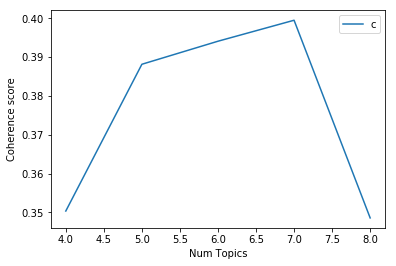

In [41]:
# display the coherence score of the different models
model_list_no_pooling = no_pooling_models[0]
coherence_values_no_pooling = no_pooling_models[1]

limit=9; start=4; step=1;
x = range(start, limit, step)
_ = plt.plot(x, coherence_values_no_pooling)
_ = plt.xlabel("Num Topics")
_ = plt.ylabel("Coherence score")
_ = plt.legend(("coherence_values"), loc='best')
_ = plt.savefig("no_pooling_coherence_scores")
_ = plt.show()

#### Choose the model with the highest coherence score (7 topics).

In [42]:
# print topics of model with highest coherence score
lda_model_no_pooling = model_list_no_pooling[3] # 7 topics model
_ = lda_model_no_pooling.print_topics()

2018-10-03 08:21:20,589 : INFO : topic #0 (0.131): 0.025*"milà" + 0.022*"pedreracasa" + 0.019*"ramblas" + 0.016*"time" + 0.012*"night" + 0.012*"sant" + 0.011*"can't" + 0.008*"see" + 0.008*"joan" + 0.008*"got"
2018-10-03 08:21:20,592 : INFO : topic #1 (0.130): 0.044*"drinking" + 0.032*"beach" + 0.023*"barceloneta" + 0.019*"playa" + 0.017*"parc" + 0.014*"platja" + 0.012*"city" + 0.011*"#endomondo" + 0.011*"marbella" + 0.010*"km"
2018-10-03 08:21:20,594 : INFO : topic #2 (0.205): 0.134*"sagrada" + 0.086*"familia" + 0.045*"basílica" + 0.042*"#sagradafamilia" + 0.036*"família" + 0.019*"#gaudi" + 0.017*"beautiful" + 0.010*"gaudi" + 0.008*"#architecture" + 0.008*"amazing"
2018-10-03 08:21:20,596 : INFO : topic #3 (0.123): 0.018*"hotel" + 0.012*"casa" + 0.007*"l'aquàrium" + 0.007*"night" + 0.007*"rooftop" + 0.006*"barca" + 0.006*"love" + 0.006*"shôko" + 0.005*"meet" + 0.005*"i'll"
2018-10-03 08:21:20,599 : INFO : topic #4 (0.121): 0.022*"#streetart" + 0.015*"festival" + 0.015*"#graffiti" + 0.0

### Visualize No Pooling Model

In [43]:
pyLDAvis.enable_notebook()
vis_np = pyLDAvis.gensim.prepare(lda_model_no_pooling, corpus_no_pooling, dictionary_no_pooling)

In [44]:
vis_np

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      22.695504        1       1  0.354868  0.030509
5      14.648993        1       2 -0.026311 -0.236267
6      13.631014        1       3 -0.030355  0.038944
0      12.604801        1       4 -0.030685 -0.015024
1      12.431315        1       5 -0.110802  0.268531
4      11.995498        1       6 -0.124476 -0.115319
3      11.992876        1       7 -0.032239  0.028626, topic_info=     Category         Freq             Term        Total  loglift  logprob
term                                                                      
112   Default  1144.000000          sagrada  1144.000000  30.0000  30.0000
129   Default   737.000000          familia   737.000000  29.0000  29.0000
565   Default   387.000000           gothic   387.000000  28.0000  28.0000
567   Default   344.000000          quarter   344.000000  27.0000  27.0000
109   Default   384.000000         basílica   384.000000  26.0000  26.0000
131   Default   361.000000  #sagradafamilia   361.000000  25.0000  25.0000
110   Default   307.000000          família   307.000000  24.0000  24.0000
66    Default   204.000000         drinking   204.000000  23.0000  23.0000
712   Default   148.000000            beach   148.000000  22.0000  22.0000
778   Default   119.000000             milà   119.000000  21.0000  21.0000
2686  Default   108.000000      barceloneta   108.000000  20.0000  20.0000
1135  Default   117.000000          #summer   117.000000  19.0000  19.0000
150   Default   170.000000           #gaudi   170.000000  18.0000  18.0000
780   Default   104.000000      pedreracasa   104.000000  17.0000  17.0000
134   Default   145.000000        beautiful   145.000000  16.0000  16.0000
21    Default    99.000000       #streetart    99.000000  15.0000  15.0000
3856  Default    89.000000          ramblas    89.000000  14.0000  14.0000
306   Default    95.000000            #love    95.000000  13.0000  13.0000
849   Default    83.000000            hotel    83.000000  12.0000  12.0000
4068  Default    96.000000            playa    96.000000  11.0000  11.0000
9     Default    81.000000             parc    81.000000  10.0000  10.0000
33    Default    76.000000         #friends    76.000000   9.0000   9.0000
17    Default    67.000000        #graffiti    67.000000   8.0000   8.0000
2665  Default    79.000000         festival    79.000000   7.0000   7.0000
1646  Default    64.000000           platja    64.000000   6.0000   6.0000
152   Default   109.000000            place   109.000000   5.0000   5.0000
4451  Default    56.000000       bcnfashion    56.000000   4.0000   4.0000
2005  Default    56.000000             sant    56.000000   3.0000   3.0000
2462  Default    60.000000           #beach    60.000000   2.0000   2.0000
526   Default    53.000000      #arteurbano    53.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
1616   Topic7    16.426624        catalunya    16.847537   2.0956  -5.6184
2388   Topic7    14.838078         cataluña    15.239053   2.0942  -5.7201
3776   Topic7    14.158901            david    14.552070   2.0935  -5.7670
3062   Topic7    14.308788             name    14.725754   2.0921  -5.7565
2441   Topic7    12.856640             shop    13.256185   2.0903  -5.8635
2624   Topic7    12.657247            santa    13.052799   2.0901  -5.8791
58     Topic7    12.834407             stay    13.235636   2.0901  -5.8652
1282   Topic7    13.064849      celebrating    13.479181   2.0896  -5.8474
2442   Topic7    12.455635            small    12.854928   2.0893  -5.8952
545    Topic7    13.365816         poblenou    13.796403   2.0891  -5.8246
579    Topic7    12.219528      #lasramblas    12.613410   2.0891  -5.9143
1321   Topic7    12.546651         progress    12.959961   2.0884  -5.8879
1146   Topic7    19.011710             pool    23.942942   1.8902  -5.4723
771    Topic7    20.6

#### Although a topic trend is already visible in the no pooling model, the topics are a little bit mixed up and could be more interpretable. This finding can be attributed to the shortness of tweets.

### User Pooling

In [31]:
# train and evaluate different user pooling models by running the function
user_pooling_models = compute_coherence_values(dictionary=dictionary_user_pooling,
                         corpus=corpus_user_pooling, texts=tokenized_documents_user_pooling)

2018-10-03 08:12:59,332 : INFO : using autotuned alpha, starting with [0.25, 0.25, 0.25, 0.25]
2018-10-03 08:12:59,336 : INFO : using serial LDA version on this node
2018-10-03 08:12:59,342 : INFO : running online (multi-pass) LDA training, 4 topics, 20 passes over the supplied corpus of 4424 documents, updating model once every 2000 documents, evaluating perplexity every 2000 documents, iterating 400x with a convergence threshold of 0.001000
2018-10-03 08:13:01,667 : INFO : -9.113 per-word bound, 553.6 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:13:01,668 : INFO : PROGRESS: pass 0, at document #2000/4424
2018-10-03 08:13:03,921 : INFO : optimized alpha [0.16434142, 0.15121301, 0.16912088, 0.16412929]
2018-10-03 08:13:03,922 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:13:03,928 : INFO : topic #0 (0.164): 0.022*"sagrada" + 0.019*"gothic" + 0.017*"basílica" + 0.016*"quarter" + 0.013*"família

2018-10-03 08:13:10,164 : INFO : topic #2 (0.162): 0.074*"sagrada" + 0.051*"familia" + 0.018*"basílica" + 0.018*"família" + 0.012*"barceloneta" + 0.011*"playa" + 0.011*"time" + 0.011*"#sagradafamilia" + 0.009*"gaudi" + 0.008*"#gaudi"
2018-10-03 08:13:10,167 : INFO : topic #3 (0.130): 0.022*"sagrada" + 0.021*"#sagradafamilia" + 0.013*"familia" + 0.009*"basílica" + 0.006*"#photography" + 0.006*"#gaudi" + 0.006*"#travel" + 0.005*"beautiful" + 0.005*"#streetart" + 0.005*"playa"
2018-10-03 08:13:10,169 : INFO : topic diff=0.391223, rho=0.487254
2018-10-03 08:13:11,188 : INFO : -7.712 per-word bound, 209.7 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:13:11,190 : INFO : PROGRESS: pass 2, at document #2000/4424
2018-10-03 08:13:11,958 : INFO : optimized alpha [0.13180847, 0.12305623, 0.15636063, 0.12382236]
2018-10-03 08:13:11,959 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:13:11,964 : INFO : topic

2018-10-03 08:13:17,707 : INFO : topic #2 (0.156): 0.085*"sagrada" + 0.055*"familia" + 0.025*"basílica" + 0.024*"família" + 0.013*"#sagradafamilia" + 0.010*"time" + 0.009*"gaudi" + 0.008*"#gaudi" + 0.007*"playa" + 0.006*"barceloneta"
2018-10-03 08:13:17,709 : INFO : topic #3 (0.109): 0.019*"#sagradafamilia" + 0.010*"sagrada" + 0.006*"#photography" + 0.006*"#gaudi" + 0.006*"#streetart" + 0.006*"#travel" + 0.005*"basílica" + 0.005*"familia" + 0.005*"best" + 0.005*"#love"
2018-10-03 08:13:17,711 : INFO : topic diff=0.265637, rho=0.401222
2018-10-03 08:13:18,613 : INFO : -7.614 per-word bound, 195.9 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:13:18,615 : INFO : PROGRESS: pass 4, at document #2000/4424
2018-10-03 08:13:19,250 : INFO : optimized alpha [0.1192699, 0.11312786, 0.15220697, 0.10578299]
2018-10-03 08:13:19,252 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:13:19,257 : INFO : topic #0 (0

2018-10-03 08:13:24,398 : INFO : topic #2 (0.148): 0.088*"sagrada" + 0.056*"familia" + 0.028*"basílica" + 0.025*"família" + 0.014*"#sagradafamilia" + 0.010*"time" + 0.009*"gaudi" + 0.008*"#gaudi" + 0.006*"beautiful" + 0.006*"milà"
2018-10-03 08:13:24,401 : INFO : topic #3 (0.097): 0.018*"#sagradafamilia" + 0.007*"#streetart" + 0.007*"#travel" + 0.006*"#gaudi" + 0.006*"#photography" + 0.005*"#love" + 0.005*"city" + 0.005*"#graffiti" + 0.005*"best" + 0.005*"#architecture"
2018-10-03 08:13:24,403 : INFO : topic diff=0.213031, rho=0.348960
2018-10-03 08:13:25,309 : INFO : -7.568 per-word bound, 189.8 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:13:25,310 : INFO : PROGRESS: pass 6, at document #2000/4424
2018-10-03 08:13:25,922 : INFO : optimized alpha [0.11101292, 0.10718457, 0.14457586, 0.095329642]
2018-10-03 08:13:25,924 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:13:25,932 : INFO : topic #0

2018-10-03 08:13:31,702 : INFO : topic #2 (0.138): 0.090*"sagrada" + 0.057*"familia" + 0.029*"basílica" + 0.025*"família" + 0.015*"#sagradafamilia" + 0.009*"time" + 0.009*"gaudi" + 0.008*"#gaudi" + 0.007*"beautiful" + 0.007*"milà"
2018-10-03 08:13:31,705 : INFO : topic #3 (0.089): 0.018*"#sagradafamilia" + 0.007*"#streetart" + 0.007*"#travel" + 0.006*"#gaudi" + 0.006*"#photography" + 0.006*"#love" + 0.005*"#graffiti" + 0.005*"city" + 0.005*"best" + 0.005*"#summer"
2018-10-03 08:13:31,707 : INFO : topic diff=0.182461, rho=0.312928
2018-10-03 08:13:32,619 : INFO : -7.541 per-word bound, 186.2 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:13:32,620 : INFO : PROGRESS: pass 8, at document #2000/4424
2018-10-03 08:13:33,237 : INFO : optimized alpha [0.10426988, 0.10219834, 0.13613066, 0.08800865]
2018-10-03 08:13:33,239 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:13:33,245 : INFO : topic #0 (0.104

2018-10-03 08:13:37,914 : INFO : topic #2 (0.130): 0.090*"sagrada" + 0.057*"familia" + 0.029*"basílica" + 0.025*"família" + 0.016*"#sagradafamilia" + 0.009*"gaudi" + 0.009*"time" + 0.008*"#gaudi" + 0.007*"beautiful" + 0.007*"milà"
2018-10-03 08:13:37,917 : INFO : topic #3 (0.083): 0.017*"#sagradafamilia" + 0.007*"#streetart" + 0.007*"#travel" + 0.006*"#photography" + 0.006*"#gaudi" + 0.006*"#love" + 0.005*"#graffiti" + 0.005*"#summer" + 0.005*"best" + 0.005*"city"
2018-10-03 08:13:37,919 : INFO : topic diff=0.161677, rho=0.286158
2018-10-03 08:13:38,735 : INFO : -7.522 per-word bound, 183.8 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:13:38,736 : INFO : PROGRESS: pass 10, at document #2000/4424
2018-10-03 08:13:39,286 : INFO : optimized alpha [0.098222099, 0.097308815, 0.12864208, 0.082641371]
2018-10-03 08:13:39,288 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:13:39,293 : INFO : topic #0 (0

2018-10-03 08:13:43,605 : INFO : topic #2 (0.123): 0.091*"sagrada" + 0.057*"familia" + 0.029*"basílica" + 0.025*"família" + 0.016*"#sagradafamilia" + 0.009*"gaudi" + 0.009*"time" + 0.008*"#gaudi" + 0.007*"beautiful" + 0.007*"milà"
2018-10-03 08:13:43,607 : INFO : topic #3 (0.079): 0.017*"#sagradafamilia" + 0.008*"#travel" + 0.008*"#streetart" + 0.006*"#photography" + 0.006*"#gaudi" + 0.006*"#love" + 0.006*"#graffiti" + 0.005*"#summer" + 0.005*"city" + 0.005*"best"
2018-10-03 08:13:43,609 : INFO : topic diff=0.146748, rho=0.265260
2018-10-03 08:13:44,314 : INFO : -7.508 per-word bound, 182.0 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:13:44,316 : INFO : PROGRESS: pass 12, at document #2000/4424
2018-10-03 08:13:44,923 : INFO : optimized alpha [0.093196861, 0.0931703, 0.12241832, 0.078547336]
2018-10-03 08:13:44,925 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:13:44,930 : INFO : topic #0 (0.0

2018-10-03 08:13:49,862 : INFO : topic #2 (0.118): 0.091*"sagrada" + 0.058*"familia" + 0.030*"basílica" + 0.025*"família" + 0.017*"#sagradafamilia" + 0.009*"gaudi" + 0.009*"time" + 0.009*"#gaudi" + 0.007*"beautiful" + 0.007*"milà"
2018-10-03 08:13:49,865 : INFO : topic #3 (0.075): 0.017*"#sagradafamilia" + 0.008*"#travel" + 0.008*"#streetart" + 0.006*"#photography" + 0.006*"#love" + 0.006*"#gaudi" + 0.006*"#graffiti" + 0.005*"#summer" + 0.005*"#europe" + 0.005*"#architecture"
2018-10-03 08:13:49,868 : INFO : topic diff=0.134630, rho=0.248360
2018-10-03 08:13:50,767 : INFO : -7.496 per-word bound, 180.5 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:13:50,769 : INFO : PROGRESS: pass 14, at document #2000/4424
2018-10-03 08:13:51,325 : INFO : optimized alpha [0.089213915, 0.089548752, 0.1168642, 0.074995935]
2018-10-03 08:13:51,327 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:13:51,333 : INFO : 

2018-10-03 08:13:55,527 : INFO : topic #1 (0.087): 0.037*"gothic" + 0.036*"quarter" + 0.020*"barceloneta" + 0.019*"playa" + 0.014*"beach" + 0.008*"#summer" + 0.008*"platja" + 0.007*"festival" + 0.007*"#beach" + 0.007*"sant"
2018-10-03 08:13:55,530 : INFO : topic #2 (0.113): 0.092*"sagrada" + 0.058*"familia" + 0.030*"basílica" + 0.026*"família" + 0.017*"#sagradafamilia" + 0.009*"gaudi" + 0.009*"time" + 0.009*"#gaudi" + 0.008*"beautiful" + 0.007*"milà"
2018-10-03 08:13:55,532 : INFO : topic #3 (0.072): 0.016*"#sagradafamilia" + 0.009*"#travel" + 0.008*"#streetart" + 0.007*"#photography" + 0.006*"#love" + 0.006*"#gaudi" + 0.006*"#graffiti" + 0.005*"#summer" + 0.005*"#architecture" + 0.005*"#europe"
2018-10-03 08:13:55,535 : INFO : topic diff=0.125530, rho=0.234326
2018-10-03 08:13:56,332 : INFO : -7.486 per-word bound, 179.3 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:13:56,334 : INFO : PROGRESS: pass 16, at document #2000/4424
2018-10-0

2018-10-03 08:14:00,985 : INFO : topic #0 (0.084): 0.009*"night" + 0.009*"parc" + 0.008*"time" + 0.008*"love" + 0.007*"amazing" + 0.006*"see" + 0.006*"finished" + 0.006*"today" + 0.005*"great" + 0.005*"got"
2018-10-03 08:14:00,987 : INFO : topic #1 (0.084): 0.038*"gothic" + 0.036*"quarter" + 0.020*"barceloneta" + 0.019*"playa" + 0.014*"beach" + 0.008*"#summer" + 0.008*"platja" + 0.007*"festival" + 0.007*"#beach" + 0.007*"sant"
2018-10-03 08:14:00,990 : INFO : topic #2 (0.108): 0.092*"sagrada" + 0.058*"familia" + 0.031*"basílica" + 0.026*"família" + 0.017*"#sagradafamilia" + 0.009*"gaudi" + 0.009*"time" + 0.009*"#gaudi" + 0.008*"beautiful" + 0.008*"milà"
2018-10-03 08:14:00,992 : INFO : topic #3 (0.070): 0.016*"#sagradafamilia" + 0.009*"#travel" + 0.008*"#streetart" + 0.007*"#photography" + 0.006*"#love" + 0.006*"#gaudi" + 0.006*"#graffiti" + 0.005*"#summer" + 0.005*"#architecture" + 0.005*"#europe"
2018-10-03 08:14:00,995 : INFO : topic diff=0.117707, rho=0.222431
2018-10-03 08:14:01,7

2018-10-03 08:14:05,814 : INFO : optimized alpha [0.081940971, 0.081233576, 0.10469615, 0.067351386]
2018-10-03 08:14:05,817 : INFO : merging changes from 424 documents into a model of 4424 documents
2018-10-03 08:14:05,821 : INFO : topic #0 (0.082): 0.009*"night" + 0.009*"parc" + 0.008*"time" + 0.008*"love" + 0.007*"amazing" + 0.006*"see" + 0.006*"finished" + 0.006*"today" + 0.005*"great" + 0.005*"got"
2018-10-03 08:14:05,824 : INFO : topic #1 (0.081): 0.038*"gothic" + 0.036*"quarter" + 0.020*"barceloneta" + 0.019*"playa" + 0.014*"beach" + 0.008*"#summer" + 0.008*"platja" + 0.007*"festival" + 0.007*"#beach" + 0.007*"sant"
2018-10-03 08:14:05,826 : INFO : topic #2 (0.105): 0.093*"sagrada" + 0.059*"familia" + 0.031*"basílica" + 0.026*"família" + 0.017*"#sagradafamilia" + 0.009*"gaudi" + 0.009*"time" + 0.009*"#gaudi" + 0.008*"beautiful" + 0.008*"milà"
2018-10-03 08:14:05,828 : INFO : topic #3 (0.067): 0.016*"#sagradafamilia" + 0.009*"#travel" + 0.008*"#streetart" + 0.007*"#photography" +

2018-10-03 08:14:15,691 : INFO : PROGRESS: pass 0, at document #4000/4424
2018-10-03 08:14:16,269 : INFO : optimized alpha [0.13696091, 0.1411847, 0.13552333, 0.12404747, 0.12485948]
2018-10-03 08:14:16,270 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:14:16,276 : INFO : topic #0 (0.137): 0.068*"sagrada" + 0.059*"familia" + 0.010*"beach" + 0.009*"basílica" + 0.009*"#sagradafamilia" + 0.008*"drinking" + 0.008*"beautiful" + 0.007*"família" + 0.007*"gaudi" + 0.005*"city"
2018-10-03 08:14:16,278 : INFO : topic #1 (0.141): 0.041*"sagrada" + 0.032*"basílica" + 0.027*"família" + 0.023*"gothic" + 0.021*"quarter" + 0.010*"familia" + 0.010*"#sagradafamilia" + 0.008*"amazing" + 0.007*"beautiful" + 0.006*"time"
2018-10-03 08:14:16,280 : INFO : topic #2 (0.136): 0.031*"sagrada" + 0.023*"familia" + 0.011*"gothic" + 0.010*"quarter" + 0.010*"milà" + 0.010*"#sagradafamilia" + 0.009*"#travel" + 0.008*"pedreracasa" + 0.008*"#photography" + 0.007*"basílica"
2018

2018-10-03 08:14:20,953 : INFO : PROGRESS: pass 2, at document #2000/4424
2018-10-03 08:14:21,588 : INFO : optimized alpha [0.13073669, 0.13869525, 0.11668857, 0.11608561, 0.10355403]
2018-10-03 08:14:21,590 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:14:21,596 : INFO : topic #0 (0.131): 0.070*"sagrada" + 0.058*"familia" + 0.017*"barceloneta" + 0.014*"playa" + 0.012*"beach" + 0.010*"drinking" + 0.009*"#sagradafamilia" + 0.009*"gaudi" + 0.008*"platja" + 0.007*"beautiful"
2018-10-03 08:14:21,598 : INFO : topic #1 (0.139): 0.039*"gothic" + 0.038*"sagrada" + 0.035*"quarter" + 0.031*"basílica" + 0.027*"família" + 0.010*"familia" + 0.009*"#sagradafamilia" + 0.008*"amazing" + 0.006*"fashion" + 0.006*"view"
2018-10-03 08:14:21,604 : INFO : topic #2 (0.117): 0.015*"sagrada" + 0.014*"milà" + 0.013*"pedreracasa" + 0.011*"familia" + 0.010*"#travel" + 0.009*"#photography" + 0.007*"drinking" + 0.007*"#sagradafamilia" + 0.006*"casa" + 0.005*"food"
2018-10

2018-10-03 08:14:27,072 : INFO : PROGRESS: pass 3, at document #4424/4424
2018-10-03 08:14:27,223 : INFO : optimized alpha [0.13380246, 0.1391602, 0.10885348, 0.11513433, 0.095762655]
2018-10-03 08:14:27,224 : INFO : merging changes from 424 documents into a model of 4424 documents
2018-10-03 08:14:27,230 : INFO : topic #0 (0.134): 0.079*"sagrada" + 0.069*"familia" + 0.025*"barceloneta" + 0.022*"playa" + 0.014*"beach" + 0.012*"#sagradafamilia" + 0.010*"gaudi" + 0.010*"platja" + 0.007*"beautiful" + 0.007*"city"
2018-10-03 08:14:27,232 : INFO : topic #1 (0.139): 0.043*"sagrada" + 0.037*"gothic" + 0.035*"basílica" + 0.034*"quarter" + 0.030*"família" + 0.011*"#sagradafamilia" + 0.009*"familia" + 0.009*"amazing" + 0.008*"view" + 0.006*"beautiful"
2018-10-03 08:14:27,235 : INFO : topic #2 (0.109): 0.011*"milà" + 0.010*"sagrada" + 0.010*"pedreracasa" + 0.009*"#travel" + 0.008*"#sagradafamilia" + 0.007*"#photography" + 0.006*"#gaudi" + 0.005*"familia" + 0.005*"night" + 0.005*"joan"
2018-10-03 

2018-10-03 08:14:31,621 : INFO : PROGRESS: pass 5, at document #4000/4424
2018-10-03 08:14:32,041 : INFO : optimized alpha [0.1299752, 0.13372611, 0.10247558, 0.11103317, 0.088897057]
2018-10-03 08:14:32,043 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:14:32,051 : INFO : topic #0 (0.130): 0.088*"sagrada" + 0.077*"familia" + 0.014*"#sagradafamilia" + 0.013*"beach" + 0.012*"barceloneta" + 0.010*"playa" + 0.009*"gaudi" + 0.007*"city" + 0.007*"beautiful" + 0.007*"drinking"
2018-10-03 08:14:32,061 : INFO : topic #1 (0.134): 0.043*"sagrada" + 0.037*"gothic" + 0.037*"basílica" + 0.033*"quarter" + 0.030*"família" + 0.012*"#sagradafamilia" + 0.008*"familia" + 0.008*"amazing" + 0.007*"beautiful" + 0.005*"#art"
2018-10-03 08:14:32,065 : INFO : topic #2 (0.102): 0.014*"milà" + 0.012*"pedreracasa" + 0.010*"#travel" + 0.009*"#sagradafamilia" + 0.008*"#photography" + 0.007*"sagrada" + 0.007*"drinking" + 0.006*"#gaudi" + 0.006*"casa" + 0.005*"food"
2018-10-

2018-10-03 08:14:36,562 : INFO : PROGRESS: pass 7, at document #2000/4424
2018-10-03 08:14:37,094 : INFO : optimized alpha [0.12504429, 0.1291461, 0.097629242, 0.10788134, 0.084017456]
2018-10-03 08:14:37,096 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:14:37,101 : INFO : topic #0 (0.125): 0.081*"sagrada" + 0.070*"familia" + 0.017*"barceloneta" + 0.014*"playa" + 0.013*"#sagradafamilia" + 0.012*"beach" + 0.010*"gaudi" + 0.008*"drinking" + 0.008*"platja" + 0.007*"festival"
2018-10-03 08:14:37,103 : INFO : topic #1 (0.129): 0.041*"gothic" + 0.040*"sagrada" + 0.037*"quarter" + 0.034*"basílica" + 0.029*"família" + 0.011*"#sagradafamilia" + 0.008*"amazing" + 0.007*"familia" + 0.006*"beautiful" + 0.006*"fashion"
2018-10-03 08:14:37,105 : INFO : topic #2 (0.098): 0.015*"milà" + 0.013*"pedreracasa" + 0.010*"#travel" + 0.008*"#photography" + 0.008*"drinking" + 0.008*"#sagradafamilia" + 0.006*"casa" + 0.006*"#gaudi" + 0.005*"food" + 0.005*"sagrada"
201

2018-10-03 08:14:41,241 : INFO : PROGRESS: pass 8, at document #4424/4424
2018-10-03 08:14:41,372 : INFO : optimized alpha [0.12605172, 0.12663984, 0.094244964, 0.10781433, 0.081520431]
2018-10-03 08:14:41,377 : INFO : merging changes from 424 documents into a model of 4424 documents
2018-10-03 08:14:41,384 : INFO : topic #0 (0.126): 0.084*"sagrada" + 0.074*"familia" + 0.022*"barceloneta" + 0.019*"playa" + 0.014*"#sagradafamilia" + 0.013*"beach" + 0.010*"gaudi" + 0.009*"platja" + 0.007*"city" + 0.007*"beautiful"
2018-10-03 08:14:41,387 : INFO : topic #1 (0.127): 0.041*"sagrada" + 0.039*"gothic" + 0.036*"basílica" + 0.035*"quarter" + 0.031*"família" + 0.012*"#sagradafamilia" + 0.008*"amazing" + 0.007*"view" + 0.006*"beautiful" + 0.006*"fashion"
2018-10-03 08:14:41,390 : INFO : topic #2 (0.094): 0.012*"milà" + 0.011*"pedreracasa" + 0.009*"#travel" + 0.008*"#sagradafamilia" + 0.007*"#photography" + 0.006*"drinking" + 0.006*"#gaudi" + 0.005*"joan" + 0.005*"night" + 0.005*"casa"
2018-10-03 

2018-10-03 08:14:45,771 : INFO : PROGRESS: pass 10, at document #4000/4424
2018-10-03 08:14:46,157 : INFO : optimized alpha [0.12433054, 0.12248491, 0.09147615, 0.10669944, 0.078137167]
2018-10-03 08:14:46,159 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:14:46,164 : INFO : topic #0 (0.124): 0.091*"sagrada" + 0.080*"familia" + 0.016*"#sagradafamilia" + 0.013*"barceloneta" + 0.013*"beach" + 0.011*"playa" + 0.010*"gaudi" + 0.007*"city" + 0.007*"beautiful" + 0.007*"platja"
2018-10-03 08:14:46,166 : INFO : topic #1 (0.122): 0.041*"sagrada" + 0.039*"gothic" + 0.038*"basílica" + 0.035*"quarter" + 0.031*"família" + 0.012*"#sagradafamilia" + 0.008*"amazing" + 0.007*"beautiful" + 0.005*"#art" + 0.005*"view"
2018-10-03 08:14:46,168 : INFO : topic #2 (0.091): 0.015*"milà" + 0.013*"pedreracasa" + 0.010*"#travel" + 0.008*"#photography" + 0.008*"#sagradafamilia" + 0.007*"drinking" + 0.006*"casa" + 0.005*"#gaudi" + 0.005*"food" + 0.005*"night"
2018-10-03 08

2018-10-03 08:14:49,722 : INFO : PROGRESS: pass 12, at document #2000/4424
2018-10-03 08:14:50,306 : INFO : optimized alpha [0.12133457, 0.1189701, 0.089081295, 0.10486029, 0.075765885]
2018-10-03 08:14:50,307 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:14:50,313 : INFO : topic #0 (0.121): 0.086*"sagrada" + 0.075*"familia" + 0.017*"barceloneta" + 0.014*"#sagradafamilia" + 0.014*"playa" + 0.012*"beach" + 0.010*"gaudi" + 0.008*"platja" + 0.008*"drinking" + 0.007*"festival"
2018-10-03 08:14:50,314 : INFO : topic #1 (0.119): 0.043*"gothic" + 0.038*"quarter" + 0.038*"sagrada" + 0.035*"basílica" + 0.030*"família" + 0.011*"#sagradafamilia" + 0.007*"amazing" + 0.006*"fashion" + 0.006*"beautiful" + 0.006*"#art"
2018-10-03 08:14:50,317 : INFO : topic #2 (0.089): 0.015*"milà" + 0.014*"pedreracasa" + 0.010*"#travel" + 0.008*"drinking" + 0.008*"#photography" + 0.008*"#sagradafamilia" + 0.006*"casa" + 0.006*"#gaudi" + 0.005*"food" + 0.005*"joan"
2018-10-

2018-10-03 08:14:53,684 : INFO : PROGRESS: pass 13, at document #4424/4424
2018-10-03 08:14:53,774 : INFO : optimized alpha [0.12185188, 0.11729149, 0.087155893, 0.1046812, 0.074781626]
2018-10-03 08:14:53,776 : INFO : merging changes from 424 documents into a model of 4424 documents
2018-10-03 08:14:53,782 : INFO : topic #0 (0.122): 0.088*"sagrada" + 0.077*"familia" + 0.021*"barceloneta" + 0.018*"playa" + 0.015*"#sagradafamilia" + 0.012*"beach" + 0.010*"gaudi" + 0.009*"platja" + 0.007*"city" + 0.007*"beautiful"
2018-10-03 08:14:53,784 : INFO : topic #1 (0.117): 0.041*"gothic" + 0.039*"sagrada" + 0.037*"basílica" + 0.036*"quarter" + 0.031*"família" + 0.012*"#sagradafamilia" + 0.007*"amazing" + 0.006*"beautiful" + 0.006*"fashion" + 0.006*"view"
2018-10-03 08:14:53,786 : INFO : topic #2 (0.087): 0.013*"milà" + 0.011*"pedreracasa" + 0.010*"#travel" + 0.008*"#photography" + 0.007*"#sagradafamilia" + 0.007*"drinking" + 0.006*"#gaudi" + 0.005*"casa" + 0.005*"joan" + 0.005*"night"
2018-10-03 

2018-10-03 08:14:58,188 : INFO : PROGRESS: pass 15, at document #4000/4424
2018-10-03 08:14:58,566 : INFO : optimized alpha [0.120534, 0.11459725, 0.08559569, 0.10410901, 0.07282728]
2018-10-03 08:14:58,568 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:14:58,574 : INFO : topic #0 (0.121): 0.092*"sagrada" + 0.082*"familia" + 0.016*"#sagradafamilia" + 0.014*"barceloneta" + 0.012*"beach" + 0.012*"playa" + 0.010*"gaudi" + 0.007*"city" + 0.007*"beautiful" + 0.007*"platja"
2018-10-03 08:14:58,576 : INFO : topic #1 (0.115): 0.041*"gothic" + 0.039*"sagrada" + 0.038*"basílica" + 0.036*"quarter" + 0.031*"família" + 0.012*"#sagradafamilia" + 0.007*"amazing" + 0.007*"beautiful" + 0.005*"#art" + 0.005*"fashion"
2018-10-03 08:14:58,578 : INFO : topic #2 (0.086): 0.015*"milà" + 0.013*"pedreracasa" + 0.010*"#travel" + 0.008*"#photography" + 0.008*"#sagradafamilia" + 0.008*"drinking" + 0.006*"casa" + 0.005*"#gaudi" + 0.005*"food" + 0.005*"joan"
2018-10-03 08:

2018-10-03 08:15:01,706 : INFO : PROGRESS: pass 17, at document #2000/4424
2018-10-03 08:15:02,149 : INFO : optimized alpha [0.11793477, 0.11257277, 0.084140211, 0.10265891, 0.071360916]
2018-10-03 08:15:02,151 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:15:02,155 : INFO : topic #0 (0.118): 0.088*"sagrada" + 0.077*"familia" + 0.017*"barceloneta" + 0.015*"#sagradafamilia" + 0.014*"playa" + 0.011*"beach" + 0.010*"gaudi" + 0.008*"platja" + 0.007*"drinking" + 0.007*"festival"
2018-10-03 08:15:02,158 : INFO : topic #1 (0.113): 0.043*"gothic" + 0.039*"quarter" + 0.037*"sagrada" + 0.036*"basílica" + 0.030*"família" + 0.011*"#sagradafamilia" + 0.007*"amazing" + 0.006*"fashion" + 0.006*"beautiful" + 0.006*"#art"
2018-10-03 08:15:02,160 : INFO : topic #2 (0.084): 0.016*"milà" + 0.014*"pedreracasa" + 0.010*"#travel" + 0.009*"drinking" + 0.008*"#photography" + 0.007*"#sagradafamilia" + 0.006*"casa" + 0.006*"#gaudi" + 0.005*"food" + 0.005*"joan"
2018-10

2018-10-03 08:15:05,667 : INFO : PROGRESS: pass 18, at document #4424/4424
2018-10-03 08:15:05,773 : INFO : optimized alpha [0.11842457, 0.11202215, 0.082798503, 0.10259653, 0.070653759]
2018-10-03 08:15:05,775 : INFO : merging changes from 424 documents into a model of 4424 documents
2018-10-03 08:15:05,781 : INFO : topic #0 (0.118): 0.089*"sagrada" + 0.078*"familia" + 0.020*"barceloneta" + 0.018*"playa" + 0.016*"#sagradafamilia" + 0.012*"beach" + 0.010*"gaudi" + 0.009*"platja" + 0.007*"beautiful" + 0.007*"city"
2018-10-03 08:15:05,783 : INFO : topic #1 (0.112): 0.041*"gothic" + 0.038*"basílica" + 0.038*"sagrada" + 0.037*"quarter" + 0.031*"família" + 0.012*"#sagradafamilia" + 0.007*"amazing" + 0.006*"fashion" + 0.006*"beautiful" + 0.006*"view"
2018-10-03 08:15:05,786 : INFO : topic #2 (0.083): 0.014*"milà" + 0.012*"pedreracasa" + 0.010*"#travel" + 0.008*"#photography" + 0.007*"#sagradafamilia" + 0.007*"drinking" + 0.006*"#gaudi" + 0.006*"casa" + 0.005*"joan" + 0.005*"food"
2018-10-03 

2018-10-03 08:15:13,149 : INFO : 15 batches submitted to accumulate stats from 960 documents (25685 virtual)
2018-10-03 08:15:13,158 : INFO : 16 batches submitted to accumulate stats from 1024 documents (26237 virtual)
2018-10-03 08:15:13,167 : INFO : 17 batches submitted to accumulate stats from 1088 documents (26666 virtual)
2018-10-03 08:15:13,198 : INFO : 18 batches submitted to accumulate stats from 1152 documents (27179 virtual)
2018-10-03 08:15:13,202 : INFO : 19 batches submitted to accumulate stats from 1216 documents (27567 virtual)
2018-10-03 08:15:13,216 : INFO : 20 batches submitted to accumulate stats from 1280 documents (28042 virtual)
2018-10-03 08:15:13,227 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28183 virtual)
2018-10-03 08:15:13,230 : INFO : 22 batches submitted to accumulate stats from 1408 documents (28353 virtual)
2018-10-03 08:15:13,243 : INFO : 23 batches submitted to accumulate stats from 1472 documents (28493 virtual)
2018-10-03 

2018-10-03 08:15:18,108 : INFO : topic #5 (0.130): 0.072*"sagrada" + 0.039*"basílica" + 0.033*"família" + 0.032*"familia" + 0.025*"#sagradafamilia" + 0.010*"time" + 0.008*"view" + 0.008*"#gaudi" + 0.007*"beautiful" + 0.006*"best"
2018-10-03 08:15:18,110 : INFO : topic diff=0.640758, rho=0.577350
2018-10-03 08:15:18,918 : INFO : -7.845 per-word bound, 229.9 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:15:18,919 : INFO : PROGRESS: pass 1, at document #2000/4424
2018-10-03 08:15:19,518 : INFO : optimized alpha [0.11069811, 0.11734494, 0.10963206, 0.10688118, 0.10034462, 0.12808989]
2018-10-03 08:15:19,520 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:15:19,526 : INFO : topic #4 (0.100): 0.010*"drinking" + 0.010*"#streetart" + 0.010*"#endomondo" + 0.009*"fashion" + 0.009*"km" + 0.009*"#travel" + 0.008*"#endorphins" + 0.008*"#arteurbano" + 0.008*"festival" + 0.008*"#love"
2018-10-03 08:15:19,527 :

2018-10-03 08:15:23,437 : INFO : topic #5 (0.133): 0.079*"sagrada" + 0.042*"basílica" + 0.037*"familia" + 0.033*"família" + 0.033*"#sagradafamilia" + 0.011*"#gaudi" + 0.009*"beautiful" + 0.009*"time" + 0.007*"drinking" + 0.006*"view"
2018-10-03 08:15:23,439 : INFO : topic diff=0.255273, rho=0.438024
2018-10-03 08:15:23,580 : INFO : -7.698 per-word bound, 207.7 perplexity estimate based on a held-out corpus of 424 documents with 2007 words
2018-10-03 08:15:23,581 : INFO : PROGRESS: pass 2, at document #4424/4424
2018-10-03 08:15:23,683 : INFO : optimized alpha [0.10829102, 0.1202701, 0.10448706, 0.10033675, 0.088561267, 0.12972522]
2018-10-03 08:15:23,685 : INFO : merging changes from 424 documents into a model of 4424 documents
2018-10-03 08:15:23,691 : INFO : topic #4 (0.089): 0.011*"fashion" + 0.011*"finished" + 0.010*"#endomondo" + 0.009*"km" + 0.009*"#endorphins" + 0.009*"new" + 0.008*"#streetart" + 0.008*"sound" + 0.008*"recinte" + 0.008*"#love"
2018-10-03 08:15:23,692 : INFO : to

2018-10-03 08:15:27,374 : INFO : topic diff=0.362764, rho=0.372368
2018-10-03 08:15:27,966 : INFO : -7.992 per-word bound, 254.5 perplexity estimate based on a held-out corpus of 2000 documents with 9561 words
2018-10-03 08:15:27,967 : INFO : PROGRESS: pass 4, at document #4000/4424
2018-10-03 08:15:28,381 : INFO : optimized alpha [0.10061995, 0.11764424, 0.10079428, 0.093607977, 0.081866935, 0.13302447]
2018-10-03 08:15:28,382 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:15:28,388 : INFO : topic #4 (0.082): 0.013*"#streetart" + 0.009*"#love" + 0.009*"#endomondo" + 0.009*"finished" + 0.009*"festival" + 0.008*"drinking" + 0.008*"#art" + 0.008*"km" + 0.008*"fashion" + 0.008*"#endorphins"
2018-10-03 08:15:28,390 : INFO : topic #3 (0.094): 0.012*"love" + 0.011*"see" + 0.011*"amazing" + 0.010*"night" + 0.008*"happy" + 0.007*"work" + 0.007*"week" + 0.007*"great" + 0.007*"trip" + 0.007*"time"
2018-10-03 08:15:28,392 : INFO : topic #2 (0.101): 0.008

2018-10-03 08:15:31,732 : INFO : PROGRESS: pass 6, at document #2000/4424
2018-10-03 08:15:32,197 : INFO : optimized alpha [0.093392655, 0.11760871, 0.097645059, 0.088817298, 0.078662798, 0.13117176]
2018-10-03 08:15:32,199 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:15:32,205 : INFO : topic #4 (0.079): 0.016*"#streetart" + 0.010*"#graffiti" + 0.010*"fashion" + 0.010*"drinking" + 0.010*"#endomondo" + 0.009*"#love" + 0.009*"festival" + 0.009*"km" + 0.009*"#art" + 0.009*"#arteurbano"
2018-10-03 08:15:32,207 : INFO : topic #3 (0.089): 0.013*"see" + 0.012*"love" + 0.011*"night" + 0.008*"amazing" + 0.008*"week" + 0.007*"great" + 0.007*"happy" + 0.007*"work" + 0.006*"time" + 0.006*"trip"
2018-10-03 08:15:32,210 : INFO : topic #2 (0.098): 0.009*"time" + 0.008*"best" + 0.007*"new" + 0.006*"joan" + 0.006*"l'aquàrium" + 0.005*"today" + 0.005*"really" + 0.005*"good" + 0.005*"place" + 0.005*"arena"
2018-10-03 08:15:32,212 : INFO : topic #1 (0.118): 0.0

2018-10-03 08:15:35,769 : INFO : merging changes from 424 documents into a model of 4424 documents
2018-10-03 08:15:35,774 : INFO : topic #4 (0.076): 0.013*"#streetart" + 0.011*"fashion" + 0.010*"finished" + 0.010*"#endomondo" + 0.009*"km" + 0.009*"#endorphins" + 0.009*"#love" + 0.009*"new" + 0.008*"festival" + 0.008*"#art"
2018-10-03 08:15:35,776 : INFO : topic #3 (0.087): 0.014*"see" + 0.013*"love" + 0.011*"night" + 0.009*"week" + 0.008*"amazing" + 0.008*"time" + 0.008*"trip" + 0.008*"great" + 0.007*"got" + 0.007*"happy"
2018-10-03 08:15:35,778 : INFO : topic #2 (0.097): 0.009*"best" + 0.009*"time" + 0.006*"new" + 0.006*"joan" + 0.006*"really" + 0.006*"place" + 0.005*"today" + 0.005*"arena" + 0.005*"l'aquàrium" + 0.005*"miró"
2018-10-03 08:15:35,780 : INFO : topic #1 (0.117): 0.050*"gothic" + 0.045*"quarter" + 0.016*"beach" + 0.011*"#summer" + 0.011*"playa" + 0.010*"milà" + 0.009*"pedreracasa" + 0.009*"barceloneta" + 0.009*"#beach" + 0.009*"city"
2018-10-03 08:15:35,782 : INFO : topi

2018-10-03 08:15:40,307 : INFO : topic #0 (0.084): 0.017*"parc" + 0.016*"barceloneta" + 0.013*"playa" + 0.011*"sagrada" + 0.011*"familia" + 0.007*"platja" + 0.007*"time" + 0.007*"guell" + 0.007*"laberint" + 0.006*"architecture"
2018-10-03 08:15:40,309 : INFO : topic #2 (0.096): 0.008*"time" + 0.008*"best" + 0.007*"new" + 0.006*"really" + 0.006*"today" + 0.005*"joan" + 0.005*"l'aquàrium" + 0.005*"arena" + 0.005*"place" + 0.005*"know"
2018-10-03 08:15:40,311 : INFO : topic #1 (0.115): 0.051*"gothic" + 0.046*"quarter" + 0.016*"beach" + 0.012*"milà" + 0.011*"pedreracasa" + 0.010*"#summer" + 0.010*"city" + 0.008*"hotel" + 0.008*"#beach" + 0.008*"night"
2018-10-03 08:15:40,314 : INFO : topic #5 (0.145): 0.109*"sagrada" + 0.068*"familia" + 0.038*"basílica" + 0.034*"#sagradafamilia" + 0.031*"família" + 0.012*"#gaudi" + 0.009*"beautiful" + 0.008*"gaudi" + 0.008*"time" + 0.007*"drinking"
2018-10-03 08:15:40,316 : INFO : topic diff=0.118429, rho=0.286158
2018-10-03 08:15:40,437 : INFO : -7.521 pe

2018-10-03 08:15:43,805 : INFO : topic #2 (0.095): 0.009*"time" + 0.009*"best" + 0.007*"new" + 0.006*"really" + 0.006*"joan" + 0.006*"l'aquàrium" + 0.005*"today" + 0.005*"arena" + 0.005*"place" + 0.005*"good"
2018-10-03 08:15:43,807 : INFO : topic #1 (0.114): 0.054*"gothic" + 0.048*"quarter" + 0.014*"beach" + 0.013*"milà" + 0.012*"pedreracasa" + 0.011*"#summer" + 0.009*"city" + 0.009*"#beach" + 0.008*"hotel" + 0.008*"night"
2018-10-03 08:15:43,810 : INFO : topic #5 (0.143): 0.105*"sagrada" + 0.065*"familia" + 0.036*"basílica" + 0.031*"#sagradafamilia" + 0.030*"família" + 0.012*"#gaudi" + 0.009*"gaudi" + 0.009*"time" + 0.008*"beautiful" + 0.008*"drinking"
2018-10-03 08:15:43,812 : INFO : topic diff=0.234621, rho=0.265260
2018-10-03 08:15:44,321 : INFO : -7.898 per-word bound, 238.6 perplexity estimate based on a held-out corpus of 2000 documents with 9561 words
2018-10-03 08:15:44,322 : INFO : PROGRESS: pass 11, at document #4000/4424
2018-10-03 08:15:44,679 : INFO : optimized alpha [0.

2018-10-03 08:15:47,085 : INFO : topic #1 (0.113): 0.052*"gothic" + 0.046*"quarter" + 0.016*"beach" + 0.011*"#summer" + 0.011*"milà" + 0.010*"pedreracasa" + 0.010*"playa" + 0.009*"#beach" + 0.009*"city" + 0.008*"barceloneta"
2018-10-03 08:15:47,088 : INFO : topic #5 (0.145): 0.113*"sagrada" + 0.071*"familia" + 0.038*"basílica" + 0.033*"#sagradafamilia" + 0.032*"família" + 0.012*"#gaudi" + 0.010*"gaudi" + 0.009*"beautiful" + 0.009*"time" + 0.007*"view"
2018-10-03 08:15:47,090 : INFO : topic diff=0.116144, rho=0.256393
2018-10-03 08:15:47,709 : INFO : -7.497 per-word bound, 180.7 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:15:47,710 : INFO : PROGRESS: pass 13, at document #2000/4424
2018-10-03 08:15:48,124 : INFO : optimized alpha [0.078531802, 0.11301502, 0.094078928, 0.082637414, 0.071924217, 0.14415769]
2018-10-03 08:15:48,126 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:15:48,132 : INFO :

2018-10-03 08:15:51,198 : INFO : topic #5 (0.148): 0.113*"sagrada" + 0.072*"familia" + 0.038*"basílica" + 0.034*"#sagradafamilia" + 0.031*"família" + 0.013*"#gaudi" + 0.009*"gaudi" + 0.009*"beautiful" + 0.008*"time" + 0.007*"drinking"
2018-10-03 08:15:51,200 : INFO : topic diff=0.096491, rho=0.241037
2018-10-03 08:15:51,325 : INFO : -7.477 per-word bound, 178.1 perplexity estimate based on a held-out corpus of 424 documents with 2007 words
2018-10-03 08:15:51,327 : INFO : PROGRESS: pass 14, at document #4424/4424
2018-10-03 08:15:51,417 : INFO : optimized alpha [0.077790946, 0.11217177, 0.094144866, 0.08300294, 0.070699267, 0.14525068]
2018-10-03 08:15:51,419 : INFO : merging changes from 424 documents into a model of 4424 documents
2018-10-03 08:15:51,424 : INFO : topic #4 (0.071): 0.014*"#streetart" + 0.011*"fashion" + 0.010*"finished" + 0.010*"#endomondo" + 0.010*"#graffiti" + 0.009*"km" + 0.009*"#love" + 0.009*"#endorphins" + 0.008*"festival" + 0.008*"new"
2018-10-03 08:15:51,426 :

2018-10-03 08:15:54,995 : INFO : topic diff=0.195330, rho=0.228146
2018-10-03 08:15:55,502 : INFO : -7.874 per-word bound, 234.6 perplexity estimate based on a held-out corpus of 2000 documents with 9561 words
2018-10-03 08:15:55,503 : INFO : PROGRESS: pass 16, at document #4000/4424
2018-10-03 08:15:55,855 : INFO : optimized alpha [0.075617157, 0.11070548, 0.094301045, 0.082769535, 0.07003691, 0.14772561]
2018-10-03 08:15:55,856 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:15:55,864 : INFO : topic #4 (0.070): 0.016*"#streetart" + 0.012*"#graffiti" + 0.010*"#love" + 0.009*"#endomondo" + 0.009*"drinking" + 0.009*"fashion" + 0.009*"finished" + 0.009*"festival" + 0.009*"#art" + 0.009*"km"
2018-10-03 08:15:55,866 : INFO : topic #0 (0.076): 0.019*"barceloneta" + 0.019*"parc" + 0.016*"playa" + 0.008*"platja" + 0.008*"guell" + 0.008*"casa" + 0.007*"laberint" + 0.007*"time" + 0.006*"look" + 0.006*"city"
2018-10-03 08:15:55,868 : INFO : topic #2 (0.0

2018-10-03 08:15:58,934 : INFO : PROGRESS: pass 18, at document #2000/4424
2018-10-03 08:15:59,366 : INFO : optimized alpha [0.074373022, 0.11067676, 0.093610547, 0.081901491, 0.069739401, 0.14365765]
2018-10-03 08:15:59,368 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:15:59,374 : INFO : topic #4 (0.070): 0.018*"#streetart" + 0.013*"#graffiti" + 0.010*"fashion" + 0.010*"drinking" + 0.010*"#endomondo" + 0.009*"#love" + 0.009*"festival" + 0.009*"km" + 0.009*"#art" + 0.009*"#endorphins"
2018-10-03 08:15:59,375 : INFO : topic #0 (0.074): 0.023*"barceloneta" + 0.021*"parc" + 0.020*"playa" + 0.010*"platja" + 0.009*"guell" + 0.008*"casa" + 0.008*"laberint" + 0.006*"city" + 0.006*"look" + 0.006*"time"
2018-10-03 08:15:59,378 : INFO : topic #2 (0.094): 0.009*"best" + 0.009*"time" + 0.007*"new" + 0.006*"really" + 0.006*"ramblas" + 0.006*"joan" + 0.006*"arena" + 0.005*"l'aquàrium" + 0.005*"today" + 0.005*"place"
2018-10-03 08:15:59,381 : INFO : topic #

2018-10-03 08:16:02,639 : INFO : optimized alpha [0.074239276, 0.11007521, 0.093851455, 0.082296975, 0.068906508, 0.14394921]
2018-10-03 08:16:02,642 : INFO : merging changes from 424 documents into a model of 4424 documents
2018-10-03 08:16:02,648 : INFO : topic #4 (0.069): 0.015*"#streetart" + 0.011*"fashion" + 0.010*"#graffiti" + 0.010*"finished" + 0.010*"#endomondo" + 0.009*"km" + 0.009*"#love" + 0.009*"#endorphins" + 0.009*"#art" + 0.009*"festival"
2018-10-03 08:16:02,650 : INFO : topic #0 (0.074): 0.028*"barceloneta" + 0.024*"playa" + 0.022*"parc" + 0.011*"guell" + 0.010*"platja" + 0.007*"look" + 0.007*"laberint" + 0.007*"casa" + 0.007*"city" + 0.006*"together"
2018-10-03 08:16:02,652 : INFO : topic #2 (0.094): 0.010*"best" + 0.009*"time" + 0.007*"new" + 0.006*"ramblas" + 0.006*"arena" + 0.006*"really" + 0.006*"joan" + 0.006*"place" + 0.005*"today" + 0.005*"l'aquàrium"
2018-10-03 08:16:02,654 : INFO : topic #1 (0.110): 0.053*"gothic" + 0.047*"quarter" + 0.016*"beach" + 0.012*"#su

2018-10-03 08:16:11,042 : INFO : topic #5 (0.107): 0.018*"#sagradafamilia" + 0.014*"sagrada" + 0.008*"familia" + 0.008*"#gaudi" + 0.007*"milà" + 0.007*"#travel" + 0.007*"pedreracasa" + 0.005*"edgebrewing" + 0.005*"best" + 0.005*"#love"
2018-10-03 08:16:11,044 : INFO : topic #3 (0.116): 0.063*"sagrada" + 0.040*"familia" + 0.017*"basílica" + 0.015*"família" + 0.014*"time" + 0.008*"parc" + 0.006*"#sagradafamilia" + 0.006*"night" + 0.006*"gaudi" + 0.006*"beautiful"
2018-10-03 08:16:11,047 : INFO : topic #2 (0.116): 0.031*"sagrada" + 0.030*"gothic" + 0.028*"quarter" + 0.019*"familia" + 0.012*"basílica" + 0.010*"família" + 0.006*"love" + 0.006*"time" + 0.005*"#sagradafamilia" + 0.005*"festival"
2018-10-03 08:16:11,048 : INFO : topic diff=5.144901, rho=1.000000
2018-10-03 08:16:11,727 : INFO : -9.069 per-word bound, 537.1 perplexity estimate based on a held-out corpus of 2000 documents with 9561 words
2018-10-03 08:16:11,728 : INFO : PROGRESS: pass 0, at document #4000/4424
2018-10-03 08:16:1

2018-10-03 08:16:15,140 : INFO : topic #1 (0.104): 0.035*"barceloneta" + 0.034*"playa" + 0.010*"hotel" + 0.009*"platja" + 0.008*"night" + 0.007*"love" + 0.006*"new" + 0.006*"joan" + 0.006*"good" + 0.006*"arena"
2018-10-03 08:16:15,143 : INFO : topic #2 (0.120): 0.050*"gothic" + 0.046*"quarter" + 0.008*"fashion" + 0.008*"time" + 0.007*"love" + 0.007*"bcnfashion" + 0.007*"best" + 0.006*"recinte" + 0.006*"sant" + 0.005*"today"
2018-10-03 08:16:15,146 : INFO : topic #3 (0.138): 0.122*"sagrada" + 0.078*"familia" + 0.038*"basílica" + 0.035*"família" + 0.013*"#sagradafamilia" + 0.011*"time" + 0.011*"parc" + 0.010*"beautiful" + 0.010*"gaudi" + 0.009*"view"
2018-10-03 08:16:15,148 : INFO : topic diff=0.367872, rho=0.487254
2018-10-03 08:16:15,836 : INFO : -7.701 per-word bound, 208.1 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:16:15,837 : INFO : PROGRESS: pass 2, at document #2000/4424
2018-10-03 08:16:16,330 : INFO : optimized alpha [0.081990

2018-10-03 08:16:19,548 : INFO : topic #1 (0.101): 0.018*"barceloneta" + 0.016*"playa" + 0.014*"hotel" + 0.009*"night" + 0.008*"good" + 0.008*"new" + 0.007*"love" + 0.007*"platja" + 0.006*"joan" + 0.006*"life"
2018-10-03 08:16:19,551 : INFO : topic #2 (0.118): 0.055*"gothic" + 0.049*"quarter" + 0.007*"love" + 0.007*"time" + 0.006*"fashion" + 0.006*"today" + 0.006*"best" + 0.005*"bcnfashion" + 0.005*"#travel" + 0.005*"night"
2018-10-03 08:16:19,553 : INFO : topic #3 (0.151): 0.131*"sagrada" + 0.085*"familia" + 0.042*"basílica" + 0.035*"família" + 0.017*"#sagradafamilia" + 0.011*"beautiful" + 0.010*"gaudi" + 0.010*"time" + 0.008*"amazing" + 0.007*"parc"
2018-10-03 08:16:19,555 : INFO : topic diff=0.195345, rho=0.401222
2018-10-03 08:16:19,679 : INFO : -7.679 per-word bound, 204.9 perplexity estimate based on a held-out corpus of 424 documents with 2007 words
2018-10-03 08:16:19,681 : INFO : PROGRESS: pass 3, at document #4424/4424
2018-10-03 08:16:19,778 : INFO : optimized alpha [0.07651

2018-10-03 08:16:23,103 : INFO : topic #1 (0.101): 0.026*"barceloneta" + 0.024*"playa" + 0.013*"hotel" + 0.010*"platja" + 0.010*"night" + 0.008*"new" + 0.008*"good" + 0.007*"love" + 0.007*"joan" + 0.005*"life"
2018-10-03 08:16:23,105 : INFO : topic #2 (0.118): 0.060*"gothic" + 0.054*"quarter" + 0.009*"fashion" + 0.007*"bcnfashion" + 0.007*"love" + 0.007*"today" + 0.006*"time" + 0.005*"night" + 0.005*"recinte" + 0.005*"best"
2018-10-03 08:16:23,107 : INFO : topic #3 (0.148): 0.125*"sagrada" + 0.078*"familia" + 0.042*"basílica" + 0.036*"família" + 0.015*"#sagradafamilia" + 0.010*"beautiful" + 0.010*"gaudi" + 0.010*"time" + 0.010*"parc" + 0.008*"amazing"
2018-10-03 08:16:23,110 : INFO : topic diff=0.344601, rho=0.348960
2018-10-03 08:16:23,706 : INFO : -7.998 per-word bound, 255.6 perplexity estimate based on a held-out corpus of 2000 documents with 9561 words
2018-10-03 08:16:23,709 : INFO : PROGRESS: pass 5, at document #4000/4424
2018-10-03 08:16:24,210 : INFO : optimized alpha [0.0720

2018-10-03 08:16:28,284 : INFO : topic #1 (0.103): 0.037*"barceloneta" + 0.034*"playa" + 0.013*"platja" + 0.012*"hotel" + 0.008*"night" + 0.008*"new" + 0.008*"good" + 0.007*"love" + 0.007*"joan" + 0.006*"blue"
2018-10-03 08:16:28,287 : INFO : topic #2 (0.118): 0.056*"gothic" + 0.051*"quarter" + 0.009*"fashion" + 0.007*"bcnfashion" + 0.006*"today" + 0.006*"love" + 0.006*"recinte" + 0.006*"night" + 0.006*"time" + 0.006*"sant"
2018-10-03 08:16:28,289 : INFO : topic #3 (0.151): 0.129*"sagrada" + 0.081*"familia" + 0.043*"basílica" + 0.036*"família" + 0.017*"#sagradafamilia" + 0.011*"beautiful" + 0.010*"gaudi" + 0.010*"parc" + 0.009*"time" + 0.009*"amazing"
2018-10-03 08:16:28,292 : INFO : topic diff=0.152675, rho=0.329475
2018-10-03 08:16:28,927 : INFO : -7.519 per-word bound, 183.4 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:16:28,928 : INFO : PROGRESS: pass 7, at document #2000/4424
2018-10-03 08:16:29,373 : INFO : optimized alpha [0.069

2018-10-03 08:16:32,496 : INFO : topic #1 (0.100): 0.022*"barceloneta" + 0.020*"playa" + 0.014*"hotel" + 0.010*"platja" + 0.009*"new" + 0.009*"good" + 0.009*"night" + 0.008*"love" + 0.007*"joan" + 0.006*"dream"
2018-10-03 08:16:32,499 : INFO : topic #2 (0.115): 0.058*"gothic" + 0.052*"quarter" + 0.007*"fashion" + 0.007*"love" + 0.006*"today" + 0.006*"time" + 0.006*"bcnfashion" + 0.005*"night" + 0.005*"best" + 0.005*"sant"
2018-10-03 08:16:32,501 : INFO : topic #3 (0.153): 0.132*"sagrada" + 0.085*"familia" + 0.044*"basílica" + 0.036*"família" + 0.018*"#sagradafamilia" + 0.012*"beautiful" + 0.010*"gaudi" + 0.009*"time" + 0.008*"amazing" + 0.008*"parc"
2018-10-03 08:16:32,503 : INFO : topic diff=0.116637, rho=0.298647
2018-10-03 08:16:32,626 : INFO : -7.575 per-word bound, 190.7 perplexity estimate based on a held-out corpus of 424 documents with 2007 words
2018-10-03 08:16:32,628 : INFO : PROGRESS: pass 8, at document #4424/4424
2018-10-03 08:16:32,714 : INFO : optimized alpha [0.0682474

2018-10-03 08:16:36,151 : INFO : topic #1 (0.100): 0.027*"barceloneta" + 0.025*"playa" + 0.014*"hotel" + 0.012*"platja" + 0.009*"night" + 0.009*"new" + 0.008*"good" + 0.007*"love" + 0.007*"joan" + 0.006*"beach"
2018-10-03 08:16:36,154 : INFO : topic #2 (0.114): 0.061*"gothic" + 0.055*"quarter" + 0.009*"fashion" + 0.007*"bcnfashion" + 0.007*"love" + 0.007*"today" + 0.006*"time" + 0.005*"night" + 0.005*"recinte" + 0.005*"sant"
2018-10-03 08:16:36,156 : INFO : topic #3 (0.148): 0.128*"sagrada" + 0.079*"familia" + 0.043*"basílica" + 0.036*"família" + 0.016*"#sagradafamilia" + 0.011*"beautiful" + 0.010*"gaudi" + 0.010*"time" + 0.009*"parc" + 0.008*"amazing"
2018-10-03 08:16:36,158 : INFO : topic diff=0.255686, rho=0.275116
2018-10-03 08:16:36,656 : INFO : -7.951 per-word bound, 247.4 perplexity estimate based on a held-out corpus of 2000 documents with 9561 words
2018-10-03 08:16:36,657 : INFO : PROGRESS: pass 10, at document #4000/4424
2018-10-03 08:16:37,098 : INFO : optimized alpha [0.06

2018-10-03 08:16:39,508 : INFO : topic #1 (0.101): 0.035*"barceloneta" + 0.033*"playa" + 0.014*"platja" + 0.012*"hotel" + 0.008*"new" + 0.008*"good" + 0.008*"love" + 0.008*"night" + 0.008*"beach" + 0.007*"joan"
2018-10-03 08:16:39,510 : INFO : topic #2 (0.114): 0.058*"gothic" + 0.052*"quarter" + 0.009*"fashion" + 0.007*"bcnfashion" + 0.007*"today" + 0.006*"love" + 0.006*"night" + 0.006*"recinte" + 0.006*"time" + 0.006*"sant"
2018-10-03 08:16:39,513 : INFO : topic #3 (0.149): 0.130*"sagrada" + 0.082*"familia" + 0.043*"basílica" + 0.036*"família" + 0.017*"#sagradafamilia" + 0.011*"beautiful" + 0.010*"gaudi" + 0.010*"parc" + 0.009*"time" + 0.009*"amazing"
2018-10-03 08:16:39,514 : INFO : topic diff=0.113351, rho=0.265260
2018-10-03 08:16:40,178 : INFO : -7.469 per-word bound, 177.2 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:16:40,179 : INFO : PROGRESS: pass 12, at document #2000/4424
2018-10-03 08:16:40,568 : INFO : optimized alpha [0.0

2018-10-03 08:16:44,024 : INFO : topic #1 (0.100): 0.023*"barceloneta" + 0.021*"playa" + 0.014*"hotel" + 0.012*"platja" + 0.009*"new" + 0.009*"good" + 0.008*"night" + 0.008*"love" + 0.007*"joan" + 0.006*"beach"
2018-10-03 08:16:44,027 : INFO : topic #2 (0.112): 0.059*"gothic" + 0.053*"quarter" + 0.008*"fashion" + 0.007*"love" + 0.006*"today" + 0.006*"bcnfashion" + 0.006*"time" + 0.005*"night" + 0.005*"best" + 0.005*"sant"
2018-10-03 08:16:44,029 : INFO : topic #3 (0.151): 0.133*"sagrada" + 0.085*"familia" + 0.044*"basílica" + 0.036*"família" + 0.018*"#sagradafamilia" + 0.012*"beautiful" + 0.010*"gaudi" + 0.009*"time" + 0.008*"amazing" + 0.008*"parc"
2018-10-03 08:16:44,032 : INFO : topic diff=0.093038, rho=0.248360
2018-10-03 08:16:44,164 : INFO : -7.542 per-word bound, 186.3 perplexity estimate based on a held-out corpus of 424 documents with 2007 words
2018-10-03 08:16:44,166 : INFO : PROGRESS: pass 13, at document #4424/4424
2018-10-03 08:16:44,239 : INFO : optimized alpha [0.064635

2018-10-03 08:16:47,373 : INFO : topic #1 (0.100): 0.027*"barceloneta" + 0.026*"playa" + 0.014*"hotel" + 0.013*"platja" + 0.009*"new" + 0.009*"night" + 0.008*"good" + 0.008*"love" + 0.007*"beach" + 0.007*"joan"
2018-10-03 08:16:47,376 : INFO : topic #2 (0.112): 0.062*"gothic" + 0.055*"quarter" + 0.009*"fashion" + 0.007*"bcnfashion" + 0.007*"today" + 0.006*"love" + 0.006*"time" + 0.005*"recinte" + 0.005*"night" + 0.005*"sant"
2018-10-03 08:16:47,379 : INFO : topic #3 (0.147): 0.129*"sagrada" + 0.080*"familia" + 0.044*"basílica" + 0.036*"família" + 0.017*"#sagradafamilia" + 0.011*"beautiful" + 0.010*"gaudi" + 0.010*"time" + 0.009*"parc" + 0.008*"amazing"
2018-10-03 08:16:47,381 : INFO : topic diff=0.209410, rho=0.234326
2018-10-03 08:16:47,881 : INFO : -7.929 per-word bound, 243.7 perplexity estimate based on a held-out corpus of 2000 documents with 9561 words
2018-10-03 08:16:47,882 : INFO : PROGRESS: pass 15, at document #4000/4424
2018-10-03 08:16:48,204 : INFO : optimized alpha [0.06

2018-10-03 08:16:50,542 : INFO : topic #1 (0.101): 0.034*"barceloneta" + 0.032*"playa" + 0.014*"platja" + 0.013*"hotel" + 0.009*"love" + 0.008*"new" + 0.008*"good" + 0.008*"beach" + 0.008*"night" + 0.007*"joan"
2018-10-03 08:16:50,545 : INFO : topic #2 (0.111): 0.059*"gothic" + 0.053*"quarter" + 0.009*"fashion" + 0.007*"bcnfashion" + 0.007*"today" + 0.006*"time" + 0.006*"night" + 0.006*"recinte" + 0.006*"sant" + 0.006*"love"
2018-10-03 08:16:50,547 : INFO : topic #3 (0.147): 0.131*"sagrada" + 0.083*"familia" + 0.044*"basílica" + 0.037*"família" + 0.017*"#sagradafamilia" + 0.011*"beautiful" + 0.011*"gaudi" + 0.010*"parc" + 0.009*"time" + 0.009*"amazing"
2018-10-03 08:16:50,549 : INFO : topic diff=0.095791, rho=0.228146
2018-10-03 08:16:51,175 : INFO : -7.444 per-word bound, 174.1 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:16:51,176 : INFO : PROGRESS: pass 17, at document #2000/4424
2018-10-03 08:16:51,572 : INFO : optimized alpha [0.0

2018-10-03 08:16:54,518 : INFO : topic #1 (0.099): 0.024*"barceloneta" + 0.022*"playa" + 0.014*"hotel" + 0.012*"platja" + 0.009*"new" + 0.009*"good" + 0.008*"love" + 0.008*"night" + 0.007*"joan" + 0.007*"beach"
2018-10-03 08:16:54,520 : INFO : topic #2 (0.110): 0.060*"gothic" + 0.054*"quarter" + 0.008*"fashion" + 0.007*"today" + 0.006*"bcnfashion" + 0.006*"love" + 0.006*"time" + 0.005*"night" + 0.005*"best" + 0.005*"sant"
2018-10-03 08:16:54,522 : INFO : topic #3 (0.149): 0.133*"sagrada" + 0.085*"familia" + 0.045*"basílica" + 0.036*"família" + 0.018*"#sagradafamilia" + 0.012*"beautiful" + 0.010*"gaudi" + 0.009*"time" + 0.008*"parc" + 0.008*"amazing"
2018-10-03 08:16:54,524 : INFO : topic diff=0.081643, rho=0.217125
2018-10-03 08:16:54,648 : INFO : -7.522 per-word bound, 183.8 perplexity estimate based on a held-out corpus of 424 documents with 2007 words
2018-10-03 08:16:54,649 : INFO : PROGRESS: pass 18, at document #4424/4424
2018-10-03 08:16:54,738 : INFO : optimized alpha [0.062630

2018-10-03 08:17:01,794 : INFO : 8 batches submitted to accumulate stats from 512 documents (20678 virtual)
2018-10-03 08:17:01,847 : INFO : 9 batches submitted to accumulate stats from 576 documents (21969 virtual)
2018-10-03 08:17:01,866 : INFO : 10 batches submitted to accumulate stats from 640 documents (22904 virtual)
2018-10-03 08:17:01,891 : INFO : 11 batches submitted to accumulate stats from 704 documents (23897 virtual)
2018-10-03 08:17:01,932 : INFO : 12 batches submitted to accumulate stats from 768 documents (24800 virtual)
2018-10-03 08:17:01,958 : INFO : 13 batches submitted to accumulate stats from 832 documents (25737 virtual)
2018-10-03 08:17:01,967 : INFO : 14 batches submitted to accumulate stats from 896 documents (26555 virtual)
2018-10-03 08:17:01,990 : INFO : 15 batches submitted to accumulate stats from 960 documents (27079 virtual)
2018-10-03 08:17:02,012 : INFO : 16 batches submitted to accumulate stats from 1024 documents (27630 virtual)
2018-10-03 08:17:02,

2018-10-03 08:17:06,346 : INFO : topic diff=1.165201, rho=0.707107
2018-10-03 08:17:06,506 : INFO : -8.867 per-word bound, 466.8 perplexity estimate based on a held-out corpus of 424 documents with 2007 words
2018-10-03 08:17:06,507 : INFO : PROGRESS: pass 0, at document #4424/4424
2018-10-03 08:17:06,619 : INFO : optimized alpha [0.13633178, 0.093204632, 0.089495435, 0.085049532, 0.090744346, 0.092926301, 0.095487647, 0.098196208]
2018-10-03 08:17:06,621 : INFO : merging changes from 424 documents into a model of 4424 documents
2018-10-03 08:17:06,628 : INFO : topic #3 (0.085): 0.019*"gothic" + 0.015*"quarter" + 0.009*"best" + 0.007*"road" + 0.007*"#art" + 0.006*"night" + 0.006*"#enjoy" + 0.006*"#europe" + 0.006*"cocktail" + 0.005*"#lifestyle"
2018-10-03 08:17:06,630 : INFO : topic #2 (0.089): 0.013*"primavera" + 0.012*"sound" + 0.011*"milà" + 0.010*"pedreracasa" + 0.008*"beach" + 0.007*"cool" + 0.007*"hotel" + 0.007*"got" + 0.007*"festival" + 0.007*"city"
2018-10-03 08:17:06,632 : IN

2018-10-03 08:17:10,339 : INFO : topic diff=0.465092, rho=0.438024
2018-10-03 08:17:10,880 : INFO : -8.133 per-word bound, 280.6 perplexity estimate based on a held-out corpus of 2000 documents with 9561 words
2018-10-03 08:17:10,881 : INFO : PROGRESS: pass 2, at document #4000/4424
2018-10-03 08:17:11,258 : INFO : optimized alpha [0.16606815, 0.088238358, 0.083670124, 0.074913591, 0.082740597, 0.086732648, 0.089300789, 0.091630399]
2018-10-03 08:17:11,259 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:17:11,267 : INFO : topic #3 (0.075): 0.011*"best" + 0.008*"gothic" + 0.008*"night" + 0.007*"e" + 0.005*"road" + 0.005*"#europe" + 0.005*"#art" + 0.005*"#photography" + 0.005*"catalunya" + 0.005*"time"
2018-10-03 08:17:11,268 : INFO : topic #4 (0.083): 0.014*"#summer" + 0.009*"good" + 0.008*"night" + 0.007*"bcnfashion" + 0.007*"art" + 0.007*"opium" + 0.007*"amazing" + 0.007*"happy" + 0.007*"blue" + 0.007*"#sagradafamilia"
2018-10-03 08:17:11,271 

2018-10-03 08:17:14,006 : INFO : topic diff=0.217623, rho=0.401222
2018-10-03 08:17:14,681 : INFO : -7.582 per-word bound, 191.5 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:17:14,682 : INFO : PROGRESS: pass 4, at document #2000/4424
2018-10-03 08:17:15,117 : INFO : optimized alpha [0.17337061, 0.087370627, 0.082534209, 0.070034564, 0.078636341, 0.083135545, 0.088002428, 0.092396714]
2018-10-03 08:17:15,119 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:17:15,126 : INFO : topic #3 (0.070): 0.011*"best" + 0.008*"e" + 0.008*"night" + 0.007*"#photography" + 0.006*"#europe" + 0.006*"catalunya" + 0.006*"cdlcbarcelona" + 0.006*"#friends" + 0.006*"time" + 0.005*"road"
2018-10-03 08:17:15,128 : INFO : topic #4 (0.079): 0.018*"#summer" + 0.011*"bcnfashion" + 0.009*"night" + 0.008*"good" + 0.008*"art" + 0.008*"blue" + 0.007*"opium" + 0.007*"see" + 0.007*"#sun" + 0.006*"casa"
2018-10-03 08:17:15,129 : IN

2018-10-03 08:17:18,241 : INFO : topic diff=0.147898, rho=0.348960
2018-10-03 08:17:18,364 : INFO : -7.682 per-word bound, 205.4 perplexity estimate based on a held-out corpus of 424 documents with 2007 words
2018-10-03 08:17:18,365 : INFO : PROGRESS: pass 5, at document #4424/4424
2018-10-03 08:17:18,445 : INFO : optimized alpha [0.1856298, 0.087203167, 0.081630915, 0.0674273, 0.076102331, 0.080979548, 0.087037943, 0.095367499]
2018-10-03 08:17:18,448 : INFO : merging changes from 424 documents into a model of 4424 documents
2018-10-03 08:17:18,454 : INFO : topic #3 (0.067): 0.013*"best" + 0.008*"e" + 0.007*"night" + 0.007*"road" + 0.006*"cocktail" + 0.006*"new" + 0.006*"today" + 0.006*"#photography" + 0.005*"#friends" + 0.005*"#enjoy"
2018-10-03 08:17:18,456 : INFO : topic #4 (0.076): 0.020*"#summer" + 0.012*"bcnfashion" + 0.011*"blue" + 0.009*"good" + 0.008*"#sun" + 0.008*"avinguda" + 0.008*"night" + 0.007*"see" + 0.007*"opium" + 0.007*"art"
2018-10-03 08:17:18,458 : INFO : topic #1

2018-10-03 08:17:21,707 : INFO : topic diff=0.299825, rho=0.312928
2018-10-03 08:17:22,212 : INFO : -8.013 per-word bound, 258.3 perplexity estimate based on a held-out corpus of 2000 documents with 9561 words
2018-10-03 08:17:22,214 : INFO : PROGRESS: pass 7, at document #4000/4424
2018-10-03 08:17:22,562 : INFO : optimized alpha [0.19122154, 0.085947596, 0.08083836, 0.065724351, 0.074706711, 0.079785161, 0.084718682, 0.092430301]
2018-10-03 08:17:22,564 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:17:22,570 : INFO : topic #3 (0.066): 0.012*"best" + 0.008*"night" + 0.008*"e" + 0.007*"#photography" + 0.006*"#friends" + 0.006*"new" + 0.005*"catalunya" + 0.005*"road" + 0.005*"friend" + 0.005*"time"
2018-10-03 08:17:22,572 : INFO : topic #4 (0.075): 0.017*"#summer" + 0.009*"good" + 0.009*"bcnfashion" + 0.008*"night" + 0.008*"blue" + 0.008*"opium" + 0.007*"art" + 0.007*"happy" + 0.007*"#sun" + 0.006*"avinguda"
2018-10-03 08:17:22,574 : INFO : to

2018-10-03 08:17:24,913 : INFO : topic diff=0.130585, rho=0.298647
2018-10-03 08:17:25,515 : INFO : -7.486 per-word bound, 179.2 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:17:25,516 : INFO : PROGRESS: pass 9, at document #2000/4424
2018-10-03 08:17:25,914 : INFO : optimized alpha [0.18516053, 0.0855202, 0.080508821, 0.06413205, 0.073187128, 0.078407228, 0.084028654, 0.092868268]
2018-10-03 08:17:25,916 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:17:25,922 : INFO : topic #3 (0.064): 0.012*"best" + 0.008*"#photography" + 0.008*"e" + 0.007*"night" + 0.006*"#friends" + 0.006*"catalunya" + 0.006*"#europe" + 0.006*"cdlcbarcelona" + 0.006*"today" + 0.005*"new"
2018-10-03 08:17:25,924 : INFO : topic #4 (0.073): 0.020*"#summer" + 0.011*"bcnfashion" + 0.010*"night" + 0.009*"good" + 0.008*"#sun" + 0.008*"art" + 0.008*"blue" + 0.008*"opium" + 0.006*"avinguda" + 0.006*"casa"
2018-10-03 08:17:25,927 : 

2018-10-03 08:17:28,975 : INFO : topic diff=0.102077, rho=0.275116
2018-10-03 08:17:29,116 : INFO : -7.623 per-word bound, 197.2 perplexity estimate based on a held-out corpus of 424 documents with 2007 words
2018-10-03 08:17:29,118 : INFO : PROGRESS: pass 10, at document #4424/4424
2018-10-03 08:17:29,227 : INFO : optimized alpha [0.18981159, 0.085346013, 0.079814129, 0.063201129, 0.072330736, 0.077422485, 0.083554491, 0.095376581]
2018-10-03 08:17:29,230 : INFO : merging changes from 424 documents into a model of 4424 documents
2018-10-03 08:17:29,237 : INFO : topic #3 (0.063): 0.013*"best" + 0.008*"e" + 0.007*"#photography" + 0.007*"night" + 0.007*"today" + 0.006*"new" + 0.006*"road" + 0.006*"cocktail" + 0.005*"#friends" + 0.005*"catalunya"
2018-10-03 08:17:29,239 : INFO : topic #4 (0.072): 0.022*"#summer" + 0.011*"bcnfashion" + 0.011*"blue" + 0.010*"#sun" + 0.009*"good" + 0.008*"night" + 0.007*"avinguda" + 0.007*"opium" + 0.007*"art" + 0.006*"happy"
2018-10-03 08:17:29,241 : INFO :

2018-10-03 08:17:32,570 : INFO : topic diff=0.234783, rho=0.256393
2018-10-03 08:17:33,074 : INFO : -7.980 per-word bound, 252.5 perplexity estimate based on a held-out corpus of 2000 documents with 9561 words
2018-10-03 08:17:33,075 : INFO : PROGRESS: pass 12, at document #4000/4424
2018-10-03 08:17:33,405 : INFO : optimized alpha [0.19166818, 0.084496982, 0.079222605, 0.062599137, 0.072192632, 0.077037051, 0.082072712, 0.093271285]
2018-10-03 08:17:33,408 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:17:33,415 : INFO : topic #3 (0.063): 0.013*"best" + 0.009*"#photography" + 0.008*"e" + 0.007*"night" + 0.006*"new" + 0.006*"#friends" + 0.005*"catalunya" + 0.005*"today" + 0.005*"road" + 0.005*"afternoon"
2018-10-03 08:17:33,418 : INFO : topic #4 (0.072): 0.020*"#summer" + 0.009*"good" + 0.009*"night" + 0.009*"bcnfashion" + 0.009*"#sun" + 0.008*"blue" + 0.008*"opium" + 0.007*"art" + 0.007*"happy" + 0.006*"avinguda"
2018-10-03 08:17:33,422 : INF

2018-10-03 08:17:35,802 : INFO : topic diff=0.103669, rho=0.248360
2018-10-03 08:17:36,406 : INFO : -7.450 per-word bound, 174.8 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:17:36,407 : INFO : PROGRESS: pass 14, at document #2000/4424
2018-10-03 08:17:36,804 : INFO : optimized alpha [0.18550053, 0.084299818, 0.078926183, 0.061832737, 0.071445502, 0.07613796, 0.081761636, 0.093923263]
2018-10-03 08:17:36,806 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:17:36,813 : INFO : topic #3 (0.062): 0.013*"best" + 0.010*"#photography" + 0.008*"e" + 0.007*"night" + 0.006*"#europe" + 0.006*"catalunya" + 0.006*"today" + 0.006*"cdlcbarcelona" + 0.006*"#friends" + 0.006*"new"
2018-10-03 08:17:36,815 : INFO : topic #4 (0.071): 0.023*"#summer" + 0.010*"bcnfashion" + 0.010*"night" + 0.009*"#sun" + 0.009*"good" + 0.008*"blue" + 0.008*"art" + 0.008*"opium" + 0.006*"avinguda" + 0.006*"casa"
2018-10-03 08:17:36,817

2018-10-03 08:17:39,712 : INFO : topic diff=0.085002, rho=0.234326
2018-10-03 08:17:39,845 : INFO : -7.599 per-word bound, 193.9 perplexity estimate based on a held-out corpus of 424 documents with 2007 words
2018-10-03 08:17:39,846 : INFO : PROGRESS: pass 15, at document #4424/4424
2018-10-03 08:17:39,921 : INFO : optimized alpha [0.18908364, 0.084208772, 0.078445978, 0.061421391, 0.071070477, 0.075424396, 0.081617042, 0.095883854]
2018-10-03 08:17:39,924 : INFO : merging changes from 424 documents into a model of 4424 documents
2018-10-03 08:17:39,930 : INFO : topic #3 (0.061): 0.013*"best" + 0.009*"#photography" + 0.008*"e" + 0.007*"night" + 0.007*"today" + 0.006*"new" + 0.006*"road" + 0.006*"cocktail" + 0.006*"took" + 0.005*"catalunya"
2018-10-03 08:17:39,932 : INFO : topic #4 (0.071): 0.024*"#summer" + 0.011*"bcnfashion" + 0.010*"blue" + 0.010*"#sun" + 0.009*"good" + 0.008*"night" + 0.007*"avinguda" + 0.007*"opium" + 0.007*"art" + 0.006*"happy"
2018-10-03 08:17:39,935 : INFO : top

2018-10-03 08:17:42,973 : INFO : topic diff=0.196732, rho=0.222431
2018-10-03 08:17:43,468 : INFO : -7.963 per-word bound, 249.4 perplexity estimate based on a held-out corpus of 2000 documents with 9561 words
2018-10-03 08:17:43,469 : INFO : PROGRESS: pass 17, at document #4000/4424
2018-10-03 08:17:43,801 : INFO : optimized alpha [0.19032404, 0.083531633, 0.07802441, 0.061240196, 0.071175136, 0.075294569, 0.080570608, 0.093914784]
2018-10-03 08:17:43,803 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:17:43,809 : INFO : topic #3 (0.061): 0.013*"best" + 0.010*"#photography" + 0.008*"e" + 0.007*"night" + 0.006*"new" + 0.006*"today" + 0.006*"catalunya" + 0.005*"road" + 0.005*"afternoon" + 0.005*"#europe"
2018-10-03 08:17:43,811 : INFO : topic #4 (0.071): 0.022*"#summer" + 0.009*"#sun" + 0.009*"good" + 0.009*"bcnfashion" + 0.009*"night" + 0.008*"blue" + 0.008*"opium" + 0.008*"art" + 0.007*"happy" + 0.006*"#friends"
2018-10-03 08:17:43,813 : INFO 

2018-10-03 08:17:46,272 : INFO : topic diff=0.090156, rho=0.217125
2018-10-03 08:17:46,908 : INFO : -7.431 per-word bound, 172.5 perplexity estimate based on a held-out corpus of 2000 documents with 23841 words
2018-10-03 08:17:46,910 : INFO : PROGRESS: pass 19, at document #2000/4424
2018-10-03 08:17:47,290 : INFO : optimized alpha [0.18487205, 0.083364934, 0.077856831, 0.060782544, 0.070639379, 0.074740551, 0.080561221, 0.094336078]
2018-10-03 08:17:47,291 : INFO : merging changes from 2000 documents into a model of 4424 documents
2018-10-03 08:17:47,298 : INFO : topic #3 (0.061): 0.013*"best" + 0.011*"#photography" + 0.008*"e" + 0.007*"night" + 0.006*"#europe" + 0.006*"today" + 0.006*"catalunya" + 0.006*"cdlcbarcelona" + 0.006*"new" + 0.005*"road"
2018-10-03 08:17:47,300 : INFO : topic #4 (0.071): 0.023*"#summer" + 0.010*"bcnfashion" + 0.010*"#sun" + 0.010*"night" + 0.009*"good" + 0.008*"blue" + 0.008*"art" + 0.008*"opium" + 0.007*"#friends" + 0.006*"avinguda"
2018-10-03 08:17:47,30

2018-10-03 08:17:53,331 : INFO : 29 batches submitted to accumulate stats from 1856 documents (31871 virtual)
2018-10-03 08:17:53,334 : INFO : 30 batches submitted to accumulate stats from 1920 documents (31979 virtual)
2018-10-03 08:17:53,338 : INFO : 31 batches submitted to accumulate stats from 1984 documents (32054 virtual)
2018-10-03 08:17:53,349 : INFO : 32 batches submitted to accumulate stats from 2048 documents (32065 virtual)
2018-10-03 08:17:53,353 : INFO : 33 batches submitted to accumulate stats from 2112 documents (32131 virtual)
2018-10-03 08:17:53,359 : INFO : 34 batches submitted to accumulate stats from 2176 documents (32212 virtual)
2018-10-03 08:17:53,379 : INFO : 35 batches submitted to accumulate stats from 2240 documents (32312 virtual)
2018-10-03 08:17:53,394 : INFO : 36 batches submitted to accumulate stats from 2304 documents (32447 virtual)
2018-10-03 08:17:53,398 : INFO : 37 batches submitted to accumulate stats from 2368 documents (32539 virtual)
2018-10-03

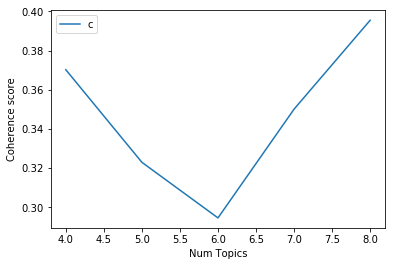

In [36]:
# display the coherence score of the different models
model_list_user_pooling = user_pooling_models[0]
coherence_values_user_pooling = user_pooling_models[1]

limit=9; start=4; step=1;
x = range(start, limit, step)
_ = plt.plot(x, coherence_values_user_pooling)
_ = plt.xlabel("Num Topics")
_ = plt.ylabel("Coherence score")
_ = plt.legend(("coherence_values"), loc='best')
_ = plt.savefig("user_pooling_coherence_scores")
_ = plt.show()

#### Choose the model with the highest coherence score (8 topics).

In [46]:
# print topics of model with highest coherence score
lda_model_user_pooling = model_list_user_pooling[4] # 8 topics model
_ = lda_model_user_pooling.print_topics()

2018-10-03 08:22:00,050 : INFO : topic #0 (0.188): 0.116*"sagrada" + 0.073*"familia" + 0.039*"basílica" + 0.035*"#sagradafamilia" + 0.032*"família" + 0.016*"#gaudi" + 0.012*"gaudi" + 0.010*"beautiful" + 0.009*"amazing" + 0.007*"place"
2018-10-03 08:22:00,053 : INFO : topic #1 (0.083): 0.086*"gothic" + 0.077*"quarter" + 0.012*"#endomondo" + 0.011*"km" + 0.011*"#endorphins" + 0.010*"dream" + 0.009*"finished" + 0.009*"time" + 0.008*"street" + 0.008*"food"
2018-10-03 08:22:00,056 : INFO : topic #2 (0.078): 0.023*"milà" + 0.020*"pedreracasa" + 0.013*"festival" + 0.013*"time" + 0.011*"sound" + 0.009*"primavera" + 0.007*"#primaverasound" + 0.007*"#amazing" + 0.006*"cool" + 0.006*"got"
2018-10-03 08:22:00,058 : INFO : topic #3 (0.061): 0.013*"best" + 0.010*"#photography" + 0.008*"e" + 0.007*"today" + 0.007*"night" + 0.006*"new" + 0.006*"road" + 0.006*"cocktail" + 0.006*"took" + 0.006*"catalunya"
2018-10-03 08:22:00,061 : INFO : topic #4 (0.070): 0.024*"#summer" + 0.011*"bcnfashion" + 0.010*"#s

### Visualize User Pooling Model

In [47]:
pyLDAvis.enable_notebook()
vis_up = pyLDAvis.gensim.prepare(lda_model_user_pooling, corpus_user_pooling, dictionary_user_pooling)

In [48]:
vis_up

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      27.249131        1       1 -0.315841  0.005699
6      12.145041        1       2  0.042036 -0.183122
1      11.151290        1       3  0.053751  0.204865
5      11.099829        1       4  0.057988 -0.036196
7      10.291304        1       5  0.050419  0.015817
2      10.097972        1       6  0.038665  0.008430
4       9.652476        1       7  0.037710  0.003240
3       8.312957        1       8  0.035272 -0.018733, topic_info=     Category         Freq             Term        Total  loglift  logprob
term                                                                      
517   Default  1121.000000          sagrada  1121.000000  30.0000  30.0000
1138  Default   709.000000          familia   709.000000  29.0000  29.0000
180   Default   341.000000           gothic   341.000000  28.0000  28.0000
181   Default   305.000000          quarter   305.000000  27.0000  27.0000
516   Default   376.000000         basílica   376.000000  26.0000  26.0000
1094  Default   340.000000  #sagradafamilia   340.000000  25.0000  25.0000
788   Default   313.000000          família   313.000000  24.0000  24.0000
784   Default   141.000000      barceloneta   141.000000  23.0000  23.0000
985   Default   132.000000            playa   132.000000  22.0000  22.0000
176   Default   118.000000            beach   118.000000  21.0000  21.0000
984   Default    97.000000             parc    97.000000  20.0000  20.0000
597   Default    84.000000             milà    84.000000  19.0000  19.0000
600   Default    73.000000      pedreracasa    73.000000  18.0000  18.0000
1081  Default   159.000000           #gaudi   159.000000  17.0000  17.0000
362   Default   121.000000          #summer   121.000000  16.0000  16.0000
31    Default    73.000000       #streetart    73.000000  15.0000  15.0000
460   Default   117.000000            gaudi   117.000000  14.0000  14.0000
117   Default   100.000000         drinking   100.000000  13.0000  13.0000
799   Default    61.000000           platja    61.000000  12.0000  12.0000
789   Default    51.000000          fashion    51.000000  11.0000  11.0000
1205  Default    48.000000       #endomondo    48.000000  10.0000  10.0000
1802  Default    50.000000            guell    50.000000   9.0000   9.0000
28    Default    50.000000        #graffiti    50.000000   8.0000   8.0000
1276  Default    72.000000          ramblas    72.000000   7.0000   7.0000
1210  Default    45.000000               km    45.000000   6.0000   6.0000
1206  Default    43.000000      #endorphins    43.000000   5.0000   5.0000
178   Default    60.000000         festival    60.000000   4.0000   4.0000
88    Default    47.000000   #photodrinking    47.000000   3.0000   3.0000
835   Default    41.000000            sound    41.000000   2.0000   2.0000
1207  Default    58.000000         finished    58.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
2639   Topic8    10.367697              god    12.159724   2.3279  -5.6487
2390   Topic8     9.634230           escola    11.268320   2.3307  -5.7220
2468   Topic8    11.871939        catalonia    14.868901   2.2623  -5.5132
869    Topic8    12.811580              hot    16.390302   2.2410  -5.4370
838    Topic8     9.126264             star    10.879233   2.3117  -5.7762
1000   Topic8     8.586364             join    10.441164   2.2918  -5.8372
3107   Topic8     9.651454      #lasramblas    12.370652   2.2391  -5.7203
49     Topic8    15.869466        afternoon    25.079654   2.0297  -5.2230
1006   Topic8    11.315667             town    15.856522   2.1500  -5.5612
1463   Topic8    17.412471             took    31.949637   1.8804  -5.1302
1399   Topic8    28.370644     #photography    76.725618   1.4925  -4.6420
402    Topic8    39.689338             best   140.401810   1.2239  -4.3063
407    Topic8    15.634762    cdlcbarcelon

#### The results of the user pooling model look similar to the no pooling model. However, topics are even more mixed up and less interpretable since users tend to tweet about different topics.

### Hashtag Pooling

In [10]:
# train and evaluate different hashtag pooling models by running the function
hashtag_pooling_models = compute_coherence_values(dictionary=dictionary_hashtag_pooling,
                         corpus=corpus_hashtag_pooling, texts=tokenized_documents_hashtag_pooling)

2018-10-03 07:51:45,950 : INFO : using autotuned alpha, starting with [0.25, 0.25, 0.25, 0.25]
2018-10-03 07:51:45,956 : INFO : using serial LDA version on this node
2018-10-03 07:51:45,966 : INFO : running online (multi-pass) LDA training, 4 topics, 20 passes over the supplied corpus of 6040 documents, updating model once every 2000 documents, evaluating perplexity every 2000 documents, iterating 400x with a convergence threshold of 0.001000
2018-10-03 07:51:47,964 : INFO : -9.915 per-word bound, 965.6 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:51:47,965 : INFO : PROGRESS: pass 0, at document #2000/6040
2018-10-03 07:51:49,741 : INFO : optimized alpha [0.14033265, 0.17183897, 0.15261221, 0.1678835]
2018-10-03 07:51:49,744 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:51:49,755 : INFO : topic #0 (0.140): 0.015*"#streetart" + 0.015*"#graffiti" + 0.012*"#art" + 0.011*"#arteurbano" + 0.009*"#d

2018-10-03 07:51:55,959 : INFO : topic #1 (0.128): 0.021*"#sagradafamilia" + 0.015*"#gaudi" + 0.015*"sagrada" + 0.012*"#love" + 0.011*"#travel" + 0.010*"#summer" + 0.010*"familia" + 0.008*"#architecture" + 0.008*"#art" + 0.007*"gothic"
2018-10-03 07:51:55,961 : INFO : topic #2 (0.096): 0.009*"#love" + 0.007*"#yogi" + 0.007*"#yoga" + 0.007*"#yogaeverydamnday" + 0.006*"#friends" + 0.006*"#yum" + 0.005*"#fit" + 0.005*"#workout" + 0.005*"#endomondo" + 0.005*"beautiful"
2018-10-03 07:51:55,963 : INFO : topic #3 (0.105): 0.016*"sagrada" + 0.012*"#sagradafamilia" + 0.009*"basílica" + 0.007*"#beach" + 0.007*"familia" + 0.006*"#travel" + 0.005*"#gaudi" + 0.005*"família" + 0.005*"#friends" + 0.004*"#catalonia"
2018-10-03 07:51:55,966 : INFO : topic diff=0.367621, rho=0.446322
2018-10-03 07:51:56,628 : INFO : -8.210 per-word bound, 296.2 perplexity estimate based on a held-out corpus of 2000 documents with 36428 words
2018-10-03 07:51:56,629 : INFO : PROGRESS: pass 1, at document #6000/6040
2018-

2018-10-03 07:52:00,698 : INFO : PROGRESS: pass 2, at document #6040/6040
2018-10-03 07:52:00,708 : INFO : optimized alpha [0.059848994, 0.094277166, 0.078152582, 0.074338429]
2018-10-03 07:52:00,710 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-03 07:52:00,716 : INFO : topic #0 (0.060): 0.017*"#youtube" + 0.015*"#streetart" + 0.013*"#graffiti" + 0.008*"#video" + 0.008*"nuevo" + 0.008*"#youtubers" + 0.008*"#newvideo" + 0.008*"yayyy" + 0.008*"#teaser" + 0.008*"#pllfinale"
2018-10-03 07:52:00,718 : INFO : topic #1 (0.094): 0.027*"#sagradafamilia" + 0.015*"sagrada" + 0.014*"#gaudi" + 0.013*"#travel" + 0.010*"familia" + 0.009*"#summer" + 0.008*"#love" + 0.007*"gothic" + 0.007*"call" + 0.007*"place"
2018-10-03 07:52:00,720 : INFO : topic #2 (0.078): 0.018*"#yogi" + 0.018*"#yoga" + 0.017*"#yogaeverydamnday" + 0.015*"#yum" + 0.013*"#selfie" + 0.012*"beautiful" + 0.012*"thursday" + 0.012*"throwback" + 0.012*"#yogaeverywhere" + 0.012*"#yogainspiration"
2018-1

2018-10-03 07:52:05,561 : INFO : topic #3 (0.064): 0.013*"sagrada" + 0.011*"#beach" + 0.009*"basílica" + 0.008*"#sagradafamilia" + 0.007*"#friends" + 0.006*"família" + 0.005*"#travel" + 0.005*"#summer" + 0.004*"#photography" + 0.004*"familia"
2018-10-03 07:52:05,566 : INFO : topic diff=0.300665, rho=0.353112
2018-10-03 07:52:06,248 : INFO : -8.289 per-word bound, 312.8 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:52:06,249 : INFO : PROGRESS: pass 4, at document #4000/6040
2018-10-03 07:52:06,725 : INFO : optimized alpha [0.049635198, 0.080163494, 0.05954913, 0.063430361]
2018-10-03 07:52:06,727 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:52:06,736 : INFO : topic #0 (0.050): 0.020*"#streetart" + 0.019*"#graffiti" + 0.010*"#arteurbano" + 0.008*"#digerible" + 0.007*"#art" + 0.007*"#artecallejero" + 0.006*"#streetphotography" + 0.006*"#photooftheday" + 0.006*"#youtube" + 0.006*"#artederua"
2018

2018-10-03 07:52:11,540 : INFO : topic #1 (0.073): 0.031*"#sagradafamilia" + 0.021*"sagrada" + 0.017*"#travel" + 0.016*"#gaudi" + 0.013*"familia" + 0.010*"#summer" + 0.010*"#love" + 0.008*"#architecture" + 0.007*"basílica" + 0.007*"#art"
2018-10-03 07:52:11,543 : INFO : topic #2 (0.052): 0.008*"#love" + 0.007*"#yogi" + 0.006*"#selfie" + 0.006*"#yoga" + 0.006*"#yogaeverydamnday" + 0.006*"#yum" + 0.006*"#foodie" + 0.005*"beautiful" + 0.005*"thursday" + 0.005*"#tapas"
2018-10-03 07:52:11,547 : INFO : topic #3 (0.057): 0.011*"sagrada" + 0.010*"#beach" + 0.007*"basílica" + 0.006*"#sagradafamilia" + 0.006*"#friends" + 0.006*"#summer" + 0.006*"#photography" + 0.005*"#travel" + 0.005*"família" + 0.004*"#igers"
2018-10-03 07:52:11,551 : INFO : topic diff=0.196840, rho=0.332964
2018-10-03 07:52:11,587 : INFO : -6.993 per-word bound, 127.4 perplexity estimate based on a held-out corpus of 40 documents with 417 words
2018-10-03 07:52:11,589 : INFO : PROGRESS: pass 5, at document #6040/6040
2018-10

2018-10-03 07:52:15,487 : INFO : PROGRESS: pass 7, at document #2000/6040
2018-10-03 07:52:15,887 : INFO : optimized alpha [0.037513707, 0.066666439, 0.047424112, 0.048145425]
2018-10-03 07:52:15,890 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:52:15,897 : INFO : topic #0 (0.038): 0.020*"#streetart" + 0.018*"#graffiti" + 0.010*"#youtube" + 0.010*"#arteurbano" + 0.008*"#streetphotography" + 0.008*"#digerible" + 0.007*"#artecallejero" + 0.007*"#photooftheday" + 0.007*"#art" + 0.007*"#amazing"
2018-10-03 07:52:15,898 : INFO : topic #1 (0.067): 0.030*"#sagradafamilia" + 0.021*"sagrada" + 0.016*"#gaudi" + 0.014*"#travel" + 0.012*"familia" + 0.010*"#architecture" + 0.009*"basílica" + 0.008*"#summer" + 0.008*"#love" + 0.008*"#art"
2018-10-03 07:52:15,902 : INFO : topic #2 (0.047): 0.013*"#yogi" + 0.012*"#yoga" + 0.012*"#yogaeverydamnday" + 0.011*"#yum" + 0.010*"#selfie" + 0.009*"beautiful" + 0.009*"thursday" + 0.009*"throwback" + 0.008*"#yogaeveryw

2018-10-03 07:52:20,103 : INFO : topic #3 (0.045): 0.011*"#beach" + 0.008*"#friends" + 0.006*"sagrada" + 0.005*"#summer" + 0.004*"#sagradafamilia" + 0.004*"#travel" + 0.004*"#photography" + 0.004*"beach" + 0.004*"#dj" + 0.004*"#love"
2018-10-03 07:52:20,105 : INFO : topic diff=0.162416, rho=0.288435
2018-10-03 07:52:20,716 : INFO : -8.074 per-word bound, 269.5 perplexity estimate based on a held-out corpus of 2000 documents with 36428 words
2018-10-03 07:52:20,717 : INFO : PROGRESS: pass 8, at document #6000/6040
2018-10-03 07:52:21,065 : INFO : optimized alpha [0.035153404, 0.063536316, 0.04269338, 0.046005409]
2018-10-03 07:52:21,067 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:52:21,074 : INFO : topic #0 (0.035): 0.023*"#streetart" + 0.019*"#graffiti" + 0.010*"#arteurbano" + 0.009*"#digerible" + 0.009*"#streetphotography" + 0.008*"#photooftheday" + 0.007*"#art" + 0.007*"#artecallejero" + 0.006*"#artederua" + 0.006*"urbano"
2018-10-03 07:5

2018-10-03 07:52:24,625 : INFO : topic #1 (0.060): 0.030*"#sagradafamilia" + 0.022*"sagrada" + 0.015*"#gaudi" + 0.014*"#travel" + 0.012*"familia" + 0.010*"basílica" + 0.009*"#summer" + 0.009*"#love" + 0.007*"#architecture" + 0.007*"gothic"
2018-10-03 07:52:24,628 : INFO : topic #2 (0.042): 0.016*"#yogi" + 0.016*"#yoga" + 0.016*"#yogaeverydamnday" + 0.014*"#yum" + 0.012*"#selfie" + 0.011*"beautiful" + 0.011*"thursday" + 0.011*"throwback" + 0.011*"#yogaeverywhere" + 0.011*"#yogainspiration"
2018-10-03 07:52:24,630 : INFO : topic #3 (0.041): 0.011*"#beach" + 0.009*"#friends" + 0.006*"#summer" + 0.005*"#photography" + 0.004*"sagrada" + 0.004*"city" + 0.004*"#travel" + 0.004*"#happyhalloween" + 0.004*"#circuitfestival" + 0.004*"#cruilla"
2018-10-03 07:52:24,633 : INFO : topic diff=0.177948, rho=0.277137
2018-10-03 07:52:26,063 : INFO : -8.205 per-word bound, 295.1 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:52:26,065 : INFO : PROGRESS: pas

2018-10-03 07:52:30,618 : INFO : PROGRESS: pass 11, at document #4000/6040
2018-10-03 07:52:30,981 : INFO : optimized alpha [0.030965868, 0.058092043, 0.0385601, 0.040135019]
2018-10-03 07:52:30,983 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:52:30,990 : INFO : topic #0 (0.031): 0.022*"#streetart" + 0.020*"#graffiti" + 0.010*"#arteurbano" + 0.008*"#digerible" + 0.007*"#youtube" + 0.007*"#art" + 0.007*"#streetphotography" + 0.007*"#artecallejero" + 0.007*"#photooftheday" + 0.006*"#artederua"
2018-10-03 07:52:30,993 : INFO : topic #1 (0.058): 0.028*"#sagradafamilia" + 0.023*"sagrada" + 0.017*"#gaudi" + 0.013*"#travel" + 0.013*"familia" + 0.011*"basílica" + 0.010*"#love" + 0.009*"#architecture" + 0.008*"#summer" + 0.007*"#art"
2018-10-03 07:52:30,996 : INFO : topic #2 (0.039): 0.010*"#yogi" + 0.010*"#yoga" + 0.009*"#yogaeverydamnday" + 0.009*"#love" + 0.008*"#yum" + 0.008*"#selfie" + 0.008*"beautiful" + 0.007*"thursday" + 0.007*"throwback" + 0

2018-10-03 07:52:35,106 : INFO : topic #3 (0.040): 0.011*"#beach" + 0.007*"#friends" + 0.006*"#summer" + 0.005*"#photography" + 0.004*"#travel" + 0.004*"#igers" + 0.004*"#dj" + 0.004*"#sea" + 0.004*"beach" + 0.004*"#music"
2018-10-03 07:52:35,108 : INFO : topic diff=0.121279, rho=0.249844
2018-10-03 07:52:35,141 : INFO : -6.822 per-word bound, 113.1 perplexity estimate based on a held-out corpus of 40 documents with 417 words
2018-10-03 07:52:35,143 : INFO : PROGRESS: pass 12, at document #6040/6040
2018-10-03 07:52:35,156 : INFO : optimized alpha [0.029065842, 0.055599336, 0.037763875, 0.037344616]
2018-10-03 07:52:35,158 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-03 07:52:35,166 : INFO : topic #0 (0.029): 0.019*"#streetart" + 0.016*"#graffiti" + 0.013*"#youtube" + 0.008*"#arteurbano" + 0.007*"#digerible" + 0.007*"#streetphotography" + 0.007*"#video" + 0.007*"nuevo" + 0.007*"#photooftheday" + 0.007*"#youtubers"
2018-10-03 07:52:35,168 : INFO : to

2018-10-03 07:52:38,975 : INFO : topic #1 (0.055): 0.031*"#sagradafamilia" + 0.024*"sagrada" + 0.016*"#gaudi" + 0.014*"#travel" + 0.013*"familia" + 0.011*"basílica" + 0.010*"#architecture" + 0.008*"#love" + 0.008*"#summer" + 0.007*"#art"
2018-10-03 07:52:38,979 : INFO : topic #2 (0.036): 0.013*"#yogi" + 0.012*"#yoga" + 0.012*"#yogaeverydamnday" + 0.011*"#yum" + 0.010*"#selfie" + 0.009*"beautiful" + 0.009*"thursday" + 0.009*"throwback" + 0.008*"#love" + 0.008*"#yogainspiration"
2018-10-03 07:52:38,981 : INFO : topic #3 (0.037): 0.012*"#beach" + 0.008*"#friends" + 0.006*"#summer" + 0.004*"beach" + 0.004*"#photography" + 0.004*"#travel" + 0.004*"#music" + 0.004*"city" + 0.003*"#playa" + 0.003*"#sea"
2018-10-03 07:52:38,983 : INFO : topic diff=0.140820, rho=0.235571
2018-10-03 07:52:39,572 : INFO : -8.187 per-word bound, 291.5 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:52:39,573 : INFO : PROGRESS: pass 14, at document #4000/6040
2018-10-

2018-10-03 07:52:43,730 : INFO : PROGRESS: pass 15, at document #6000/6040
2018-10-03 07:52:44,058 : INFO : optimized alpha [0.027699947, 0.05391477, 0.034374543, 0.036928859]
2018-10-03 07:52:44,060 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:52:44,068 : INFO : topic #0 (0.028): 0.023*"#streetart" + 0.020*"#graffiti" + 0.010*"#arteurbano" + 0.009*"#digerible" + 0.008*"#streetphotography" + 0.008*"#photooftheday" + 0.007*"#art" + 0.007*"#artecallejero" + 0.006*"#artederua" + 0.006*"urbano"
2018-10-03 07:52:44,070 : INFO : topic #1 (0.054): 0.032*"#sagradafamilia" + 0.025*"sagrada" + 0.017*"#gaudi" + 0.016*"#travel" + 0.014*"familia" + 0.011*"basílica" + 0.010*"#love" + 0.010*"#summer" + 0.009*"#architecture" + 0.007*"#art"
2018-10-03 07:52:44,072 : INFO : topic #2 (0.034): 0.009*"#yogi" + 0.008*"#love" + 0.008*"#yoga" + 0.008*"#yogaeverydamnday" + 0.007*"#selfie" + 0.007*"#yum" + 0.007*"beautiful" + 0.006*"#foodie" + 0.006*"thursday" + 0.00

2018-10-03 07:52:46,940 : INFO : topic #3 (0.035): 0.012*"#beach" + 0.007*"#friends" + 0.006*"#summer" + 0.005*"#photography" + 0.004*"city" + 0.004*"#travel" + 0.004*"#happyhalloween" + 0.004*"#igers" + 0.004*"#circuitfestival" + 0.004*"#cruilla"
2018-10-03 07:52:46,943 : INFO : topic diff=0.147608, rho=0.223495
2018-10-03 07:52:47,583 : INFO : -8.158 per-word bound, 285.7 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:52:47,584 : INFO : PROGRESS: pass 17, at document #2000/6040
2018-10-03 07:52:47,920 : INFO : optimized alpha [0.026380165, 0.05210809, 0.034001511, 0.034893692]
2018-10-03 07:52:47,923 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:52:47,931 : INFO : topic #0 (0.026): 0.022*"#streetart" + 0.019*"#graffiti" + 0.010*"#youtube" + 0.010*"#arteurbano" + 0.008*"#digerible" + 0.008*"#streetphotography" + 0.007*"#photooftheday" + 0.007*"#artecallejero" + 0.007*"#art" + 0.007*"#amazing"


2018-10-03 07:52:51,724 : INFO : topic #1 (0.052): 0.029*"#sagradafamilia" + 0.024*"sagrada" + 0.017*"#gaudi" + 0.014*"#travel" + 0.014*"familia" + 0.011*"basílica" + 0.010*"#love" + 0.009*"#architecture" + 0.008*"#summer" + 0.007*"#art"
2018-10-03 07:52:51,726 : INFO : topic #2 (0.033): 0.010*"#yogi" + 0.010*"#yoga" + 0.010*"#yogaeverydamnday" + 0.009*"#yum" + 0.009*"#love" + 0.008*"#selfie" + 0.008*"beautiful" + 0.007*"thursday" + 0.007*"throwback" + 0.007*"#foodie"
2018-10-03 07:52:51,729 : INFO : topic #3 (0.035): 0.011*"#beach" + 0.007*"#friends" + 0.006*"#summer" + 0.004*"beach" + 0.004*"#photography" + 0.004*"#igers" + 0.004*"#travel" + 0.004*"#dj" + 0.004*"#music" + 0.003*"#love"
2018-10-03 07:52:51,731 : INFO : topic diff=0.095310, rho=0.213104
2018-10-03 07:52:52,295 : INFO : -8.046 per-word bound, 264.3 perplexity estimate based on a held-out corpus of 2000 documents with 36428 words
2018-10-03 07:52:52,296 : INFO : PROGRESS: pass 18, at document #6000/6040
2018-10-03 07:52:

2018-10-03 07:52:55,617 : INFO : PROGRESS: pass 19, at document #6040/6040
2018-10-03 07:52:55,624 : INFO : optimized alpha [0.025311273, 0.050328996, 0.033091627, 0.033202089]
2018-10-03 07:52:55,627 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-03 07:52:55,635 : INFO : topic #0 (0.025): 0.020*"#streetart" + 0.017*"#graffiti" + 0.013*"#youtube" + 0.009*"#arteurbano" + 0.007*"#digerible" + 0.007*"#streetphotography" + 0.007*"#photooftheday" + 0.006*"#video" + 0.006*"nuevo" + 0.006*"#teaser"
2018-10-03 07:52:55,637 : INFO : topic #1 (0.050): 0.031*"#sagradafamilia" + 0.024*"sagrada" + 0.016*"#gaudi" + 0.015*"#travel" + 0.013*"familia" + 0.011*"basílica" + 0.009*"#love" + 0.008*"#summer" + 0.008*"#architecture" + 0.007*"gothic"
2018-10-03 07:52:55,639 : INFO : topic #2 (0.033): 0.015*"#yogi" + 0.014*"#yoga" + 0.014*"#yogaeverydamnday" + 0.012*"#yum" + 0.011*"#selfie" + 0.010*"beautiful" + 0.010*"thursday" + 0.010*"throwback" + 0.010*"#yogainspiration" 

2018-10-03 07:53:06,141 : INFO : topic #0 (0.125): 0.018*"#gaudi" + 0.014*"sagrada" + 0.013*"#sagradafamilia" + 0.011*"#friends" + 0.009*"#travel" + 0.009*"#architecture" + 0.008*"familia" + 0.008*"#love" + 0.007*"#summer" + 0.006*"gothic"
2018-10-03 07:53:06,143 : INFO : topic #1 (0.121): 0.014*"sagrada" + 0.011*"#sagradafamilia" + 0.010*"#catalonia" + 0.009*"#love" + 0.009*"familia" + 0.008*"#catalunya" + 0.006*"basílica" + 0.006*"#gato" + 0.006*"#streetart" + 0.005*"#summer"
2018-10-03 07:53:06,146 : INFO : topic #2 (0.121): 0.018*"#sagradafamilia" + 0.010*"sagrada" + 0.008*"#gaudi" + 0.007*"#streetart" + 0.007*"#photooftheday" + 0.007*"#travel" + 0.007*"#digerible" + 0.006*"#instagood" + 0.006*"#arteurbano" + 0.006*"#summer"
2018-10-03 07:53:06,149 : INFO : topic #3 (0.114): 0.014*"#love" + 0.007*"sagrada" + 0.005*"#travel" + 0.005*"gothic" + 0.004*"#sun" + 0.004*"#fun" + 0.004*"quarter" + 0.004*"familia" + 0.004*"#fashion" + 0.004*"#art"
2018-10-03 07:53:06,151 : INFO : topic #4 (

2018-10-03 07:53:10,500 : INFO : PROGRESS: pass 1, at document #6000/6040
2018-10-03 07:53:10,902 : INFO : optimized alpha [0.098933846, 0.089684442, 0.090470165, 0.088853523, 0.082940049]
2018-10-03 07:53:10,904 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:53:10,912 : INFO : topic #0 (0.099): 0.027*"#sagradafamilia" + 0.020*"sagrada" + 0.019*"#travel" + 0.016*"#gaudi" + 0.012*"familia" + 0.012*"#summer" + 0.009*"#architecture" + 0.009*"#friends" + 0.008*"#photography" + 0.008*"basílica"
2018-10-03 07:53:10,914 : INFO : topic #1 (0.090): 0.015*"sagrada" + 0.012*"#sagradafamilia" + 0.010*"#catalonia" + 0.008*"#catalunya" + 0.007*"#love" + 0.007*"basílica" + 0.007*"familia" + 0.005*"#summer" + 0.005*"#gato" + 0.004*"#gaudi"
2018-10-03 07:53:10,917 : INFO : topic #2 (0.090): 0.018*"#sagradafamilia" + 0.012*"#streetart" + 0.010*"#photooftheday" + 0.009*"sagrada" + 0.008*"#photography" + 0.008*"#arteurbano" + 0.007*"#travel" + 0.007*"#amazing" + 

2018-10-03 07:53:14,541 : INFO : topic diff=0.286771, rho=0.407570
2018-10-03 07:53:14,581 : INFO : -7.405 per-word bound, 169.4 perplexity estimate based on a held-out corpus of 40 documents with 417 words
2018-10-03 07:53:14,583 : INFO : PROGRESS: pass 2, at document #6040/6040
2018-10-03 07:53:14,596 : INFO : optimized alpha [0.080411419, 0.074065231, 0.073040828, 0.079440221, 0.064885631]
2018-10-03 07:53:14,598 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-03 07:53:14,607 : INFO : topic #0 (0.080): 0.025*"#sagradafamilia" + 0.018*"sagrada" + 0.016*"#travel" + 0.013*"#gaudi" + 0.011*"familia" + 0.011*"#friends" + 0.010*"#summer" + 0.009*"time" + 0.009*"#beach" + 0.008*"#yum"
2018-10-03 07:53:14,610 : INFO : topic #1 (0.074): 0.016*"#yogainspiration" + 0.016*"#yogaeverywhere" + 0.014*"throwback" + 0.013*"sagrada" + 0.012*"#selfie" + 0.012*"#catalonia" + 0.011*"#sagradafamilia" + 0.010*"nearly" + 0.009*"#yummy" + 0.009*"#ølgod"
2018-10-03 07:53:14,

2018-10-03 07:53:17,763 : INFO : topic #4 (0.056): 0.012*"#art" + 0.009*"#graffiti" + 0.007*"art" + 0.007*"#sagradafamilia" + 0.007*"#cruilla" + 0.007*"#contemporaryart" + 0.006*"#streetart" + 0.006*"#streetphotography" + 0.006*"fashion" + 0.005*"lec"
2018-10-03 07:53:17,765 : INFO : topic diff=0.232638, rho=0.377426
2018-10-03 07:53:18,424 : INFO : -8.279 per-word bound, 310.7 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:53:18,426 : INFO : PROGRESS: pass 4, at document #2000/6040
2018-10-03 07:53:18,881 : INFO : optimized alpha [0.074465446, 0.064833634, 0.063050374, 0.06628567, 0.05431138]
2018-10-03 07:53:18,884 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:53:18,892 : INFO : topic #0 (0.074): 0.027*"#sagradafamilia" + 0.022*"sagrada" + 0.016*"#travel" + 0.015*"#gaudi" + 0.013*"familia" + 0.011*"#architecture" + 0.010*"#summer" + 0.009*"#friends" + 0.009*"#beach" + 0.009*"basílica"
2018-10

2018-10-03 07:53:21,999 : INFO : topic #3 (0.061): 0.016*"#yogi" + 0.015*"#yoga" + 0.015*"#yogaeverydamnday" + 0.012*"thursday" + 0.011*"#love" + 0.011*"#youtube" + 0.010*"#selfie" + 0.009*"throwback" + 0.009*"#yogaeverywhere" + 0.009*"#yogainspiration"
2018-10-03 07:53:22,002 : INFO : topic #4 (0.049): 0.018*"#art" + 0.011*"#graffiti" + 0.008*"#streetart" + 0.008*"#artecallejero" + 0.008*"#streetphotography" + 0.007*"#artederua" + 0.006*"gothic" + 0.006*"art" + 0.006*"quarter" + 0.006*"#drawing"
2018-10-03 07:53:22,005 : INFO : topic diff=0.284218, rho=0.332964
2018-10-03 07:53:22,638 : INFO : -8.233 per-word bound, 300.8 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:53:22,640 : INFO : PROGRESS: pass 5, at document #4000/6040
2018-10-03 07:53:22,982 : INFO : optimized alpha [0.070500471, 0.05586211, 0.056466725, 0.059845269, 0.048818335]
2018-10-03 07:53:22,984 : INFO : merging changes from 2000 documents into a model of 6040 documents

2018-10-03 07:53:26,009 : INFO : topic #2 (0.052): 0.013*"#streetart" + 0.010*"#photooftheday" + 0.009*"#arteurbano" + 0.008*"#digerible" + 0.007*"#amazing" + 0.007*"#graffiti" + 0.007*"home" + 0.007*"#instagood" + 0.006*"#sagradafamilia" + 0.006*"#smile"
2018-10-03 07:53:26,011 : INFO : topic #3 (0.056): 0.012*"#love" + 0.011*"#yogi" + 0.011*"#yoga" + 0.011*"#yogaeverydamnday" + 0.008*"thursday" + 0.008*"#selfie" + 0.008*"#youtube" + 0.007*"throwback" + 0.007*"#yogainspiration" + 0.007*"#yogaeverywhere"
2018-10-03 07:53:26,014 : INFO : topic #4 (0.045): 0.018*"#art" + 0.013*"#graffiti" + 0.008*"#streetart" + 0.007*"#artecallejero" + 0.007*"#artederua" + 0.007*"#drawing" + 0.007*"gothic" + 0.006*"quarter" + 0.006*"#streetphotography" + 0.006*"#illustration"
2018-10-03 07:53:26,016 : INFO : topic diff=0.201381, rho=0.315912
2018-10-03 07:53:26,612 : INFO : -8.075 per-word bound, 269.7 perplexity estimate based on a held-out corpus of 2000 documents with 36428 words
2018-10-03 07:53:26,6

2018-10-03 07:53:30,177 : INFO : topic #1 (0.048): 0.013*"#catalonia" + 0.010*"#catalunya" + 0.006*"#love" + 0.006*"#gato" + 0.006*"#sagradafamilia" + 0.005*"#catwalk" + 0.004*"sagrada" + 0.004*"night" + 0.004*"#summer" + 0.004*"nearly"
2018-10-03 07:53:30,179 : INFO : topic #2 (0.049): 0.015*"#streetart" + 0.011*"#photooftheday" + 0.010*"#arteurbano" + 0.008*"#digerible" + 0.008*"#amazing" + 0.007*"#graffiti" + 0.007*"#smile" + 0.006*"#sagradafamilia" + 0.006*"urbano" + 0.006*"arte"
2018-10-03 07:53:30,182 : INFO : topic #3 (0.052): 0.011*"#love" + 0.009*"#yogi" + 0.008*"#yoga" + 0.008*"#yogaeverydamnday" + 0.007*"#selfie" + 0.007*"thursday" + 0.006*"#youtube" + 0.006*"throwback" + 0.005*"#yogaeverywhere" + 0.005*"#yogainspiration"
2018-10-03 07:53:30,184 : INFO : topic #4 (0.042): 0.017*"#art" + 0.012*"#graffiti" + 0.008*"#streetart" + 0.008*"#streetphotography" + 0.007*"#artecallejero" + 0.007*"#artederua" + 0.007*"gothic" + 0.007*"quarter" + 0.006*"#drawing" + 0.005*"#travelblogger

2018-10-03 07:53:33,192 : INFO : optimized alpha [0.061147727, 0.043614112, 0.045344416, 0.051825784, 0.039117854]
2018-10-03 07:53:33,195 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-03 07:53:33,203 : INFO : topic #0 (0.061): 0.029*"#sagradafamilia" + 0.026*"sagrada" + 0.018*"#travel" + 0.015*"#gaudi" + 0.014*"familia" + 0.012*"basílica" + 0.011*"#summer" + 0.010*"#friends" + 0.008*"#beach" + 0.008*"#architecture"
2018-10-03 07:53:33,205 : INFO : topic #1 (0.044): 0.014*"#catalonia" + 0.010*"nearly" + 0.009*"#yummy" + 0.009*"#ølgod" + 0.008*"#catalunya" + 0.008*"#sagradafamilia" + 0.007*"night" + 0.006*"#gaudi" + 0.006*"#delicious" + 0.005*"beer"
2018-10-03 07:53:33,208 : INFO : topic #2 (0.045): 0.015*"#yum" + 0.012*"#streetart" + 0.012*"home" + 0.012*"place" + 0.011*"call" + 0.010*"yoga" + 0.010*"#yogabarcelona" + 0.010*"#yogadiary" + 0.010*"inner" + 0.010*"#yogagirl"
2018-10-03 07:53:33,210 : INFO : topic #3 (0.052): 0.018*"#yogi" + 0.018*"#yoga

2018-10-03 07:53:36,130 : INFO : topic diff=0.164449, rho=0.277137
2018-10-03 07:53:36,720 : INFO : -8.150 per-word bound, 284.1 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:53:36,721 : INFO : PROGRESS: pass 10, at document #2000/6040
2018-10-03 07:53:37,076 : INFO : optimized alpha [0.061324384, 0.04198841, 0.043121811, 0.047931917, 0.037205845]
2018-10-03 07:53:37,078 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:53:37,087 : INFO : topic #0 (0.061): 0.029*"#sagradafamilia" + 0.027*"sagrada" + 0.017*"#travel" + 0.016*"#gaudi" + 0.015*"familia" + 0.012*"basílica" + 0.011*"#architecture" + 0.010*"#summer" + 0.009*"#beach" + 0.009*"#friends"
2018-10-03 07:53:37,089 : INFO : topic #1 (0.042): 0.016*"#catalonia" + 0.011*"#catalunya" + 0.007*"nearly" + 0.006*"#sagradafamilia" + 0.006*"#sport" + 0.006*"#yummy" + 0.006*"#ølgod" + 0.006*"#women" + 0.006*"night" + 0.005*"#catwalk"
2018-10-03 07:53:37,

2018-10-03 07:53:39,967 : INFO : topic #4 (0.036): 0.019*"#art" + 0.012*"#graffiti" + 0.009*"#streetart" + 0.008*"#streetphotography" + 0.008*"#artecallejero" + 0.008*"#artederua" + 0.006*"gothic" + 0.006*"quarter" + 0.006*"art" + 0.006*"#drawing"
2018-10-03 07:53:39,969 : INFO : topic diff=0.180684, rho=0.258027
2018-10-03 07:53:40,531 : INFO : -8.165 per-word bound, 287.0 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:53:40,532 : INFO : PROGRESS: pass 11, at document #4000/6040
2018-10-03 07:53:40,848 : INFO : optimized alpha [0.060526714, 0.040301185, 0.041479331, 0.045951452, 0.03624336]
2018-10-03 07:53:40,851 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:53:40,858 : INFO : topic #0 (0.061): 0.027*"#sagradafamilia" + 0.027*"sagrada" + 0.018*"#gaudi" + 0.016*"#travel" + 0.015*"familia" + 0.012*"basílica" + 0.010*"#summer" + 0.010*"#architecture" + 0.010*"#friends" + 0.009*"#love"
2018-10-03

2018-10-03 07:53:43,744 : INFO : topic #3 (0.045): 0.012*"#yogi" + 0.012*"#yoga" + 0.012*"#yogaeverydamnday" + 0.011*"#love" + 0.009*"thursday" + 0.009*"#selfie" + 0.008*"#youtube" + 0.008*"throwback" + 0.008*"#yogaeverywhere" + 0.008*"#yogainspiration"
2018-10-03 07:53:43,746 : INFO : topic #4 (0.035): 0.019*"#art" + 0.013*"#graffiti" + 0.009*"#streetart" + 0.007*"#artecallejero" + 0.007*"#artederua" + 0.007*"#streetphotography" + 0.007*"gothic" + 0.007*"#drawing" + 0.007*"quarter" + 0.006*"#cruilla"
2018-10-03 07:53:43,749 : INFO : topic diff=0.122051, rho=0.249844
2018-10-03 07:53:44,298 : INFO : -8.045 per-word bound, 264.1 perplexity estimate based on a held-out corpus of 2000 documents with 36428 words
2018-10-03 07:53:44,299 : INFO : PROGRESS: pass 12, at document #6000/6040
2018-10-03 07:53:44,611 : INFO : optimized alpha [0.060214017, 0.039234433, 0.040180758, 0.044412788, 0.035416223]
2018-10-03 07:53:44,613 : INFO : merging changes from 2000 documents into a model of 6040 do

2018-10-03 07:53:47,903 : INFO : topic #2 (0.039): 0.015*"#streetart" + 0.011*"#photooftheday" + 0.010*"#arteurbano" + 0.009*"#digerible" + 0.008*"#amazing" + 0.008*"#graffiti" + 0.007*"#smile" + 0.007*"#yum" + 0.007*"home" + 0.006*"urbano"
2018-10-03 07:53:47,906 : INFO : topic #3 (0.043): 0.010*"#love" + 0.010*"#yogi" + 0.009*"#yoga" + 0.009*"#yogaeverydamnday" + 0.008*"#selfie" + 0.008*"thursday" + 0.007*"#youtube" + 0.007*"throwback" + 0.006*"#yogaeverywhere" + 0.006*"#yogainspiration"
2018-10-03 07:53:47,909 : INFO : topic #4 (0.035): 0.018*"#art" + 0.012*"#graffiti" + 0.009*"#streetart" + 0.008*"#streetphotography" + 0.007*"#artecallejero" + 0.007*"#artederua" + 0.007*"gothic" + 0.007*"quarter" + 0.006*"#drawing" + 0.005*"#cruilla"
2018-10-03 07:53:47,910 : INFO : topic diff=0.107279, rho=0.242393
2018-10-03 07:53:47,945 : INFO : -6.796 per-word bound, 111.2 perplexity estimate based on a held-out corpus of 40 documents with 417 words
2018-10-03 07:53:47,947 : INFO : PROGRESS: pa

2018-10-03 07:53:50,830 : INFO : topic #1 (0.037): 0.014*"#catalonia" + 0.009*"nearly" + 0.009*"#yummy" + 0.008*"#ølgod" + 0.008*"#catalunya" + 0.007*"#sagradafamilia" + 0.007*"night" + 0.006*"#delicious" + 0.005*"#gato" + 0.005*"#love"
2018-10-03 07:53:50,832 : INFO : topic #2 (0.038): 0.016*"#yum" + 0.012*"#streetart" + 0.012*"home" + 0.011*"place" + 0.010*"call" + 0.010*"yoga" + 0.010*"#yogadiary" + 0.010*"#yogabarcelona" + 0.010*"inner" + 0.010*"#yogagirl"
2018-10-03 07:53:50,836 : INFO : topic #3 (0.044): 0.017*"#yogi" + 0.017*"#yoga" + 0.017*"#yogaeverydamnday" + 0.013*"#selfie" + 0.012*"thursday" + 0.012*"#youtube" + 0.012*"throwback" + 0.011*"#yogaeverywhere" + 0.011*"#yogainspiration" + 0.010*"#love"
2018-10-03 07:53:50,838 : INFO : topic #4 (0.033): 0.016*"#art" + 0.011*"#graffiti" + 0.008*"#streetart" + 0.007*"#streetphotography" + 0.007*"#cruilla" + 0.007*"art" + 0.006*"#artecallejero" + 0.006*"gothic" + 0.006*"#artederua" + 0.006*"quarter"
2018-10-03 07:53:50,845 : INFO : 

2018-10-03 07:53:54,585 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:53:54,594 : INFO : topic #0 (0.056): 0.030*"#sagradafamilia" + 0.028*"sagrada" + 0.017*"#travel" + 0.016*"#gaudi" + 0.015*"familia" + 0.013*"basílica" + 0.011*"#summer" + 0.011*"#architecture" + 0.009*"#beach" + 0.009*"#friends"
2018-10-03 07:53:54,597 : INFO : topic #1 (0.036): 0.016*"#catalonia" + 0.011*"#catalunya" + 0.007*"nearly" + 0.006*"#yummy" + 0.006*"#sport" + 0.006*"#ølgod" + 0.006*"#sagradafamilia" + 0.006*"night" + 0.006*"#catwalk" + 0.005*"#gato"
2018-10-03 07:53:54,599 : INFO : topic #2 (0.037): 0.013*"#streetart" + 0.012*"#yum" + 0.010*"#photooftheday" + 0.010*"home" + 0.009*"#arteurbano" + 0.009*"place" + 0.008*"#amazing" + 0.008*"#digerible" + 0.008*"call" + 0.007*"yoga"
2018-10-03 07:53:54,602 : INFO : topic #3 (0.041): 0.015*"#yogi" + 0.015*"#yoga" + 0.015*"#yogaeverydamnday" + 0.011*"thursday" + 0.011*"#selfie" + 0.011*"#youtube" + 0.010*"throwback" + 0

2018-10-03 07:53:58,037 : INFO : -8.140 per-word bound, 282.0 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:53:58,038 : INFO : PROGRESS: pass 17, at document #4000/6040
2018-10-03 07:53:58,357 : INFO : optimized alpha [0.055714544, 0.035574589, 0.036767166, 0.04078139, 0.03223139]
2018-10-03 07:53:58,358 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:53:58,366 : INFO : topic #0 (0.056): 0.028*"#sagradafamilia" + 0.028*"sagrada" + 0.017*"#gaudi" + 0.017*"#travel" + 0.015*"familia" + 0.012*"basílica" + 0.011*"#summer" + 0.010*"#architecture" + 0.009*"#friends" + 0.009*"#love"
2018-10-03 07:53:58,368 : INFO : topic #1 (0.036): 0.014*"#catalonia" + 0.010*"#catalunya" + 0.007*"#gato" + 0.006*"#love" + 0.006*"#catwalk" + 0.006*"nearly" + 0.005*"#yummy" + 0.005*"night" + 0.005*"#sagradafamilia" + 0.005*"#sport"
2018-10-03 07:53:58,370 : INFO : topic #2 (0.037): 0.014*"#streetart" + 0.010*"#arteurbano"

2018-10-03 07:54:01,372 : INFO : topic #4 (0.032): 0.019*"#art" + 0.013*"#graffiti" + 0.009*"#streetart" + 0.008*"#artecallejero" + 0.007*"#streetphotography" + 0.007*"#artederua" + 0.007*"gothic" + 0.007*"quarter" + 0.007*"#drawing" + 0.007*"#cruilla"
2018-10-03 07:54:01,374 : INFO : topic diff=0.087756, rho=0.213104
2018-10-03 07:54:02,028 : INFO : -8.035 per-word bound, 262.3 perplexity estimate based on a held-out corpus of 2000 documents with 36428 words
2018-10-03 07:54:02,029 : INFO : PROGRESS: pass 18, at document #6000/6040
2018-10-03 07:54:02,337 : INFO : optimized alpha [0.055859536, 0.035249643, 0.03631844, 0.040149774, 0.031989843]
2018-10-03 07:54:02,339 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:54:02,347 : INFO : topic #0 (0.056): 0.032*"#sagradafamilia" + 0.028*"sagrada" + 0.020*"#travel" + 0.017*"#gaudi" + 0.016*"familia" + 0.012*"basílica" + 0.012*"#summer" + 0.009*"#architecture" + 0.008*"#friends" + 0.008*"#love"
2018-

2018-10-03 07:54:05,246 : INFO : topic #3 (0.040): 0.010*"#yogi" + 0.010*"#love" + 0.010*"#yoga" + 0.010*"#yogaeverydamnday" + 0.008*"#selfie" + 0.008*"thursday" + 0.007*"#youtube" + 0.007*"throwback" + 0.007*"#yogaeverywhere" + 0.007*"#yogainspiration"
2018-10-03 07:54:05,248 : INFO : topic #4 (0.032): 0.018*"#art" + 0.013*"#graffiti" + 0.009*"#streetart" + 0.008*"#streetphotography" + 0.007*"#artecallejero" + 0.007*"gothic" + 0.007*"#artederua" + 0.007*"quarter" + 0.006*"#drawing" + 0.006*"#cruilla"
2018-10-03 07:54:05,251 : INFO : topic diff=0.081071, rho=0.208424
2018-10-03 07:54:05,282 : INFO : -6.725 per-word bound, 105.8 perplexity estimate based on a held-out corpus of 40 documents with 417 words
2018-10-03 07:54:05,283 : INFO : PROGRESS: pass 19, at document #6040/6040
2018-10-03 07:54:05,299 : INFO : optimized alpha [0.052880857, 0.034195237, 0.035629723, 0.040567476, 0.031043949]
2018-10-03 07:54:05,301 : INFO : merging changes from 40 documents into a model of 6040 document

2018-10-03 07:54:14,019 : INFO : topic #2 (0.118): 0.012*"#gaudi" + 0.011*"#amazing" + 0.009*"#photooftheday" + 0.009*"sagrada" + 0.009*"#catalonia" + 0.008*"#sagradafamilia" + 0.008*"#travel" + 0.007*"#vegan" + 0.007*"#minimalism" + 0.007*"#planner"
2018-10-03 07:54:14,021 : INFO : topic #3 (0.123): 0.012*"#sagradafamilia" + 0.012*"#beach" + 0.012*"sagrada" + 0.011*"#streetart" + 0.009*"#arteurbano" + 0.008*"#sport" + 0.008*"#summer" + 0.008*"#digerible" + 0.007*"#graffiti" + 0.007*"#women"
2018-10-03 07:54:14,024 : INFO : topic #5 (0.127): 0.025*"#sagradafamilia" + 0.019*"sagrada" + 0.013*"#architecture" + 0.011*"familia" + 0.010*"#gaudi" + 0.009*"#art" + 0.009*"#travel" + 0.008*"basílica" + 0.006*"#friends" + 0.005*"#catalonia"
2018-10-03 07:54:14,026 : INFO : topic diff=4.435725, rho=1.000000
2018-10-03 07:54:14,910 : INFO : -9.806 per-word bound, 895.4 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:54:14,911 : INFO : PROGRESS: pass 

2018-10-03 07:54:19,529 : INFO : topic #0 (0.081): 0.013*"#yogi" + 0.011*"#yoga" + 0.011*"#love" + 0.008*"thursday" + 0.006*"#drawing" + 0.006*"sagrada" + 0.005*"#illustration" + 0.005*"#art" + 0.005*"#artist" + 0.004*"#artwork"
2018-10-03 07:54:19,532 : INFO : topic #2 (0.085): 0.011*"#photooftheday" + 0.010*"#yogaeverydamnday" + 0.009*"#love" + 0.008*"#amazing" + 0.008*"#smile" + 0.007*"#gato" + 0.007*"#art" + 0.006*"#follow" + 0.006*"#vegan" + 0.006*"#catwalk"
2018-10-03 07:54:19,535 : INFO : topic #3 (0.088): 0.016*"#streetart" + 0.014*"#beach" + 0.013*"#graffiti" + 0.011*"#arteurbano" + 0.010*"#summer" + 0.010*"#digerible" + 0.009*"#love" + 0.009*"#friends" + 0.008*"gothic" + 0.007*"#instagood"
2018-10-03 07:54:19,538 : INFO : topic #5 (0.143): 0.025*"#sagradafamilia" + 0.021*"sagrada" + 0.016*"#gaudi" + 0.012*"familia" + 0.011*"#travel" + 0.010*"basílica" + 0.008*"#architecture" + 0.007*"#summer" + 0.007*"#love" + 0.006*"#friends"
2018-10-03 07:54:19,540 : INFO : topic diff=0.352

2018-10-03 07:54:23,669 : INFO : optimized alpha [0.067816205, 0.065030269, 0.069917269, 0.074445166, 0.06813021, 0.13438287]
2018-10-03 07:54:23,672 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:54:23,682 : INFO : topic #1 (0.065): 0.010*"#selfie" + 0.009*"#friends" + 0.007*"#dj" + 0.007*"#party" + 0.007*"night" + 0.006*"#summer" + 0.006*"#food" + 0.006*"#yogaeverywhere" + 0.006*"#yogainspiration" + 0.005*"#happy"
2018-10-03 07:54:23,684 : INFO : topic #0 (0.068): 0.011*"#love" + 0.008*"#yogi" + 0.008*"#yoga" + 0.007*"thursday" + 0.006*"#travelblogger" + 0.006*"#art" + 0.005*"#drawing" + 0.005*"#smodatamentegoestobarcelona" + 0.005*"#smodatamentetravel" + 0.005*"#smodatamentegoestospain"
2018-10-03 07:54:23,687 : INFO : topic #2 (0.070): 0.016*"#photooftheday" + 0.010*"#love" + 0.010*"#smile" + 0.010*"#amazing" + 0.008*"#vegan" + 0.007*"#yogaeverydamnday" + 0.007*"#elhartazgodeunpaís" + 0.007*"#planner" + 0.007*"#minimalism" + 0.007*"#art"
2

2018-10-03 07:54:27,758 : INFO : topic #5 (0.121): 0.032*"#sagradafamilia" + 0.025*"sagrada" + 0.017*"#travel" + 0.015*"#gaudi" + 0.014*"familia" + 0.011*"basílica" + 0.010*"#photography" + 0.008*"#summer" + 0.008*"#architecture" + 0.006*"#europe"
2018-10-03 07:54:27,760 : INFO : topic diff=0.254196, rho=0.377426
2018-10-03 07:54:27,806 : INFO : -7.304 per-word bound, 158.0 perplexity estimate based on a held-out corpus of 40 documents with 417 words
2018-10-03 07:54:27,807 : INFO : PROGRESS: pass 3, at document #6040/6040
2018-10-03 07:54:27,821 : INFO : optimized alpha [0.060805038, 0.058229372, 0.065150432, 0.065580495, 0.0583754, 0.10748816]
2018-10-03 07:54:27,824 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-03 07:54:27,833 : INFO : topic #1 (0.058): 0.024*"#yogaeverywhere" + 0.024*"#yogainspiration" + 0.023*"#selfie" + 0.016*"#friends" + 0.013*"#yummy" + 0.012*"throwback" + 0.011*"night" + 0.009*"#food" + 0.009*"#happy" + 0.008*"#igersbarcelon

2018-10-03 07:54:31,456 : INFO : topic #2 (0.059): 0.018*"#yum" + 0.010*"#meditation" + 0.010*"#love" + 0.010*"#healthy" + 0.009*"anyone#fitness" + 0.009*"beautiful" + 0.008*"#photooftheday" + 0.008*"#fitness" + 0.008*"want" + 0.008*"#yogalove"
2018-10-03 07:54:31,459 : INFO : topic #3 (0.060): 0.017*"place" + 0.015*"#streetart" + 0.015*"home" + 0.014*"call" + 0.014*"#graffiti" + 0.014*"yoga" + 0.014*"inner" + 0.014*"#yogabarcelona" + 0.014*"#yogadiary" + 0.014*"#yogagirl"
2018-10-03 07:54:31,462 : INFO : topic #5 (0.099): 0.030*"#sagradafamilia" + 0.024*"sagrada" + 0.015*"#travel" + 0.013*"#gaudi" + 0.013*"familia" + 0.011*"basílica" + 0.009*"#summer" + 0.008*"#photography" + 0.008*"#youtube" + 0.007*"#architecture"
2018-10-03 07:54:31,464 : INFO : topic diff=0.206707, rho=0.353112
2018-10-03 07:54:32,244 : INFO : -8.206 per-word bound, 295.3 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:54:32,245 : INFO : PROGRESS: pass 5, at document

2018-10-03 07:54:35,991 : INFO : topic #4 (0.049): 0.014*"#graffiti" + 0.013*"#streetphotography" + 0.011*"#artecallejero" + 0.011*"#streetart" + 0.010*"#artederua" + 0.009*"#art" + 0.009*"#igeurope" + 0.008*"#brianeno" + 0.007*"art" + 0.007*"#contemporaryart"
2018-10-03 07:54:35,993 : INFO : topic #1 (0.049): 0.016*"#yogainspiration" + 0.016*"#yogaeverywhere" + 0.015*"#selfie" + 0.013*"#friends" + 0.009*"#yummy" + 0.008*"night" + 0.007*"#food" + 0.007*"arena" + 0.007*"see" + 0.007*"#foodporn"
2018-10-03 07:54:35,996 : INFO : topic #2 (0.053): 0.013*"#yum" + 0.010*"#photooftheday" + 0.009*"#love" + 0.009*"#amazing" + 0.007*"#smile" + 0.007*"#meditation" + 0.007*"#healthy" + 0.006*"#fitness" + 0.006*"beautiful" + 0.006*"anyone#fitness"
2018-10-03 07:54:35,998 : INFO : topic #3 (0.055): 0.016*"#streetart" + 0.015*"#beach" + 0.013*"#graffiti" + 0.011*"place" + 0.010*"#workout" + 0.010*"#arteurbano" + 0.010*"#fit" + 0.010*"home" + 0.009*"#summer" + 0.009*"call"
2018-10-03 07:54:36,001 : IN

2018-10-03 07:54:38,992 : INFO : topic diff=0.216763, rho=0.301238
2018-10-03 07:54:39,577 : INFO : -8.203 per-word bound, 294.8 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:54:39,579 : INFO : PROGRESS: pass 7, at document #4000/6040
2018-10-03 07:54:39,906 : INFO : optimized alpha [0.048143785, 0.045695391, 0.049177483, 0.051190544, 0.046304747, 0.0903797]
2018-10-03 07:54:39,909 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:54:39,918 : INFO : topic #1 (0.046): 0.014*"#friends" + 0.011*"#yogainspiration" + 0.011*"#yogaeverywhere" + 0.010*"#selfie" + 0.009*"#food" + 0.008*"night" + 0.008*"#foodporn" + 0.007*"#happy" + 0.007*"#yummy" + 0.007*"#igersbarcelona"
2018-10-03 07:54:39,920 : INFO : topic #4 (0.046): 0.015*"#graffiti" + 0.011*"#streetart" + 0.011*"#streetphotography" + 0.010*"#artecallejero" + 0.010*"#artederua" + 0.010*"#art" + 0.009*"#igeurope" + 0.007*"#graffitiart" + 0.007*"#brian

2018-10-03 07:54:42,943 : INFO : topic #3 (0.049): 0.018*"#streetart" + 0.015*"#graffiti" + 0.014*"#beach" + 0.012*"#arteurbano" + 0.010*"#digerible" + 0.010*"#summer" + 0.008*"#workout" + 0.008*"place" + 0.008*"gothic" + 0.007*"#love"
2018-10-03 07:54:42,945 : INFO : topic #5 (0.087): 0.028*"#sagradafamilia" + 0.025*"sagrada" + 0.016*"#gaudi" + 0.014*"familia" + 0.013*"#travel" + 0.011*"basílica" + 0.009*"#architecture" + 0.008*"#summer" + 0.007*"#photography" + 0.006*"#love"
2018-10-03 07:54:42,947 : INFO : topic diff=0.163116, rho=0.288435
2018-10-03 07:54:43,494 : INFO : -8.028 per-word bound, 261.0 perplexity estimate based on a held-out corpus of 2000 documents with 36428 words
2018-10-03 07:54:43,495 : INFO : PROGRESS: pass 8, at document #6000/6040
2018-10-03 07:54:43,811 : INFO : optimized alpha [0.045745943, 0.04322483, 0.046023827, 0.048505895, 0.044026099, 0.089184396]
2018-10-03 07:54:43,813 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-1

2018-10-03 07:54:46,693 : INFO : topic #2 (0.044): 0.014*"#photooftheday" + 0.011*"#love" + 0.009*"#smile" + 0.009*"#amazing" + 0.008*"#yum" + 0.007*"#vegan" + 0.007*"#elhartazgodeunpaís" + 0.007*"#planner" + 0.007*"#minimalism" + 0.007*"#fitness"
2018-10-03 07:54:46,696 : INFO : topic #3 (0.047): 0.020*"#streetart" + 0.015*"#beach" + 0.015*"#graffiti" + 0.012*"#arteurbano" + 0.012*"#summer" + 0.011*"#digerible" + 0.008*"gothic" + 0.008*"arte" + 0.008*"urbano" + 0.007*"quarter"
2018-10-03 07:54:46,698 : INFO : topic #5 (0.086): 0.032*"#sagradafamilia" + 0.026*"sagrada" + 0.017*"#travel" + 0.015*"#gaudi" + 0.015*"familia" + 0.011*"basílica" + 0.009*"#photography" + 0.009*"#summer" + 0.008*"#architecture" + 0.006*"#europe"
2018-10-03 07:54:46,700 : INFO : topic diff=0.135537, rho=0.277137
2018-10-03 07:54:46,736 : INFO : -6.887 per-word bound, 118.3 perplexity estimate based on a held-out corpus of 40 documents with 417 words
2018-10-03 07:54:46,738 : INFO : PROGRESS: pass 9, at document

2018-10-03 07:54:50,070 : INFO : topic #4 (0.039): 0.012*"#graffiti" + 0.011*"#streetphotography" + 0.010*"#streetart" + 0.009*"art" + 0.009*"#artecallejero" + 0.008*"#contemporaryart" + 0.008*"#brianeno" + 0.008*"#artederua" + 0.008*"#art" + 0.007*"#happyhalloween"
2018-10-03 07:54:50,073 : INFO : topic #3 (0.044): 0.017*"#streetart" + 0.015*"#graffiti" + 0.014*"place" + 0.014*"home" + 0.013*"call" + 0.013*"yoga" + 0.013*"#yogagirl" + 0.013*"#yogadiary" + 0.013*"#yogabarcelona" + 0.013*"inner"
2018-10-03 07:54:50,078 : INFO : topic #2 (0.044): 0.017*"#yum" + 0.012*"#love" + 0.010*"#fitness" + 0.009*"#health" + 0.009*"#gym" + 0.009*"#photooftheday" + 0.009*"#meditation" + 0.009*"#healthy" + 0.008*"#yogalove" + 0.008*"#namaste"
2018-10-03 07:54:50,081 : INFO : topic #5 (0.078): 0.031*"#sagradafamilia" + 0.025*"sagrada" + 0.015*"#travel" + 0.014*"#gaudi" + 0.013*"familia" + 0.011*"basílica" + 0.009*"#summer" + 0.009*"#photography" + 0.008*"#architecture" + 0.007*"#youtube"
2018-10-03 07:

2018-10-03 07:54:53,950 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:54:53,962 : INFO : topic #1 (0.037): 0.015*"#friends" + 0.009*"#yummy" + 0.009*"night" + 0.008*"#food" + 0.007*"moment" + 0.007*"see" + 0.007*"#foodporn" + 0.007*"#igersbarcelona" + 0.007*"#happy" + 0.007*"arena"
2018-10-03 07:54:53,965 : INFO : topic #4 (0.038): 0.015*"#graffiti" + 0.013*"#streetphotography" + 0.012*"#streetart" + 0.011*"#artecallejero" + 0.011*"#art" + 0.011*"#artederua" + 0.009*"#igeurope" + 0.008*"#brianeno" + 0.008*"art" + 0.007*"#contemporaryart"
2018-10-03 07:54:53,967 : INFO : topic #2 (0.042): 0.013*"#yum" + 0.011*"#love" + 0.010*"#photooftheday" + 0.008*"#amazing" + 0.008*"#fitness" + 0.008*"#health" + 0.007*"#smile" + 0.007*"#gym" + 0.007*"#meditation" + 0.007*"#healthy"
2018-10-03 07:54:53,970 : INFO : topic #3 (0.042): 0.017*"#streetart" + 0.015*"#beach" + 0.014*"#graffiti" + 0.011*"#arteurbano" + 0.010*"#summer" + 0.010*"place" + 0.010*"home" 

2018-10-03 07:54:57,410 : INFO : -8.156 per-word bound, 285.3 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:54:57,411 : INFO : PROGRESS: pass 13, at document #4000/6040
2018-10-03 07:54:57,733 : INFO : optimized alpha [0.039651502, 0.035410013, 0.040699106, 0.04076745, 0.037030272, 0.076073997]
2018-10-03 07:54:57,735 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:54:57,744 : INFO : topic #1 (0.035): 0.016*"#friends" + 0.009*"#food" + 0.008*"night" + 0.008*"#foodporn" + 0.008*"#happy" + 0.008*"#yummy" + 0.007*"#dj" + 0.007*"#igersbarcelona" + 0.007*"moment" + 0.006*"#foodie"
2018-10-03 07:54:57,747 : INFO : topic #4 (0.037): 0.015*"#graffiti" + 0.011*"#streetart" + 0.011*"#art" + 0.011*"#streetphotography" + 0.010*"#artecallejero" + 0.010*"#artederua" + 0.009*"#igeurope" + 0.007*"#graffitiart" + 0.007*"#brianeno" + 0.006*"#contemporaryart"
2018-10-03 07:54:57,750 : INFO : topic #2 (0.041): 0.01

2018-10-03 07:55:00,629 : INFO : topic #5 (0.075): 0.029*"#sagradafamilia" + 0.025*"sagrada" + 0.016*"#gaudi" + 0.014*"familia" + 0.014*"#travel" + 0.011*"basílica" + 0.009*"#architecture" + 0.008*"#summer" + 0.007*"#photography" + 0.007*"#love"
2018-10-03 07:55:00,631 : INFO : topic diff=0.103039, rho=0.235571
2018-10-03 07:55:01,177 : INFO : -8.009 per-word bound, 257.6 perplexity estimate based on a held-out corpus of 2000 documents with 36428 words
2018-10-03 07:55:01,178 : INFO : PROGRESS: pass 14, at document #6000/6040
2018-10-03 07:55:01,492 : INFO : optimized alpha [0.038605567, 0.034215141, 0.039258547, 0.039601762, 0.03633225, 0.076308146]
2018-10-03 07:55:01,494 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:55:01,503 : INFO : topic #1 (0.034): 0.014*"#friends" + 0.008*"#dj" + 0.008*"#food" + 0.008*"night" + 0.007*"#party" + 0.007*"#igersbarcelona" + 0.007*"#happy" + 0.006*"#foodporn" + 0.006*"#summer" + 0.006*"moment"
2018-10-03 0

2018-10-03 07:55:04,291 : INFO : topic #3 (0.039): 0.020*"#streetart" + 0.015*"#beach" + 0.015*"#graffiti" + 0.013*"#summer" + 0.012*"#arteurbano" + 0.011*"#digerible" + 0.009*"gothic" + 0.008*"arte" + 0.008*"urbano" + 0.008*"quarter"
2018-10-03 07:55:04,294 : INFO : topic #5 (0.075): 0.032*"#sagradafamilia" + 0.026*"sagrada" + 0.017*"#travel" + 0.015*"#gaudi" + 0.015*"familia" + 0.011*"basílica" + 0.009*"#photography" + 0.008*"#architecture" + 0.008*"#summer" + 0.006*"#love"
2018-10-03 07:55:04,296 : INFO : topic diff=0.087516, rho=0.229295
2018-10-03 07:55:04,331 : INFO : -6.696 per-word bound, 103.7 perplexity estimate based on a held-out corpus of 40 documents with 417 words
2018-10-03 07:55:04,332 : INFO : PROGRESS: pass 15, at document #6040/6040
2018-10-03 07:55:04,340 : INFO : optimized alpha [0.037785783, 0.032850504, 0.03962687, 0.038120974, 0.034752239, 0.070532486]
2018-10-03 07:55:04,344 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-03 0

2018-10-03 07:55:07,618 : INFO : topic #3 (0.037): 0.017*"#streetart" + 0.015*"#graffiti" + 0.013*"#beach" + 0.013*"place" + 0.013*"home" + 0.012*"call" + 0.012*"yoga" + 0.012*"#yogagirl" + 0.012*"#yogadiary" + 0.012*"#yogabarcelona"
2018-10-03 07:55:07,620 : INFO : topic #2 (0.039): 0.016*"#yum" + 0.012*"#love" + 0.010*"#fitness" + 0.009*"#health" + 0.009*"#photooftheday" + 0.009*"#gym" + 0.009*"#workout" + 0.009*"#fitfam" + 0.008*"#fit" + 0.008*"#meditation"
2018-10-03 07:55:07,623 : INFO : topic #5 (0.070): 0.031*"#sagradafamilia" + 0.025*"sagrada" + 0.016*"#travel" + 0.014*"#gaudi" + 0.014*"familia" + 0.011*"basílica" + 0.009*"#summer" + 0.009*"#photography" + 0.008*"#architecture" + 0.006*"#youtube"
2018-10-03 07:55:07,625 : INFO : topic diff=0.105853, rho=0.223495
2018-10-03 07:55:08,191 : INFO : -8.073 per-word bound, 269.4 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:55:08,192 : INFO : PROGRESS: pass 17, at document #2000/6040


2018-10-03 07:55:11,674 : INFO : topic #4 (0.033): 0.015*"#graffiti" + 0.013*"#streetphotography" + 0.012*"#streetart" + 0.011*"#art" + 0.011*"#artecallejero" + 0.010*"#artederua" + 0.009*"#igeurope" + 0.008*"#brianeno" + 0.008*"art" + 0.007*"#contemporaryart"
2018-10-03 07:55:11,676 : INFO : topic #3 (0.037): 0.017*"#streetart" + 0.015*"#beach" + 0.014*"#graffiti" + 0.011*"#arteurbano" + 0.011*"#summer" + 0.010*"place" + 0.010*"home" + 0.009*"#digerible" + 0.009*"call" + 0.009*"yoga"
2018-10-03 07:55:11,678 : INFO : topic #2 (0.038): 0.013*"#yum" + 0.012*"#love" + 0.010*"#photooftheday" + 0.008*"#amazing" + 0.008*"#fitness" + 0.008*"#health" + 0.007*"#smile" + 0.007*"#gym" + 0.007*"#fitfam" + 0.007*"#workout"
2018-10-03 07:55:11,681 : INFO : topic #5 (0.069): 0.031*"#sagradafamilia" + 0.026*"sagrada" + 0.015*"#gaudi" + 0.015*"#travel" + 0.014*"familia" + 0.012*"basílica" + 0.010*"#architecture" + 0.008*"#summer" + 0.008*"#photography" + 0.006*"família"
2018-10-03 07:55:11,684 : INFO :

2018-10-03 07:55:15,336 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:55:15,345 : INFO : topic #1 (0.031): 0.016*"#friends" + 0.010*"#food" + 0.008*"night" + 0.008*"#foodporn" + 0.008*"#yummy" + 0.008*"#happy" + 0.007*"#dj" + 0.007*"#igersbarcelona" + 0.007*"moment" + 0.007*"#party"
2018-10-03 07:55:15,347 : INFO : topic #4 (0.033): 0.015*"#graffiti" + 0.011*"#art" + 0.011*"#streetart" + 0.011*"#streetphotography" + 0.011*"#artecallejero" + 0.010*"#artederua" + 0.009*"#igeurope" + 0.007*"#graffitiart" + 0.007*"#brianeno" + 0.006*"#contemporaryart"
2018-10-03 07:55:15,350 : INFO : topic #3 (0.036): 0.019*"#streetart" + 0.015*"#graffiti" + 0.015*"#beach" + 0.012*"#arteurbano" + 0.011*"#summer" + 0.010*"#digerible" + 0.008*"gothic" + 0.008*"place" + 0.008*"home" + 0.007*"call"
2018-10-03 07:55:15,352 : INFO : topic #2 (0.037): 0.013*"#love" + 0.011*"#yum" + 0.010*"#photooftheday" + 0.008*"#fitness" + 0.008*"#amazing" + 0.008*"#smile" + 0.007*"#h

2018-10-03 07:55:21,672 : INFO : 31 batches submitted to accumulate stats from 1984 documents (60207 virtual)
2018-10-03 07:55:21,696 : INFO : 32 batches submitted to accumulate stats from 2048 documents (61017 virtual)
2018-10-03 07:55:21,746 : INFO : 33 batches submitted to accumulate stats from 2112 documents (65195 virtual)
2018-10-03 07:55:21,758 : INFO : 34 batches submitted to accumulate stats from 2176 documents (66385 virtual)
2018-10-03 07:55:21,766 : INFO : 35 batches submitted to accumulate stats from 2240 documents (70676 virtual)
2018-10-03 07:55:21,793 : INFO : 36 batches submitted to accumulate stats from 2304 documents (73772 virtual)
2018-10-03 07:55:21,803 : INFO : 37 batches submitted to accumulate stats from 2368 documents (75801 virtual)
2018-10-03 07:55:21,854 : INFO : 38 batches submitted to accumulate stats from 2432 documents (78294 virtual)
2018-10-03 07:55:21,914 : INFO : 39 batches submitted to accumulate stats from 2496 documents (79717 virtual)
2018-10-03

2018-10-03 07:55:28,682 : INFO : topic #3 (0.093): 0.027*"#sagradafamilia" + 0.015*"throwback" + 0.014*"#travel" + 0.014*"sagrada" + 0.013*"#yum" + 0.010*"#gaudi" + 0.009*"nearly" + 0.008*"beautiful" + 0.008*"tapa" + 0.008*"basílica"
2018-10-03 07:55:28,684 : INFO : topic #2 (0.109): 0.023*"#yogi" + 0.023*"#yoga" + 0.016*"thursday" + 0.015*"sagrada" + 0.011*"#gaudi" + 0.009*"#sagradafamilia" + 0.008*"made" + 0.008*"#yummy" + 0.008*"gothic" + 0.008*"place"
2018-10-03 07:55:28,686 : INFO : topic diff=0.461576, rho=0.500000
2018-10-03 07:55:29,432 : INFO : -8.508 per-word bound, 364.0 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:55:29,433 : INFO : PROGRESS: pass 1, at document #2000/6040
2018-10-03 07:55:29,940 : INFO : optimized alpha [0.078367658, 0.082041755, 0.10000716, 0.088901721, 0.076730929, 0.081674017, 0.076794818]
2018-10-03 07:55:29,943 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:5

2018-10-03 07:55:33,374 : INFO : topic #1 (0.071): 0.023*"#streetart" + 0.023*"#graffiti" + 0.011*"#arteurbano" + 0.011*"#workout" + 0.010*"#fit" + 0.010*"#art" + 0.009*"#love" + 0.009*"#photooftheday" + 0.009*"#digerible" + 0.008*"#artecallejero"
2018-10-03 07:55:33,377 : INFO : topic #3 (0.079): 0.036*"#sagradafamilia" + 0.024*"sagrada" + 0.016*"#travel" + 0.016*"#gaudi" + 0.015*"#architecture" + 0.014*"familia" + 0.012*"basílica" + 0.011*"#catalonia" + 0.008*"#city" + 0.008*"#summer"
2018-10-03 07:55:33,380 : INFO : topic #2 (0.091): 0.015*"#yogi" + 0.014*"#yoga" + 0.014*"sagrada" + 0.011*"thursday" + 0.010*"gothic" + 0.010*"#gaudi" + 0.009*"quarter" + 0.008*"throwback" + 0.007*"familia" + 0.007*"#sagradafamilia"
2018-10-03 07:55:33,382 : INFO : topic diff=0.401129, rho=0.407570
2018-10-03 07:55:34,031 : INFO : -8.257 per-word bound, 305.9 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:55:34,032 : INFO : PROGRESS: pass 2, at document 

2018-10-03 07:55:37,852 : INFO : topic #4 (0.056): 0.018*"#summer" + 0.011*"#friends" + 0.010*"#youtube" + 0.010*"#beach" + 0.008*"#endomondo" + 0.008*"km" + 0.008*"#endorphins" + 0.007*"yoga" + 0.007*"#instagram" + 0.006*"finished"
2018-10-03 07:55:37,854 : INFO : topic #1 (0.061): 0.027*"#graffiti" + 0.026*"#streetart" + 0.012*"#arteurbano" + 0.011*"#art" + 0.010*"#digerible" + 0.009*"#love" + 0.009*"#photooftheday" + 0.008*"#artecallejero" + 0.008*"gothic" + 0.008*"#workout"
2018-10-03 07:55:37,857 : INFO : topic #3 (0.073): 0.035*"#sagradafamilia" + 0.029*"sagrada" + 0.021*"#gaudi" + 0.017*"#travel" + 0.016*"familia" + 0.014*"basílica" + 0.013*"#architecture" + 0.009*"#catalonia" + 0.008*"#europe" + 0.008*"#summer"
2018-10-03 07:55:37,860 : INFO : topic #2 (0.082): 0.011*"gothic" + 0.010*"quarter" + 0.010*"#yogi" + 0.009*"#yoga" + 0.008*"#gaudi" + 0.008*"sagrada" + 0.007*"thursday" + 0.006*"#food" + 0.006*"#lapedrera" + 0.006*"#foodporn"
2018-10-03 07:55:37,862 : INFO : topic diff=

2018-10-03 07:55:42,017 : INFO : topic #6 (0.050): 0.020*"#love" + 0.013*"#sun" + 0.013*"#friends" + 0.012*"#art" + 0.009*"#sagradafamilia" + 0.009*"#family" + 0.008*"#travel" + 0.007*"#summer" + 0.007*"sagrada" + 0.007*"#fun"
2018-10-03 07:55:42,019 : INFO : topic #4 (0.051): 0.022*"#summer" + 0.011*"#beach" + 0.010*"#friends" + 0.007*"#youtube" + 0.006*"new" + 0.005*"#instagram" + 0.005*"#endomondo" + 0.005*"km" + 0.005*"#love" + 0.005*"#endorphins"
2018-10-03 07:55:42,021 : INFO : topic #1 (0.055): 0.030*"#streetart" + 0.027*"#graffiti" + 0.013*"#arteurbano" + 0.012*"#photooftheday" + 0.011*"#digerible" + 0.011*"#art" + 0.010*"#streetphotography" + 0.009*"gothic" + 0.009*"#artecallejero" + 0.008*"#smile"
2018-10-03 07:55:42,024 : INFO : topic #3 (0.072): 0.044*"#sagradafamilia" + 0.033*"sagrada" + 0.024*"#travel" + 0.021*"#gaudi" + 0.019*"familia" + 0.015*"basílica" + 0.012*"#architecture" + 0.009*"#summer" + 0.009*"#photography" + 0.008*"#europe"
2018-10-03 07:55:42,027 : INFO : to

2018-10-03 07:55:45,008 : INFO : optimized alpha [0.048842132, 0.050961215, 0.073930517, 0.067827255, 0.045280904, 0.051593505, 0.043536022]
2018-10-03 07:55:45,011 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-03 07:55:45,024 : INFO : topic #6 (0.044): 0.018*"#love" + 0.017*"#sun" + 0.013*"#family" + 0.012*"#friends" + 0.011*"#art" + 0.010*"art" + 0.009*"#contemporaryart" + 0.007*"#memories" + 0.007*"lec" + 0.007*"claudia"
2018-10-03 07:55:45,027 : INFO : topic #4 (0.045): 0.024*"#youtube" + 0.021*"#summer" + 0.012*"#video" + 0.012*"nuevo" + 0.012*"#pllfinale" + 0.012*"vídeo" + 0.012*"#youtubers" + 0.012*"yayyy" + 0.012*"#newvideo" + 0.012*"#teaser"
2018-10-03 07:55:45,029 : INFO : topic #5 (0.052): 0.026*"#yum" + 0.016*"dream" + 0.014*"#tapas" + 0.011*"#foodie" + 0.011*"tapa" + 0.010*"anyone" + 0.010*"wife" + 0.010*"#youknowimright" + 0.010*"beautiful" + 0.009*"time"
2018-10-03 07:55:45,032 : INFO : topic #3 (0.068): 0.041*"#sagradafamilia" + 0.032

2018-10-03 07:55:48,602 : INFO : -8.132 per-word bound, 280.6 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:55:48,603 : INFO : PROGRESS: pass 7, at document #2000/6040
2018-10-03 07:55:48,969 : INFO : optimized alpha [0.0451844, 0.048007559, 0.067748867, 0.067235328, 0.042052649, 0.048010189, 0.041595582]
2018-10-03 07:55:48,971 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:55:48,985 : INFO : topic #6 (0.042): 0.016*"#love" + 0.014*"#sun" + 0.014*"#friends" + 0.013*"#art" + 0.010*"#family" + 0.008*"art" + 0.007*"#contemporaryart" + 0.007*"#summer" + 0.006*"#sagradafamilia" + 0.006*"#travel"
2018-10-03 07:55:48,987 : INFO : topic #4 (0.042): 0.020*"#summer" + 0.017*"#youtube" + 0.013*"#beach" + 0.009*"#friends" + 0.009*"#video" + 0.008*"nuevo" + 0.008*"#pllfinale" + 0.008*"#youtubers" + 0.008*"vídeo" + 0.008*"yayyy"
2018-10-03 07:55:48,990 : INFO : topic #5 (0.048): 0.019*"#yum" + 0.012*"dream"

2018-10-03 07:55:51,967 : INFO : topic diff=0.221766, rho=0.288435
2018-10-03 07:55:52,585 : INFO : -8.085 per-word bound, 271.6 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:55:52,587 : INFO : PROGRESS: pass 8, at document #4000/6040
2018-10-03 07:55:52,990 : INFO : optimized alpha [0.043161083, 0.045558114, 0.065046363, 0.066473477, 0.039975718, 0.045596089, 0.039846357]
2018-10-03 07:55:52,993 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:55:53,004 : INFO : topic #6 (0.040): 0.022*"#love" + 0.016*"#friends" + 0.013*"#sun" + 0.013*"#art" + 0.011*"#family" + 0.008*"#fun" + 0.007*"art" + 0.007*"#summer" + 0.006*"#life" + 0.006*"#sagradafamilia"
2018-10-03 07:55:53,006 : INFO : topic #4 (0.040): 0.020*"#summer" + 0.011*"#beach" + 0.011*"#youtube" + 0.011*"#friends" + 0.008*"#endomondo" + 0.008*"km" + 0.007*"#endorphins" + 0.007*"#instagram" + 0.006*"#video" + 0.006*"nuevo"
2018-10-03 07:55:53,0

2018-10-03 07:55:56,210 : INFO : topic diff=0.175064, rho=0.277137
2018-10-03 07:55:56,785 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 2000 documents with 36428 words
2018-10-03 07:55:56,787 : INFO : PROGRESS: pass 9, at document #6000/6040
2018-10-03 07:55:57,123 : INFO : optimized alpha [0.041626934, 0.043823842, 0.062016934, 0.066524267, 0.038732816, 0.043780867, 0.038594984]
2018-10-03 07:55:57,125 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:55:57,136 : INFO : topic #6 (0.039): 0.021*"#love" + 0.015*"#sun" + 0.014*"#friends" + 0.013*"#art" + 0.010*"#family" + 0.008*"#fun" + 0.007*"#summer" + 0.007*"art" + 0.007*"#travel" + 0.006*"#arte"
2018-10-03 07:55:57,138 : INFO : topic #4 (0.039): 0.022*"#summer" + 0.012*"#beach" + 0.010*"#friends" + 0.008*"#youtube" + 0.006*"new" + 0.006*"#instagram" + 0.006*"#endomondo" + 0.005*"km" + 0.005*"#love" + 0.005*"#endorphins"
2018-10-03 07:55:57,141 : INFO :

2018-10-03 07:56:00,092 : INFO : topic diff=0.150988, rho=0.267071
2018-10-03 07:56:00,124 : INFO : -6.841 per-word bound, 114.7 perplexity estimate based on a held-out corpus of 40 documents with 417 words
2018-10-03 07:56:00,125 : INFO : PROGRESS: pass 10, at document #6040/6040
2018-10-03 07:56:00,135 : INFO : optimized alpha [0.040495537, 0.04251679, 0.062770493, 0.063380741, 0.03663218, 0.043169435, 0.035962723]
2018-10-03 07:56:00,137 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-03 07:56:00,149 : INFO : topic #6 (0.036): 0.020*"#love" + 0.018*"#sun" + 0.013*"#friends" + 0.013*"#family" + 0.012*"#art" + 0.010*"art" + 0.008*"#contemporaryart" + 0.007*"#fun" + 0.007*"#memories" + 0.007*"#summer"
2018-10-03 07:56:00,154 : INFO : topic #4 (0.037): 0.022*"#summer" + 0.021*"#youtube" + 0.011*"#video" + 0.011*"nuevo" + 0.011*"vídeo" + 0.011*"#pllfinale" + 0.011*"#youtubers" + 0.011*"yayyy" + 0.011*"#newvideo" + 0.011*"#teaser"
2018-10-03 07:56:00,156 

2018-10-03 07:56:03,046 : INFO : topic diff=0.126609, rho=0.258027
2018-10-03 07:56:03,686 : INFO : -8.070 per-word bound, 268.6 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:56:03,687 : INFO : PROGRESS: pass 12, at document #2000/6040
2018-10-03 07:56:04,051 : INFO : optimized alpha [0.038922094, 0.041367892, 0.059660818, 0.063246503, 0.035590246, 0.041623488, 0.03539848]
2018-10-03 07:56:04,054 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:56:04,064 : INFO : topic #6 (0.035): 0.018*"#love" + 0.015*"#sun" + 0.015*"#friends" + 0.013*"#art" + 0.011*"#family" + 0.009*"art" + 0.007*"#fun" + 0.007*"#contemporaryart" + 0.007*"#summer" + 0.006*"#life"
2018-10-03 07:56:04,067 : INFO : topic #4 (0.036): 0.021*"#summer" + 0.016*"#youtube" + 0.013*"#beach" + 0.009*"#friends" + 0.008*"#video" + 0.008*"nuevo" + 0.008*"#pllfinale" + 0.008*"#youtubers" + 0.008*"vídeo" + 0.008*"yayyy"
2018-10-03 07:56:04,070

2018-10-03 07:56:06,931 : INFO : topic diff=0.147177, rho=0.242393
2018-10-03 07:56:07,540 : INFO : -8.049 per-word bound, 264.9 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:56:07,541 : INFO : PROGRESS: pass 13, at document #4000/6040
2018-10-03 07:56:07,858 : INFO : optimized alpha [0.038131688, 0.040316068, 0.058560666, 0.062898584, 0.034878392, 0.040534265, 0.034790341]
2018-10-03 07:56:07,860 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:56:07,871 : INFO : topic #6 (0.035): 0.023*"#love" + 0.017*"#friends" + 0.014*"#sun" + 0.013*"#art" + 0.012*"#family" + 0.008*"#fun" + 0.007*"art" + 0.007*"#summer" + 0.006*"#life" + 0.006*"#contemporaryart"
2018-10-03 07:56:07,873 : INFO : topic #4 (0.035): 0.020*"#summer" + 0.012*"#beach" + 0.012*"#youtube" + 0.011*"#friends" + 0.008*"#endomondo" + 0.007*"km" + 0.007*"#endorphins" + 0.007*"#instagram" + 0.006*"#video" + 0.006*"nuevo"
2018-10-03 07:56:07

2018-10-03 07:56:11,119 : INFO : topic diff=0.118814, rho=0.235571
2018-10-03 07:56:11,689 : INFO : -7.947 per-word bound, 246.8 perplexity estimate based on a held-out corpus of 2000 documents with 36428 words
2018-10-03 07:56:11,691 : INFO : PROGRESS: pass 14, at document #6000/6040
2018-10-03 07:56:12,016 : INFO : optimized alpha [0.037494279, 0.039527088, 0.056933749, 0.06319128, 0.034492016, 0.039660659, 0.0343877]
2018-10-03 07:56:12,019 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:56:12,030 : INFO : topic #6 (0.034): 0.022*"#love" + 0.016*"#sun" + 0.015*"#friends" + 0.013*"#art" + 0.010*"#family" + 0.008*"#fun" + 0.007*"#summer" + 0.007*"art" + 0.006*"#weekend" + 0.006*"#arte"
2018-10-03 07:56:12,032 : INFO : topic #4 (0.034): 0.023*"#summer" + 0.013*"#beach" + 0.010*"#friends" + 0.009*"#youtube" + 0.006*"#instagram" + 0.006*"new" + 0.006*"#endomondo" + 0.005*"km" + 0.005*"#love" + 0.005*"#endorphins"
2018-10-03 07:56:12,034 : INFO : 

2018-10-03 07:56:14,932 : INFO : topic diff=0.104667, rho=0.229295
2018-10-03 07:56:14,966 : INFO : -6.761 per-word bound, 108.4 perplexity estimate based on a held-out corpus of 40 documents with 417 words
2018-10-03 07:56:14,967 : INFO : PROGRESS: pass 15, at document #6040/6040
2018-10-03 07:56:14,978 : INFO : optimized alpha [0.037001532, 0.038917698, 0.058045626, 0.060765941, 0.033284936, 0.039560739, 0.032775406]
2018-10-03 07:56:14,981 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-03 07:56:14,991 : INFO : topic #6 (0.033): 0.021*"#love" + 0.018*"#sun" + 0.014*"#friends" + 0.013*"#family" + 0.012*"#art" + 0.010*"art" + 0.008*"#contemporaryart" + 0.008*"#fun" + 0.007*"#summer" + 0.007*"#memories"
2018-10-03 07:56:14,993 : INFO : topic #4 (0.033): 0.022*"#summer" + 0.020*"#youtube" + 0.011*"#beach" + 0.010*"#video" + 0.010*"nuevo" + 0.010*"#pllfinale" + 0.010*"vídeo" + 0.010*"yayyy" + 0.010*"#youtubers" + 0.010*"#newvideo"
2018-10-03 07:56:14,997

2018-10-03 07:56:17,891 : INFO : topic diff=0.105038, rho=0.223495
2018-10-03 07:56:18,561 : INFO : -8.039 per-word bound, 263.0 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:56:18,562 : INFO : PROGRESS: pass 17, at document #2000/6040
2018-10-03 07:56:18,914 : INFO : optimized alpha [0.036074843, 0.038320716, 0.055995844, 0.060815725, 0.032753717, 0.038635783, 0.032635126]
2018-10-03 07:56:18,917 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:56:18,929 : INFO : topic #6 (0.033): 0.019*"#love" + 0.015*"#sun" + 0.015*"#friends" + 0.013*"#art" + 0.011*"#family" + 0.009*"art" + 0.007*"#fun" + 0.007*"#contemporaryart" + 0.007*"#summer" + 0.006*"#life"
2018-10-03 07:56:18,932 : INFO : topic #4 (0.033): 0.021*"#summer" + 0.016*"#youtube" + 0.013*"#beach" + 0.009*"#friends" + 0.008*"#video" + 0.008*"nuevo" + 0.008*"vídeo" + 0.008*"#pllfinale" + 0.008*"#youtubers" + 0.008*"yayyy"
2018-10-03 07:56:18,93

2018-10-03 07:56:21,849 : INFO : topic diff=0.108326, rho=0.213104
2018-10-03 07:56:22,471 : INFO : -8.031 per-word bound, 261.5 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:56:22,472 : INFO : PROGRESS: pass 18, at document #4000/6040
2018-10-03 07:56:22,790 : INFO : optimized alpha [0.035680134, 0.037729602, 0.055437915, 0.06072817, 0.032449078, 0.038006943, 0.032413643]
2018-10-03 07:56:22,792 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:56:22,802 : INFO : topic #6 (0.032): 0.023*"#love" + 0.017*"#friends" + 0.014*"#sun" + 0.013*"#art" + 0.012*"#family" + 0.008*"#fun" + 0.007*"art" + 0.007*"#summer" + 0.006*"#life" + 0.006*"#contemporaryart"
2018-10-03 07:56:22,804 : INFO : topic #4 (0.032): 0.021*"#summer" + 0.012*"#beach" + 0.012*"#youtube" + 0.011*"#friends" + 0.008*"#endomondo" + 0.007*"km" + 0.007*"#endorphins" + 0.007*"#instagram" + 0.006*"#video" + 0.006*"nuevo"
2018-10-03 07:56:22,

2018-10-03 07:56:27,464 : INFO : topic diff=0.088893, rho=0.208424
2018-10-03 07:56:28,024 : INFO : -7.939 per-word bound, 245.4 perplexity estimate based on a held-out corpus of 2000 documents with 36428 words
2018-10-03 07:56:28,026 : INFO : PROGRESS: pass 19, at document #6000/6040
2018-10-03 07:56:28,345 : INFO : optimized alpha [0.035362426, 0.037302371, 0.054365821, 0.061128553, 0.032340437, 0.037501343, 0.032294795]
2018-10-03 07:56:28,347 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:56:28,357 : INFO : topic #6 (0.032): 0.022*"#love" + 0.016*"#sun" + 0.015*"#friends" + 0.013*"#art" + 0.011*"#family" + 0.008*"#fun" + 0.007*"#summer" + 0.007*"art" + 0.006*"#weekend" + 0.006*"#arte"
2018-10-03 07:56:28,360 : INFO : topic #4 (0.032): 0.023*"#summer" + 0.013*"#beach" + 0.010*"#friends" + 0.010*"#youtube" + 0.006*"#instagram" + 0.006*"new" + 0.006*"#endomondo" + 0.006*"km" + 0.005*"#love" + 0.005*"#endorphins"
2018-10-03 07:56:28,363 : INFO

2018-10-03 07:56:34,761 : INFO : 44 batches submitted to accumulate stats from 2816 documents (82782 virtual)
2018-10-03 07:56:34,817 : INFO : 45 batches submitted to accumulate stats from 2880 documents (82970 virtual)
2018-10-03 07:56:34,945 : INFO : 3 accumulators retrieved from output queue
2018-10-03 07:56:34,977 : INFO : accumulated word occurrence stats for 84433 virtual documents
2018-10-03 07:56:35,193 : INFO : using autotuned alpha, starting with [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
2018-10-03 07:56:35,196 : INFO : using serial LDA version on this node
2018-10-03 07:56:35,209 : INFO : running online (multi-pass) LDA training, 8 topics, 20 passes over the supplied corpus of 6040 documents, updating model once every 2000 documents, evaluating perplexity every 2000 documents, iterating 400x with a convergence threshold of 0.001000
2018-10-03 07:56:37,459 : INFO : -10.478 per-word bound, 1425.9 perplexity estimate based on a held-out corpus of 2000 documents w

2018-10-03 07:56:43,979 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:56:43,991 : INFO : topic #4 (0.072): 0.018*"#love" + 0.016*"#amazing" + 0.014*"#photooftheday" + 0.012*"#friends" + 0.010*"#smile" + 0.010*"#vegan" + 0.009*"#healthy" + 0.009*"#minimalism" + 0.009*"#planner" + 0.009*"#elhartazgodeunpaís"
2018-10-03 07:56:43,994 : INFO : topic #3 (0.073): 0.017*"#beach" + 0.011*"#catalunya" + 0.010*"milà" + 0.009*"#health" + 0.008*"pedreracasa" + 0.008*"#catalonia" + 0.007*"#gym" + 0.007*"#circuitfestival" + 0.006*"#friends" + 0.006*"#fitness"
2018-10-03 07:56:43,996 : INFO : topic #1 (0.084): 0.009*"gothic" + 0.008*"quarter" + 0.007*"time" + 0.007*"#tapas" + 0.007*"nearly" + 0.007*"#pardes" + 0.006*"#bbf" + 0.006*"fashion" + 0.005*"see" + 0.005*"wife"
2018-10-03 07:56:43,998 : INFO : topic #7 (0.086): 0.021*"#yogi" + 0.020*"#yoga" + 0.013*"place" + 0.010*"#yogadiary" + 0.010*"#yogagirl" + 0.010*"inner" + 0.010*"#yogabarcelona" + 0.009*"call

2018-10-03 07:56:48,007 : INFO : -8.219 per-word bound, 297.9 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:56:48,009 : INFO : PROGRESS: pass 2, at document #4000/6040
2018-10-03 07:56:48,376 : INFO : optimized alpha [0.084712148, 0.073515713, 0.06116778, 0.060519982, 0.060370237, 0.062431626, 0.067447275, 0.075668171]
2018-10-03 07:56:48,378 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:56:48,391 : INFO : topic #4 (0.060): 0.028*"#love" + 0.015*"#friends" + 0.013*"#photooftheday" + 0.011*"#amazing" + 0.010*"#smile" + 0.007*"#igersbarcelona" + 0.007*"#vegan" + 0.007*"#follow" + 0.007*"#minimalism" + 0.007*"#elhartazgodeunpaís"
2018-10-03 07:56:48,393 : INFO : topic #3 (0.061): 0.016*"#beach" + 0.011*"#friends" + 0.009*"milà" + 0.009*"#drawing" + 0.008*"#fitness" + 0.008*"#catalunya" + 0.008*"#illustration" + 0.008*"pedreracasa" + 0.007*"#health" + 0.007*"#fit"
2018-10-03 07:56:48,396 : INFO : 

2018-10-03 07:56:51,700 : INFO : topic #0 (0.082): 0.038*"#sagradafamilia" + 0.034*"sagrada" + 0.023*"#gaudi" + 0.019*"familia" + 0.016*"#travel" + 0.016*"basílica" + 0.011*"#architecture" + 0.010*"#summer" + 0.008*"#europe" + 0.008*"#catalonia"
2018-10-03 07:56:51,703 : INFO : topic diff=0.320305, rho=0.377426
2018-10-03 07:56:52,374 : INFO : -7.994 per-word bound, 255.0 perplexity estimate based on a held-out corpus of 2000 documents with 36428 words
2018-10-03 07:56:52,376 : INFO : PROGRESS: pass 3, at document #6000/6040
2018-10-03 07:56:52,731 : INFO : optimized alpha [0.083270229, 0.065185674, 0.053063922, 0.053194232, 0.052867066, 0.054677252, 0.059350889, 0.068438992]
2018-10-03 07:56:52,734 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:56:52,747 : INFO : topic #4 (0.053): 0.025*"#love" + 0.017*"#photooftheday" + 0.012*"#friends" + 0.012*"#amazing" + 0.011*"#smile" + 0.009*"#vegan" + 0.009*"#sun" + 0.008*"#minimalism" + 0.008*"#elhart

2018-10-03 07:56:55,977 : INFO : topic #1 (0.060): 0.008*"gothic" + 0.007*"quarter" + 0.006*"time" + 0.006*"#picture" + 0.006*"#pic" + 0.005*"#photos" + 0.005*"#fotografia" + 0.005*"#color" + 0.005*"#summer" + 0.005*"#photograph"
2018-10-03 07:56:55,980 : INFO : topic #7 (0.064): 0.011*"#yogi" + 0.010*"place" + 0.010*"#yoga" + 0.007*"home" + 0.007*"#cruilla" + 0.006*"call" + 0.005*"#yogabarcelona" + 0.005*"#yogagirl" + 0.005*"inner" + 0.005*"#yogadiary"
2018-10-03 07:56:55,983 : INFO : topic #0 (0.080): 0.043*"#sagradafamilia" + 0.035*"sagrada" + 0.022*"#travel" + 0.020*"#gaudi" + 0.020*"familia" + 0.015*"basílica" + 0.012*"#summer" + 0.011*"#photography" + 0.010*"#architecture" + 0.008*"#europe"
2018-10-03 07:56:55,985 : INFO : topic diff=0.267539, rho=0.353112
2018-10-03 07:56:56,039 : INFO : -6.909 per-word bound, 120.1 perplexity estimate based on a held-out corpus of 40 documents with 417 words
2018-10-03 07:56:56,040 : INFO : PROGRESS: pass 4, at document #6040/6040
2018-10-03 07

2018-10-03 07:56:59,519 : INFO : topic #2 (0.043): 0.034*"#graffiti" + 0.032*"#streetart" + 0.014*"#art" + 0.013*"#arteurbano" + 0.012*"#streetphotography" + 0.012*"gothic" + 0.011*"#digerible" + 0.011*"quarter" + 0.009*"#artecallejero" + 0.008*"#artederua"
2018-10-03 07:56:59,522 : INFO : topic #4 (0.045): 0.022*"#love" + 0.015*"#healthy" + 0.014*"#photooftheday" + 0.012*"#igersbarcelona" + 0.010*"#nofilters" + 0.010*"#friends" + 0.010*"#amazing" + 0.010*"#happyhalloween" + 0.009*"#smile" + 0.009*"#delicious"
2018-10-03 07:56:59,524 : INFO : topic #1 (0.055): 0.012*"nearly" + 0.012*"#pardes" + 0.010*"gothic" + 0.010*"quarter" + 0.009*"time" + 0.007*"fashion" + 0.007*"ramblas" + 0.007*"see" + 0.007*"#home" + 0.007*"feeling"
2018-10-03 07:56:59,527 : INFO : topic #7 (0.063): 0.033*"#yogi" + 0.032*"#yoga" + 0.025*"place" + 0.018*"home" + 0.017*"call" + 0.016*"yoga" + 0.016*"#yogabarcelona" + 0.016*"inner" + 0.016*"#yogagirl" + 0.016*"#yogadiary"
2018-10-03 07:56:59,530 : INFO : topic #0 

2018-10-03 07:57:03,350 : INFO : -8.095 per-word bound, 273.5 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:57:03,351 : INFO : PROGRESS: pass 7, at document #2000/6040
2018-10-03 07:57:03,736 : INFO : optimized alpha [0.071031064, 0.051837519, 0.040982924, 0.042574711, 0.041550118, 0.044624031, 0.049260739, 0.0578175]
2018-10-03 07:57:03,739 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:57:03,752 : INFO : topic #2 (0.041): 0.035*"#streetart" + 0.035*"#graffiti" + 0.018*"#art" + 0.015*"gothic" + 0.015*"#arteurbano" + 0.014*"#streetphotography" + 0.013*"quarter" + 0.012*"#digerible" + 0.011*"#artecallejero" + 0.010*"#artederua"
2018-10-03 07:57:03,754 : INFO : topic #4 (0.042): 0.021*"#love" + 0.016*"#photooftheday" + 0.015*"#amazing" + 0.012*"#smile" + 0.011*"#healthy" + 0.011*"#friends" + 0.010*"#vegan" + 0.009*"#elhartazgodeunpaís" + 0.009*"#minimalism" + 0.009*"#planner"
2018-10-03 07:57:03,

2018-10-03 07:57:06,814 : INFO : topic #0 (0.069): 0.041*"#sagradafamilia" + 0.034*"sagrada" + 0.019*"#gaudi" + 0.019*"#travel" + 0.018*"familia" + 0.016*"basílica" + 0.013*"#architecture" + 0.011*"#summer" + 0.008*"#photography" + 0.008*"#catalonia"
2018-10-03 07:57:06,816 : INFO : topic diff=0.221947, rho=0.288435
2018-10-03 07:57:07,383 : INFO : -8.038 per-word bound, 262.8 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:57:07,385 : INFO : PROGRESS: pass 8, at document #4000/6040
2018-10-03 07:57:07,709 : INFO : optimized alpha [0.070111491, 0.049630612, 0.039367914, 0.040499829, 0.039867546, 0.041941077, 0.046801027, 0.054992396]
2018-10-03 07:57:07,712 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:57:07,723 : INFO : topic #2 (0.039): 0.036*"#graffiti" + 0.035*"#streetart" + 0.016*"#art" + 0.016*"gothic" + 0.015*"#arteurbano" + 0.014*"quarter" + 0.013*"#digerible" + 0.012*"#streetphotography

2018-10-03 07:57:10,740 : INFO : topic #1 (0.048): 0.008*"gothic" + 0.008*"quarter" + 0.007*"nearly" + 0.006*"time" + 0.005*"#pardes" + 0.005*"fashion" + 0.005*"#bbf" + 0.005*"#foodporn" + 0.005*"see" + 0.005*"#color"
2018-10-03 07:57:10,743 : INFO : topic #7 (0.053): 0.019*"#yogi" + 0.018*"#yoga" + 0.015*"place" + 0.011*"home" + 0.010*"call" + 0.009*"yoga" + 0.009*"#yogabarcelona" + 0.009*"inner" + 0.009*"#yogagirl" + 0.009*"#yogadiary"
2018-10-03 07:57:10,746 : INFO : topic #0 (0.069): 0.039*"#sagradafamilia" + 0.034*"sagrada" + 0.022*"#gaudi" + 0.019*"familia" + 0.018*"#travel" + 0.015*"basílica" + 0.012*"#architecture" + 0.011*"#summer" + 0.008*"#photography" + 0.008*"#europe"
2018-10-03 07:57:10,748 : INFO : topic diff=0.184409, rho=0.277137
2018-10-03 07:57:11,347 : INFO : -7.926 per-word bound, 243.1 perplexity estimate based on a held-out corpus of 2000 documents with 36428 words
2018-10-03 07:57:11,348 : INFO : PROGRESS: pass 9, at document #6000/6040
2018-10-03 07:57:11,735 :

2018-10-03 07:57:15,215 : INFO : topic #4 (0.037): 0.026*"#love" + 0.018*"#photooftheday" + 0.013*"#friends" + 0.012*"#amazing" + 0.012*"#smile" + 0.009*"#vegan" + 0.009*"#sun" + 0.008*"#elhartazgodeunpaís" + 0.008*"#minimalism" + 0.008*"#planner"
2018-10-03 07:57:15,218 : INFO : topic #1 (0.047): 0.007*"gothic" + 0.007*"quarter" + 0.006*"time" + 0.006*"#picture" + 0.005*"#pic" + 0.005*"#photos" + 0.005*"#fotografia" + 0.005*"nearly" + 0.005*"#color" + 0.004*"#summer"
2018-10-03 07:57:15,220 : INFO : topic #7 (0.052): 0.014*"#yogi" + 0.013*"#yoga" + 0.012*"place" + 0.009*"home" + 0.008*"call" + 0.007*"#cruilla" + 0.007*"yoga" + 0.007*"#yogabarcelona" + 0.007*"inner" + 0.007*"#yogagirl"
2018-10-03 07:57:15,223 : INFO : topic #0 (0.069): 0.043*"#sagradafamilia" + 0.034*"sagrada" + 0.022*"#travel" + 0.020*"#gaudi" + 0.019*"familia" + 0.015*"basílica" + 0.012*"#summer" + 0.011*"#architecture" + 0.010*"#photography" + 0.007*"#europe"
2018-10-03 07:57:15,226 : INFO : topic diff=0.151365, rho

2018-10-03 07:57:18,347 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-03 07:57:18,359 : INFO : topic #2 (0.035): 0.035*"#graffiti" + 0.034*"#streetart" + 0.015*"gothic" + 0.014*"#art" + 0.014*"#arteurbano" + 0.013*"quarter" + 0.013*"#streetphotography" + 0.012*"#digerible" + 0.009*"#artecallejero" + 0.009*"#artederua"
2018-10-03 07:57:18,363 : INFO : topic #4 (0.036): 0.024*"#love" + 0.015*"#photooftheday" + 0.014*"#healthy" + 0.012*"#friends" + 0.011*"#igersbarcelona" + 0.011*"#amazing" + 0.010*"#smile" + 0.010*"#nofilters" + 0.009*"#happyhalloween" + 0.009*"#foodporn"
2018-10-03 07:57:18,366 : INFO : topic #1 (0.045): 0.011*"nearly" + 0.010*"#pardes" + 0.010*"gothic" + 0.009*"quarter" + 0.008*"time" + 0.007*"fashion" + 0.007*"ramblas" + 0.007*"see" + 0.006*"#home" + 0.006*"feeling"
2018-10-03 07:57:18,368 : INFO : topic #7 (0.052): 0.031*"#yogi" + 0.031*"#yoga" + 0.024*"place" + 0.017*"home" + 0.016*"call" + 0.015*"yoga" + 0.015*"#yogabarcelona" + 

2018-10-03 07:57:21,417 : INFO : topic diff=0.151694, rho=0.249844
2018-10-03 07:57:22,031 : INFO : -8.030 per-word bound, 261.3 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:57:22,033 : INFO : PROGRESS: pass 13, at document #2000/6040
2018-10-03 07:57:22,423 : INFO : optimized alpha [0.064115323, 0.043820482, 0.034172092, 0.035493139, 0.034748603, 0.037161466, 0.041846469, 0.049410932]
2018-10-03 07:57:22,426 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:57:22,442 : INFO : topic #2 (0.034): 0.036*"#streetart" + 0.036*"#graffiti" + 0.018*"#art" + 0.017*"gothic" + 0.015*"#arteurbano" + 0.015*"quarter" + 0.015*"#streetphotography" + 0.012*"#digerible" + 0.011*"#artecallejero" + 0.010*"#artederua"
2018-10-03 07:57:22,446 : INFO : topic #4 (0.035): 0.023*"#love" + 0.016*"#photooftheday" + 0.015*"#amazing" + 0.012*"#friends" + 0.012*"#smile" + 0.010*"#healthy" + 0.010*"#vegan" + 0.009*"#igersbarcel

2018-10-03 07:57:25,452 : INFO : topic #7 (0.049): 0.025*"#yogi" + 0.025*"#yoga" + 0.020*"place" + 0.015*"home" + 0.013*"call" + 0.012*"yoga" + 0.012*"#yogabarcelona" + 0.012*"inner" + 0.012*"#yogagirl" + 0.012*"#yogadiary"
2018-10-03 07:57:25,454 : INFO : topic #0 (0.063): 0.041*"#sagradafamilia" + 0.034*"sagrada" + 0.020*"#travel" + 0.020*"#gaudi" + 0.018*"familia" + 0.016*"basílica" + 0.013*"#architecture" + 0.011*"#summer" + 0.009*"#photography" + 0.008*"#catalonia"
2018-10-03 07:57:25,456 : INFO : topic diff=0.136174, rho=0.235571
2018-10-03 07:57:26,068 : INFO : -7.996 per-word bound, 255.3 perplexity estimate based on a held-out corpus of 2000 documents with 33997 words
2018-10-03 07:57:26,070 : INFO : PROGRESS: pass 14, at document #4000/6040
2018-10-03 07:57:26,482 : INFO : optimized alpha [0.063960359, 0.043037977, 0.033730827, 0.034701958, 0.034220237, 0.035998859, 0.040802639, 0.048169307]
2018-10-03 07:57:26,484 : INFO : merging changes from 2000 documents into a model of 

2018-10-03 07:57:30,277 : INFO : topic #4 (0.034): 0.028*"#love" + 0.016*"#friends" + 0.015*"#photooftheday" + 0.012*"#amazing" + 0.011*"#smile" + 0.009*"#happy" + 0.009*"#igersbarcelona" + 0.008*"#vegan" + 0.008*"#healthy" + 0.008*"#foodporn"
2018-10-03 07:57:30,279 : INFO : topic #1 (0.042): 0.008*"gothic" + 0.008*"quarter" + 0.007*"nearly" + 0.007*"time" + 0.006*"#pardes" + 0.005*"fashion" + 0.005*"#bbf" + 0.005*"see" + 0.005*"#foodporn" + 0.005*"#color"
2018-10-03 07:57:30,282 : INFO : topic #7 (0.047): 0.020*"#yogi" + 0.019*"#yoga" + 0.016*"place" + 0.012*"home" + 0.010*"call" + 0.010*"yoga" + 0.009*"#yogabarcelona" + 0.009*"inner" + 0.009*"#yogagirl" + 0.009*"#yogadiary"
2018-10-03 07:57:30,284 : INFO : topic #0 (0.063): 0.039*"#sagradafamilia" + 0.034*"sagrada" + 0.022*"#gaudi" + 0.019*"#travel" + 0.019*"familia" + 0.015*"basílica" + 0.012*"#architecture" + 0.011*"#summer" + 0.008*"#photography" + 0.008*"#europe"
2018-10-03 07:57:30,286 : INFO : topic diff=0.117704, rho=0.229295

2018-10-03 07:57:34,178 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:57:34,191 : INFO : topic #2 (0.033): 0.038*"#streetart" + 0.035*"#graffiti" + 0.017*"gothic" + 0.016*"#art" + 0.016*"quarter" + 0.015*"#arteurbano" + 0.014*"#streetphotography" + 0.013*"#digerible" + 0.011*"#artecallejero" + 0.010*"#artederua"
2018-10-03 07:57:34,194 : INFO : topic #4 (0.033): 0.027*"#love" + 0.018*"#photooftheday" + 0.014*"#friends" + 0.012*"#amazing" + 0.012*"#smile" + 0.009*"#sun" + 0.009*"#vegan" + 0.008*"#elhartazgodeunpaís" + 0.008*"#minimalism" + 0.008*"#planner"
2018-10-03 07:57:34,196 : INFO : topic #1 (0.042): 0.008*"gothic" + 0.007*"quarter" + 0.006*"time" + 0.006*"nearly" + 0.006*"#picture" + 0.005*"#pic" + 0.005*"#photos" + 0.005*"#fotografia" + 0.005*"#color" + 0.005*"fashion"
2018-10-03 07:57:34,199 : INFO : topic #7 (0.047): 0.016*"#yogi" + 0.015*"#yoga" + 0.014*"place" + 0.010*"home" + 0.009*"call" + 0.008*"yoga" + 0.007*"#cruilla" + 0.007*

2018-10-03 07:57:37,232 : INFO : topic diff=0.091761, rho=0.218114
2018-10-03 07:57:37,279 : INFO : -6.596 per-word bound, 96.8 perplexity estimate based on a held-out corpus of 40 documents with 417 words
2018-10-03 07:57:37,280 : INFO : PROGRESS: pass 17, at document #6040/6040
2018-10-03 07:57:37,293 : INFO : optimized alpha [0.05981921, 0.041080195, 0.031628117, 0.032705761, 0.032544538, 0.034839589, 0.039671343, 0.047307961]
2018-10-03 07:57:37,296 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-03 07:57:37,310 : INFO : topic #2 (0.032): 0.036*"#graffiti" + 0.035*"#streetart" + 0.016*"gothic" + 0.015*"quarter" + 0.015*"#art" + 0.014*"#arteurbano" + 0.013*"#streetphotography" + 0.012*"#digerible" + 0.010*"#artecallejero" + 0.009*"#artederua"
2018-10-03 07:57:37,313 : INFO : topic #4 (0.033): 0.025*"#love" + 0.016*"#photooftheday" + 0.013*"#friends" + 0.013*"#healthy" + 0.011*"#amazing" + 0.011*"#igersbarcelona" + 0.010*"#smile" + 0.009*"#nofilters"

2018-10-03 07:57:40,229 : INFO : topic #0 (0.059): 0.043*"#sagradafamilia" + 0.035*"sagrada" + 0.022*"#travel" + 0.020*"#gaudi" + 0.019*"familia" + 0.016*"basílica" + 0.012*"#summer" + 0.011*"#architecture" + 0.010*"#photography" + 0.008*"família"
2018-10-03 07:57:40,232 : INFO : topic diff=0.123756, rho=0.213104
2018-10-03 07:57:40,827 : INFO : -7.999 per-word bound, 255.8 perplexity estimate based on a held-out corpus of 2000 documents with 36827 words
2018-10-03 07:57:40,829 : INFO : PROGRESS: pass 19, at document #2000/6040
2018-10-03 07:57:41,174 : INFO : optimized alpha [0.060529776, 0.040375739, 0.031355184, 0.032454565, 0.031861603, 0.033987682, 0.038565267, 0.045742728]
2018-10-03 07:57:41,177 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-03 07:57:41,190 : INFO : topic #2 (0.031): 0.037*"#streetart" + 0.036*"#graffiti" + 0.018*"gothic" + 0.017*"#art" + 0.016*"quarter" + 0.015*"#arteurbano" + 0.015*"#streetphotography" + 0.013*"#digerible" 

2018-10-03 07:57:47,960 : INFO : 9 batches submitted to accumulate stats from 576 documents (11676 virtual)
2018-10-03 07:57:47,970 : INFO : 10 batches submitted to accumulate stats from 640 documents (23825 virtual)
2018-10-03 07:57:47,981 : INFO : 11 batches submitted to accumulate stats from 704 documents (26413 virtual)
2018-10-03 07:57:47,991 : INFO : 12 batches submitted to accumulate stats from 768 documents (27278 virtual)
2018-10-03 07:57:48,015 : INFO : 13 batches submitted to accumulate stats from 832 documents (28324 virtual)
2018-10-03 07:57:48,091 : INFO : 14 batches submitted to accumulate stats from 896 documents (30447 virtual)
2018-10-03 07:57:48,116 : INFO : 15 batches submitted to accumulate stats from 960 documents (31846 virtual)
2018-10-03 07:57:48,169 : INFO : 16 batches submitted to accumulate stats from 1024 documents (32753 virtual)
2018-10-03 07:57:48,188 : INFO : 17 batches submitted to accumulate stats from 1088 documents (34345 virtual)
2018-10-03 07:57:4

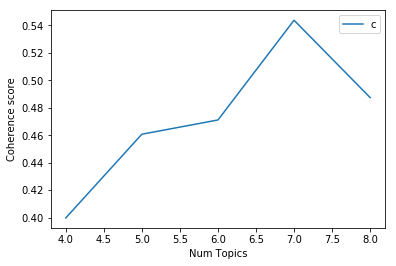

In [22]:
# display the coherence score of the different models
model_list_hashtag_pooling = hashtag_pooling_models[0]
coherence_values_hashtag_pooling = hashtag_pooling_models[1]

limit=9; start=4; step=1;
x = range(start, limit, step)
_ = plt.plot(x, coherence_values_hashtag_pooling)
_ = plt.xlabel("Num Topics")
_ = plt.ylabel("Coherence score")
_ = plt.legend(("coherence_values"), loc='best')
_ = plt.savefig("hashtag_pooling_coherence_scores")
_ = plt.show()

#### Choose the model with the highest coherence score (7 topics).

In [17]:
# print topics of model with highest coherence score
lda_model_hashtag_pooling = model_list_hashtag_pooling[3] # 7 topics
_ = lda_model_hashtag_pooling.print_topics()

2018-10-03 08:01:25,291 : INFO : topic #0 (0.029): 0.023*"#youtube" + 0.016*"#workout" + 0.015*"#fit" + 0.015*"#fitness" + 0.013*"#love" + 0.013*"#gym" + 0.012*"#health" + 0.012*"#fitfam" + 0.012*"#meditation" + 0.012*"#healthy"
2018-10-03 08:01:25,294 : INFO : topic #1 (0.040): 0.025*"#yogi" + 0.025*"#yoga" + 0.025*"#yogaeverydamnday" + 0.018*"#selfie" + 0.018*"thursday" + 0.017*"throwback" + 0.016*"#yogaeverywhere" + 0.016*"#yogainspiration" + 0.009*"#yummy" + 0.009*"place"
2018-10-03 08:01:25,296 : INFO : topic #2 (0.030): 0.016*"night" + 0.013*"#ølgod" + 0.008*"city" + 0.008*"amazing" + 0.008*"#friends" + 0.008*"real" + 0.007*"offer" + 0.007*"cocktail" + 0.007*"beer" + 0.007*"shirt"
2018-10-03 08:01:25,298 : INFO : topic #3 (0.029): 0.035*"#graffiti" + 0.035*"#streetart" + 0.016*"#arteurbano" + 0.013*"#digerible" + 0.011*"#artecallejero" + 0.011*"#streetphotography" + 0.010*"#artederua" + 0.010*"arte" + 0.010*"urbano" + 0.008*"#arteenlacalle"
2018-10-03 08:01:25,301 : INFO : topic 

### Visualize Hashtag Pooling Model

In [61]:
pyLDAvis.enable_notebook()
vis_hp = pyLDAvis.gensim.prepare(lda_model_hashtag_pooling, corpus_hashtag_pooling, dictionary_hashtag_pooling)

In [62]:
vis_hp

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      42.664169        1       1 -0.109605 -0.081534
5      13.680170        1       2 -0.117746 -0.117649
3      11.216218        1       3 -0.010832 -0.115943
6      10.473912        1       4  0.093622 -0.115008
1       8.229032        1       5  0.338351  0.102742
2       7.358588        1       6 -0.043601  0.010600
0       6.377911        1       7 -0.150189  0.316792, topic_info=     Category         Freq               Term        Total  loglift  logprob
term                                                                        
131   Default   469.000000          #graffiti   469.000000  30.0000  30.0000
936   Default   467.000000         #streetart   467.000000  29.0000  29.0000
615   Default  1341.000000            sagrada  1341.000000  28.0000  28.0000
6752  Default   225.000000              #yogi   225.000000  27.0000  27.0000
6751  Default   220.000000              #yoga   220.000000  26.0000  26.0000
8269  Default   219.000000  #yogaeverydamnday   219.000000  25.0000  25.0000
6579  Default   238.000000               #yum   238.000000  24.0000  24.0000
123   Default   859.000000             #gaudi   859.000000  23.0000  23.0000
375   Default   611.000000           basílica   611.000000  22.0000  22.0000
272   Default  1680.000000    #sagradafamilia  1680.000000  21.0000  21.0000
314   Default   911.000000            #travel   911.000000  20.0000  20.0000
342   Default   156.000000           #youtube   156.000000  19.0000  19.0000
958   Default   192.000000        #arteurbano   192.000000  18.0000  18.0000
2932  Default   163.000000           thursday   163.000000  17.0000  17.0000
280   Default   258.000000            #selfie   258.000000  16.0000  16.0000
460   Default   725.000000            familia   725.000000  15.0000  15.0000
2766  Default   157.000000          throwback   157.000000  14.0000  14.0000
37    Default   317.000000         #catalonia   317.000000  13.0000  13.0000
9210  Default   146.000000   #yogainspiration   146.000000  12.0000  12.0000
9209  Default   146.000000    #yogaeverywhere   146.000000  11.0000  11.0000
585   Default   295.000000              place   295.000000  10.0000  10.0000
246   Default   242.000000     #photooftheday   242.000000   9.0000   9.0000
3     Default   426.000000      #architecture   426.000000   8.0000   8.0000
4326  Default   161.000000         #digerible   161.000000   7.0000   7.0000
11    Default   317.000000             #beach   317.000000   6.0000   6.0000
3992  Default   151.000000               call   151.000000   5.0000   5.0000
187   Default   721.000000              #love   721.000000   4.0000   4.0000
563   Default   287.000000              night   287.000000   3.0000   3.0000
1941  Default   185.000000               home   185.000000   2.0000   2.0000
5558  Default   138.000000          #yogagirl   138.000000   1.0000   1.0000
...       ...          ...                ...          ...      ...      ...
9221   Topic7    37.616020               test    38.053829   2.7408  -5.2071
9220   Topic7    37.616020           prepping    38.053829   2.7408  -5.2071
9218   Topic7    37.616020           #seminar    38.053829   2.7408  -5.2071
9222   Topic7    37.616020         tomorrow's    38.053829   2.7408  -5.2071
9219   Topic7    37.616020     #younglearners    38.053829   2.7408  -5.2071
345    Topic7    39.573630          #zalandox    40.035068   2.7407  -5.1563
6915   Topic7    37.395739     chepolohelados    37.836485   2.7406  -5.2129
6917   Topic7    37.395739    you#bonepartyof    37.836485   2.7406  -5.2129
3212   Topic7    79.808701           #healthy    81.279952   2.7341  -4.4549
2160   Topic7    40.450404              close    40.928222   2.7406  -5.1344
8691   Topic7    40.166345         #messyhair    40.643464   2.7405  -5.1415
8692   Topic7    40.166345             #ochoa    40.643464   2.7405  -5.1415
788   

### Intermediary Result:

#### After training ~50 models for each pooling method, the following conclusion was reached: An inspection of the topics of the no pooling and user pooling method shows that they are less human interpretable than hashtag pooling models and show some repetitions in words among topics. Moreover, the no pooling model and user pooling model are very unstable as tweets are very short. The best trained hashtag pooling model (meaning the one with the most human interpretable topics) will therefore be saved and used for further purposes. Hashtag pooling was also shown to give the best results in various research papers.

## Save Models

In [49]:
lda_model_no_pooling.save('lda_model_no_pooling.model') 
lda_model_user_pooling.save('lda_model_user_pooling.model') 
lda_model_hashtag_pooling.save('lda_model_hashtag_pooling.model')

2018-10-03 08:31:58,659 : INFO : saving LdaState object under lda_model_no_pooling.model.state, separately None
2018-10-03 08:31:58,667 : INFO : saved lda_model_no_pooling.model.state
2018-10-03 08:31:58,675 : INFO : saving LdaModel object under lda_model_no_pooling.model, separately ['expElogbeta', 'sstats']
2018-10-03 08:31:58,678 : INFO : storing np array 'expElogbeta' to lda_model_no_pooling.model.expElogbeta.npy
2018-10-03 08:31:58,683 : INFO : not storing attribute dispatcher
2018-10-03 08:31:58,685 : INFO : not storing attribute id2word
2018-10-03 08:31:58,688 : INFO : not storing attribute state
2018-10-03 08:31:58,693 : INFO : saved lda_model_no_pooling.model
2018-10-03 08:31:58,695 : INFO : saving LdaState object under lda_model_user_pooling.model.state, separately None
2018-10-03 08:31:58,701 : INFO : saved lda_model_user_pooling.model.state
2018-10-03 08:31:58,708 : INFO : saving LdaModel object under lda_model_user_pooling.model, separately ['expElogbeta', 'sstats']
2018-1

## Test Whether TFIDF Can Improve LDA (Instead of BOW)

#### Sometimes TFIDF improves LDA performance although LDA is mathematically meant to process a BOW input. TFIDF is therefore used to transform the corpus of the chosen model (hashtag pooling model with 7 topics).

In [73]:
# initialize tfidf model
tfidf_hashtag_pooling = models.TfidfModel(corpus_hashtag_pooling)
   
# run term frequency inverse document frequency transformation
# (transform bag-of-words integer counts corpus to tfidf real-valued weights
# corpus)
corpus_tfidf_hashtag_pooling = tfidf_hashtag_pooling[corpus_hashtag_pooling]
for doc in corpus_tfidf_hashtag_pooling:
    print(doc)

2018-10-02 07:22:21,349 : INFO : collecting document frequencies
2018-10-02 07:22:21,353 : INFO : PROGRESS: processing document #0
2018-10-02 07:22:21,478 : INFO : calculating IDF weights for 6040 documents and 9329 features (78970 matrix non-zeros)


[(0, 0.0199863227055571), (1, 0.039081489183023607), (2, 0.017151200283475224), (3, 0.031011931531736946), (4, 0.037735852213136988), (5, 0.0199863227055571), (6, 0.019154767272708203), (7, 0.019154767272708203), (8, 0.014502628790419267), (9, 0.021158334261941181), (10, 0.017151200283475224), (11, 0.010123098737364748), (12, 0.013689195900691958), (13, 0.019540744591511804), (14, 0.014972395632728543), (15, 0.0205133297581182), (16, 0.02316190125117416), (17, 0.018509762768885222), (18, 0.018509762768885222), (19, 0.01636516604589474), (20, 0.019540744591511804), (21, 0.016810744159940039), (22, 0.013635165614322983), (23, 0.01733775121250114), (24, 0.03507435520455765), (25, 0.031958377454182285), (26, 0.014162172666884083), (27, 0.0199863227055571), (28, 0.018509762768885222), (29, 0.01775138937549306), (30, 0.015239404054736179), (31, 0.021989889694790078), (32, 0.0199863227055571), (33, 0.017537177602278825), (34, 0.01775138937549306), (35, 0.02316190125117416), (36, 0.01753717760

[(4, 0.2057753606543592), (247, 0.33447208464367495), (248, 0.30752220391825608), (249, 0.32846288135962681), (250, 0.36667908522024151), (1232, 0.24975106880524434), (2000, 0.25548674058208798), (2255, 0.28287850782400942), (2256, 0.3781742612873556), (2257, 0.39772919253975253)]
[(129, 0.4539389720937822), (211, 0.41923458642836431), (438, 0.4539389720937822), (661, 0.4539389720937822), (708, 0.4539389720937822)]
[(374, 0.44629438342530914), (379, 0.38415505303356562), (586, 0.46954212320959293), (2258, 0.65785744130748347)]
[]
[(272, 0.12990667604873399), (314, 0.15338377176079113), (317, 0.2155477319311884), (342, 0.30792703325616527), (1775, 0.25806597369880496), (1776, 0.62897903501416652), (1777, 0.3544496205414846), (1778, 0.26715086015302392), (2259, 0.39887467038759478)]
[(218, 0.3929150249105744), (460, 0.2157547530706129), (615, 0.18078296602043295), (2260, 0.48508626107037028), (2261, 0.51530404046765688), (2262, 0.51530404046765688)]
[(2063, 0.35214412584690141), (2202, 0

[(187, 0.083693820103751843), (209, 0.11565267797568987), (319, 0.29927022170257284), (770, 0.1329451566957682), (2506, 0.36631029523709691), (2507, 0.2949564458860835), (2508, 0.19097988673494018), (2509, 0.19097988673494018), (2510, 0.17030749879311327), (2511, 0.34061499758622654), (2512, 0.36631029523709691), (2513, 0.194122153650994), (2514, 0.19097988673494018), (2515, 0.388244307301988), (2516, 0.194122153650994), (2517, 0.19097988673494018)]
[(106, 0.17252032544248871), (133, 0.20662446780984192), (213, 0.21731601430546804), (378, 0.21911642998258454), (385, 0.22298985576172117), (1494, 0.26760080939234421), (1576, 0.45928159427066961), (1622, 0.19322289954527577), (4849, 0.2348087234437703), (6577, 0.25646694999443237), (6578, 0.25646694999443237), (6579, 0.22298985576172117), (6580, 0.25646694999443237), (7322, 0.28329310285352993), (7323, 0.28329310285352993)]
[(41, 0.44999834296365526), (104, 0.22758721026042297), (115, 0.18136742611084464), (116, 0.11575199428154609), (127

[(1649, 0.26421771462840776), (2012, 0.26270366299733861), (2278, 0.34285930640680495), (3891, 0.27630919771174195), (4680, 0.31552304075762383), (4864, 0.35992415642224734), (5111, 0.35992415642224734), (5992, 0.34285930640680495), (6124, 0.29785798299015948), (6156, 0.31993599355538083)]
[(688, 0.31422789319439232), (1115, 0.26308274899836531), (1957, 0.35995479033767236), (2650, 0.38268523577069596), (8693, 0.43051630149320558), (8694, 0.43051630149320558), (8695, 0.43051630149320558)]
[(131, 0.12507035553371373), (688, 0.16910616152111776), (958, 0.17544482057325728), (1115, 0.14158168262298365), (1957, 0.19371473453976873), (2650, 0.61784233061657345), (2651, 0.15223763202390825), (2652, 0.22573610787248427), (2653, 0.17544482057325728), (2831, 0.18986944286903945), (6102, 0.21634408065182217), (8693, 0.23168840448147554), (8694, 0.23168840448147554), (8695, 0.23168840448147554), (8696, 0.26160277287592909), (8697, 0.26160277287592909)]
[(3019, 0.30474512734743969), (4498, 0.33554

[(68, 0.32307190220846244), (136, 0.31477187617876295), (234, 0.32307190220846244), (265, 0.25359955201286655), (356, 0.32307190220846244), (429, 0.31477187617876295), (466, 0.32307190220846244), (490, 0.32307190220846244), (542, 0.22106559492902111), (573, 0.32307190220846244), (620, 0.24980367873950218)]
[(486, 0.17997166093758099), (600, 0.19148607376054083), (7240, 0.43149583655352719), (7241, 0.43149583655352719), (7242, 0.43149583655352719), (7243, 0.43149583655352719), (7244, 0.43149583655352719)]
[(169, 0.54843281841184632), (244, 0.33577244058991135), (8859, 0.76581871995213924)]
[(486, 0.21411830506169241), (563, 0.25099358508667063), (600, 0.22781738715377722), (1291, 0.43389324311943522), (1847, 0.38375212803995951), (2027, 0.40955340071562735), (9080, 0.57964797899728771)]
[(745, 0.26296324455592196), (1367, 0.23764473957630616), (8851, 0.38174496498847937), (8852, 0.38174496498847937), (8853, 0.38174496498847937), (8854, 0.38174496498847937), (8855, 0.38174496498847937), 

In [74]:
# train hashtag pooling model with tfidf corpus
lda_model_hashtag_pooling_tfidf = models.LdaModel(corpus_tfidf_hashtag_pooling,
                                       id2word=dictionary_hashtag_pooling,
                                       alpha='auto', eta='auto',
                                       eval_every=1,
                                       iterations=400, passes=20, num_topics=7)

2018-10-02 07:24:37,276 : INFO : using autotuned alpha, starting with [0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715]
2018-10-02 07:24:37,280 : INFO : using serial LDA version on this node
2018-10-02 07:24:37,293 : INFO : running online (multi-pass) LDA training, 7 topics, 20 passes over the supplied corpus of 6040 documents, updating model once every 2000 documents, evaluating perplexity every 2000 documents, iterating 400x with a convergence threshold of 0.001000
2018-10-02 07:24:38,243 : INFO : -13.890 per-word bound, 15180.5 perplexity estimate based on a held-out corpus of 2000 documents with 5704 words
2018-10-02 07:24:38,244 : INFO : PROGRESS: pass 0, at document #2000/6040
2018-10-02 07:24:38,884 : INFO : optimized alpha [0.12988012, 0.12784421, 0.12707655, 0.13058132, 0.1280534, 0.13039352, 0.12741488]
2018-10-02 07:24:38,886 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-02 07:24:38,896 : INFO : topic #

2018-10-02 07:24:42,574 : INFO : topic #5 (0.120): 0.018*"#yoga" + 0.014*"#yogi" + 0.006*"#workout" + 0.006*"#fit" + 0.005*"#yogalove" + 0.005*"#namaste" + 0.005*"#fitfam" + 0.005*"#healthy" + 0.005*"#handstands" + 0.005*"#tattooedyogi"
2018-10-02 07:24:42,577 : INFO : topic #1 (0.124): 0.015*"#yogaeverydamnday" + 0.009*"thursday" + 0.007*"família" + 0.007*"basílica" + 0.006*"sagrada" + 0.005*"#yummy" + 0.005*"perch" + 0.005*"pau" + 0.005*"#youcanseeourhousefromhere" + 0.005*"#blueskies"
2018-10-02 07:24:42,580 : INFO : topic #0 (0.139): 0.011*"#yogagirl" + 0.011*"inner" + 0.011*"#yogadiary" + 0.011*"#yogabarcelona" + 0.010*"throwback" + 0.010*"yoga" + 0.008*"call" + 0.007*"home" + 0.007*"place" + 0.007*"nearly"
2018-10-02 07:24:42,582 : INFO : topic diff=0.342698, rho=0.446322
2018-10-02 07:24:43,252 : INFO : -10.738 per-word bound, 1708.2 perplexity estimate based on a held-out corpus of 2000 documents with 5995 words
2018-10-02 07:24:43,253 : INFO : PROGRESS: pass 1, at document #40

2018-10-02 07:24:46,807 : INFO : topic #2 (0.103): 0.005*"arm" + 0.004*"#pardes" + 0.004*"gothic" + 0.003*"quarter" + 0.003*"sagrada" + 0.003*"#friends" + 0.003*"#cruilla" + 0.003*"d'art" + 0.003*"centre" + 0.002*"#expo"
2018-10-02 07:24:46,810 : INFO : topic #5 (0.109): 0.011*"#yoga" + 0.009*"#yogi" + 0.004*"#fit" + 0.004*"#workout" + 0.004*"#love" + 0.004*"#fitness" + 0.004*"#fitfam" + 0.004*"#yogalove" + 0.004*"#namaste" + 0.004*"#healthy"
2018-10-02 07:24:46,812 : INFO : topic #1 (0.112): 0.008*"#yogaeverydamnday" + 0.006*"basílica" + 0.005*"thursday" + 0.005*"sagrada" + 0.005*"família" + 0.004*"#yogainspiration" + 0.004*"#yogaeverywhere" + 0.003*"#yummy" + 0.003*"fashion" + 0.003*"#selfie"
2018-10-02 07:24:46,815 : INFO : topic #0 (0.138): 0.006*"throwback" + 0.006*"#yogabarcelona" + 0.006*"inner" + 0.006*"#yogagirl" + 0.006*"#yogadiary" + 0.006*"#sagradafamilia" + 0.006*"sagrada" + 0.005*"yoga" + 0.005*"familia" + 0.005*"call"
2018-10-02 07:24:46,817 : INFO : topic diff=0.212687,

2018-10-02 07:24:50,927 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-02 07:24:50,939 : INFO : topic #3 (0.090): 0.004*"sagrada" + 0.004*"#yum" + 0.003*"#tapas" + 0.003*"beautiful" + 0.003*"#sagradafamilia" + 0.003*"tapa" + 0.003*"gothic" + 0.003*"wife" + 0.003*"#youknowimright" + 0.003*"#summer"
2018-10-02 07:24:50,941 : INFO : topic #2 (0.092): 0.004*"sagrada" + 0.003*"arm" + 0.003*"basílica" + 0.003*"gothic" + 0.003*"quarter" + 0.003*"família" + 0.003*"#travel" + 0.003*"#pardes" + 0.002*"#friends" + 0.002*"#love"
2018-10-02 07:24:50,944 : INFO : topic #5 (0.099): 0.007*"#yoga" + 0.006*"#yogi" + 0.004*"#yogaeverydamnday" + 0.004*"sagrada" + 0.004*"#love" + 0.003*"#workout" + 0.003*"#sagradafamilia" + 0.003*"#fit" + 0.003*"#gaudi" + 0.003*"#fitness"
2018-10-02 07:24:50,947 : INFO : topic #1 (0.100): 0.004*"sagrada" + 0.003*"#yogaeverydamnday" + 0.003*"basílica" + 0.003*"thursday" + 0.003*"#yogainspiration" + 0.003*"#yogaeverywhere" + 0.003*"#sagra

2018-10-02 07:24:54,127 : INFO : -7.920 per-word bound, 242.2 perplexity estimate based on a held-out corpus of 40 documents with 118 words
2018-10-02 07:24:54,128 : INFO : PROGRESS: pass 4, at document #6040/6040
2018-10-02 07:24:54,138 : INFO : optimized alpha [0.11374728, 0.088251092, 0.084525064, 0.078975692, 0.090403542, 0.092788778, 0.082752898]
2018-10-02 07:24:54,141 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-02 07:24:54,153 : INFO : topic #3 (0.079): 0.014*"#yum" + 0.010*"wife" + 0.010*"#youknowimright" + 0.009*"anyone" + 0.009*"#png" + 0.009*"#zoo" + 0.008*"zoo" + 0.008*"tapa" + 0.007*"#tapas" + 0.007*"beautiful"
2018-10-02 07:24:54,155 : INFO : topic #6 (0.083): 0.008*"deal" + 0.008*"#yummi" + 0.007*"#hostallife" + 0.007*"#zarox" + 0.007*"#nightout" + 0.007*"#bookstagram" + 0.006*"#younglearners" + 0.006*"prepping" + 0.006*"test" + 0.006*"tomorrow's"
2018-10-02 07:24:54,158 : INFO : topic #4 (0.090): 0.011*"#youtube" + 0.007*"#youtubers

2018-10-02 07:24:57,090 : INFO : topic #0 (0.105): 0.014*"#yogabarcelona" + 0.014*"#yogadiary" + 0.014*"#yogagirl" + 0.014*"inner" + 0.013*"yoga" + 0.011*"call" + 0.009*"home" + 0.009*"place" + 0.008*"nearly" + 0.007*"#yummyfood"
2018-10-02 07:24:57,092 : INFO : topic diff=0.153494, rho=0.332964
2018-10-02 07:24:57,710 : INFO : -10.418 per-word bound, 1368.1 perplexity estimate based on a held-out corpus of 2000 documents with 5704 words
2018-10-02 07:24:57,711 : INFO : PROGRESS: pass 6, at document #2000/6040
2018-10-02 07:24:58,027 : INFO : optimized alpha [0.10198212, 0.079201095, 0.077546149, 0.072343498, 0.082352787, 0.084647618, 0.076187976]
2018-10-02 07:24:58,029 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-02 07:24:58,039 : INFO : topic #3 (0.072): 0.009*"#yum" + 0.006*"#youknowimright" + 0.006*"wife" + 0.006*"anyone" + 0.005*"#png" + 0.005*"#zoo" + 0.005*"#tapas" + 0.005*"zoo" + 0.005*"beautiful" + 0.005*"tapa"
2018-10-02 07:24:58,041 : 

2018-10-02 07:25:00,956 : INFO : topic #5 (0.080): 0.016*"#yogaeverydamnday" + 0.015*"#yoga" + 0.012*"#yogainspiration" + 0.012*"#yogaeverywhere" + 0.011*"#yogi" + 0.010*"throwback" + 0.010*"thursday" + 0.008*"#selfie" + 0.005*"#fit" + 0.005*"#workout"
2018-10-02 07:25:00,958 : INFO : topic #0 (0.095): 0.009*"#yogagirl" + 0.009*"inner" + 0.009*"#yogabarcelona" + 0.009*"#yogadiary" + 0.009*"yoga" + 0.007*"call" + 0.007*"home" + 0.007*"place" + 0.006*"#sagradafamilia" + 0.006*"nearly"
2018-10-02 07:25:00,961 : INFO : topic diff=0.139181, rho=0.301238
2018-10-02 07:25:01,571 : INFO : -10.241 per-word bound, 1210.1 perplexity estimate based on a held-out corpus of 2000 documents with 5995 words
2018-10-02 07:25:01,572 : INFO : PROGRESS: pass 7, at document #4000/6040
2018-10-02 07:25:01,863 : INFO : optimized alpha [0.094847724, 0.072449274, 0.071396969, 0.066287205, 0.075911805, 0.077958763, 0.070219778]
2018-10-02 07:25:01,865 : INFO : merging changes from 2000 documents into a model of 

2018-10-02 07:25:04,793 : INFO : topic #4 (0.072): 0.005*"#youtube" + 0.003*"#youtubers" + 0.003*"#newvideo" + 0.003*"#pllfinale" + 0.003*"yayyy" + 0.003*"vídeo" + 0.003*"#teaser" + 0.003*"nuevo" + 0.003*"time" + 0.003*"#video"
2018-10-02 07:25:04,796 : INFO : topic #5 (0.074): 0.011*"#yogaeverydamnday" + 0.011*"#yoga" + 0.009*"#yogainspiration" + 0.009*"#yogaeverywhere" + 0.008*"#yogi" + 0.007*"throwback" + 0.007*"thursday" + 0.006*"#selfie" + 0.004*"#fit" + 0.004*"#workout"
2018-10-02 07:25:04,799 : INFO : topic #0 (0.089): 0.006*"#yogagirl" + 0.006*"#yogabarcelona" + 0.006*"inner" + 0.006*"#yogadiary" + 0.006*"sagrada" + 0.006*"#sagradafamilia" + 0.006*"yoga" + 0.005*"call" + 0.005*"place" + 0.005*"home"
2018-10-02 07:25:04,802 : INFO : topic diff=0.120508, rho=0.288435
2018-10-02 07:25:05,422 : INFO : -10.106 per-word bound, 1101.8 perplexity estimate based on a held-out corpus of 2000 documents with 5900 words
2018-10-02 07:25:05,423 : INFO : PROGRESS: pass 8, at document #6000/60

2018-10-02 07:25:09,078 : INFO : topic #6 (0.061): 0.004*"#sagradafamilia" + 0.003*"#beach" + 0.003*"gothic" + 0.003*"sagrada" + 0.003*"#summer" + 0.002*"quarter" + 0.002*"deal" + 0.002*"#yummi" + 0.002*"#nightout" + 0.002*"see"
2018-10-02 07:25:09,082 : INFO : topic #4 (0.067): 0.004*"#youtube" + 0.003*"sagrada" + 0.003*"time" + 0.003*"#happiness" + 0.003*"nuevo" + 0.003*"#youtubers" + 0.003*"#newvideo" + 0.003*"#pllfinale" + 0.003*"yayyy" + 0.003*"vídeo"
2018-10-02 07:25:09,085 : INFO : topic #5 (0.068): 0.008*"#yogaeverydamnday" + 0.008*"#yoga" + 0.006*"#yogainspiration" + 0.006*"#yogaeverywhere" + 0.006*"#yogi" + 0.005*"thursday" + 0.005*"throwback" + 0.004*"#selfie" + 0.004*"sagrada" + 0.004*"#love"
2018-10-02 07:25:09,088 : INFO : topic #0 (0.084): 0.006*"sagrada" + 0.006*"#sagradafamilia" + 0.005*"familia" + 0.004*"#yogagirl" + 0.004*"inner" + 0.004*"#yogadiary" + 0.004*"#yogabarcelona" + 0.004*"yoga" + 0.004*"place" + 0.004*"call"
2018-10-02 07:25:09,092 : INFO : topic diff=0.1

2018-10-02 07:25:12,533 : INFO : merging changes from 40 documents into a model of 6040 documents
2018-10-02 07:25:12,547 : INFO : topic #3 (0.053): 0.012*"#yum" + 0.008*"#youknowimright" + 0.008*"wife" + 0.007*"anyone" + 0.007*"#png" + 0.007*"#zoo" + 0.006*"zoo" + 0.006*"#tapas" + 0.006*"tapa" + 0.006*"beautiful"
2018-10-02 07:25:12,549 : INFO : topic #6 (0.056): 0.006*"deal" + 0.006*"#yummi" + 0.006*"#hostallife" + 0.006*"#zarox" + 0.006*"#nightout" + 0.005*"cocktail" + 0.005*"#bookstagram" + 0.005*"prepping" + 0.005*"#seminar" + 0.005*"test"
2018-10-02 07:25:12,552 : INFO : topic #4 (0.063): 0.009*"#youtube" + 0.006*"#youtubers" + 0.006*"#newvideo" + 0.006*"#pllfinale" + 0.006*"yayyy" + 0.006*"vídeo" + 0.006*"#teaser" + 0.006*"nuevo" + 0.006*"#video" + 0.005*"#niceweekend"
2018-10-02 07:25:12,555 : INFO : topic #5 (0.065): 0.019*"#yogaeverydamnday" + 0.018*"#yoga" + 0.015*"#yogaeverywhere" + 0.015*"#yogainspiration" + 0.014*"#yogi" + 0.012*"throwback" + 0.012*"thursday" + 0.009*"#se

2018-10-02 07:25:16,081 : INFO : -10.212 per-word bound, 1185.7 perplexity estimate based on a held-out corpus of 2000 documents with 5704 words
2018-10-02 07:25:16,082 : INFO : PROGRESS: pass 12, at document #2000/6040
2018-10-02 07:25:16,364 : INFO : optimized alpha [0.072476886, 0.055198178, 0.054558709, 0.050360102, 0.058813639, 0.061401274, 0.053159017]
2018-10-02 07:25:16,366 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-02 07:25:16,375 : INFO : topic #3 (0.050): 0.009*"#yum" + 0.006*"wife" + 0.006*"#youknowimright" + 0.005*"anyone" + 0.005*"#png" + 0.005*"#zoo" + 0.005*"beautiful" + 0.005*"#tapas" + 0.005*"zoo" + 0.004*"tapa"
2018-10-02 07:25:16,377 : INFO : topic #6 (0.053): 0.004*"#sagradafamilia" + 0.004*"deal" + 0.004*"#yummi" + 0.004*"#nightout" + 0.004*"#hostallife" + 0.004*"#zarox" + 0.004*"cocktail" + 0.004*"#bookstagram" + 0.004*"book" + 0.004*"#seminar"
2018-10-02 07:25:16,380 : INFO : topic #4 (0.059): 0.007*"#youtube" + 0.004*"#y

2018-10-02 07:25:19,249 : INFO : topic #0 (0.069): 0.009*"#yogagirl" + 0.009*"inner" + 0.009*"#yogabarcelona" + 0.009*"#yogadiary" + 0.008*"yoga" + 0.007*"call" + 0.006*"place" + 0.006*"home" + 0.006*"#sagradafamilia" + 0.006*"sagrada"
2018-10-02 07:25:19,251 : INFO : topic diff=0.100620, rho=0.242393
2018-10-02 07:25:19,864 : INFO : -10.087 per-word bound, 1087.5 perplexity estimate based on a held-out corpus of 2000 documents with 5995 words
2018-10-02 07:25:19,865 : INFO : PROGRESS: pass 13, at document #4000/6040
2018-10-02 07:25:20,145 : INFO : optimized alpha [0.069342427, 0.052116968, 0.051579099, 0.047332063, 0.055350684, 0.057925798, 0.050184488]
2018-10-02 07:25:20,147 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-02 07:25:20,159 : INFO : topic #3 (0.047): 0.007*"#yum" + 0.004*"#youknowimright" + 0.004*"wife" + 0.004*"beautiful" + 0.004*"anyone" + 0.004*"#tapas" + 0.004*"sagrada" + 0.004*"#png" + 0.004*"#zoo" + 0.004*"tapa"
2018-10-02 07:

2018-10-02 07:25:23,234 : INFO : topic #5 (0.056): 0.011*"#yogaeverydamnday" + 0.011*"#yoga" + 0.009*"#yogainspiration" + 0.009*"#yogaeverywhere" + 0.008*"#yogi" + 0.007*"throwback" + 0.007*"thursday" + 0.006*"#selfie" + 0.004*"#fit" + 0.004*"#workout"
2018-10-02 07:25:23,237 : INFO : topic #0 (0.067): 0.006*"#yogagirl" + 0.006*"#yogadiary" + 0.006*"#yogabarcelona" + 0.006*"inner" + 0.006*"sagrada" + 0.006*"yoga" + 0.006*"#sagradafamilia" + 0.005*"call" + 0.005*"place" + 0.005*"home"
2018-10-02 07:25:23,240 : INFO : topic diff=0.088825, rho=0.235571
2018-10-02 07:25:23,933 : INFO : -10.007 per-word bound, 1029.2 perplexity estimate based on a held-out corpus of 2000 documents with 5900 words
2018-10-02 07:25:23,934 : INFO : PROGRESS: pass 14, at document #6000/6040
2018-10-02 07:25:24,226 : INFO : optimized alpha [0.06639646, 0.04944035, 0.04880837, 0.0446654, 0.052489411, 0.054676156, 0.047948554]
2018-10-02 07:25:24,228 : INFO : merging changes from 2000 documents into a model of 604

2018-10-02 07:25:27,130 : INFO : topic #4 (0.050): 0.004*"#youtube" + 0.003*"sagrada" + 0.003*"time" + 0.003*"nuevo" + 0.003*"#happiness" + 0.003*"#youtubers" + 0.003*"#newvideo" + 0.003*"#pllfinale" + 0.003*"yayyy" + 0.003*"vídeo"
2018-10-02 07:25:27,132 : INFO : topic #5 (0.053): 0.009*"#yogaeverydamnday" + 0.008*"#yoga" + 0.007*"#yogainspiration" + 0.007*"#yogaeverywhere" + 0.007*"#yogi" + 0.006*"throwback" + 0.006*"thursday" + 0.005*"#selfie" + 0.004*"sagrada" + 0.003*"#love"
2018-10-02 07:25:27,135 : INFO : topic #0 (0.064): 0.006*"sagrada" + 0.006*"#sagradafamilia" + 0.005*"#yogabarcelona" + 0.005*"#yogadiary" + 0.005*"#yogagirl" + 0.005*"inner" + 0.005*"familia" + 0.004*"yoga" + 0.004*"place" + 0.004*"call"
2018-10-02 07:25:27,137 : INFO : topic diff=0.084951, rho=0.229295
2018-10-02 07:25:27,175 : INFO : -7.466 per-word bound, 176.9 perplexity estimate based on a held-out corpus of 40 documents with 118 words
2018-10-02 07:25:27,177 : INFO : PROGRESS: pass 15, at document #6040

2018-10-02 07:25:30,031 : INFO : topic #6 (0.043): 0.005*"deal" + 0.005*"#yummi" + 0.005*"#nightout" + 0.005*"#hostallife" + 0.005*"#zarox" + 0.005*"cocktail" + 0.005*"#bookstagram" + 0.005*"#sagradafamilia" + 0.004*"test" + 0.004*"prepping"
2018-10-02 07:25:30,035 : INFO : topic #4 (0.048): 0.008*"#youtube" + 0.005*"#youtubers" + 0.005*"#newvideo" + 0.005*"#pllfinale" + 0.005*"yayyy" + 0.005*"vídeo" + 0.005*"#teaser" + 0.005*"nuevo" + 0.005*"#video" + 0.005*"zoo"
2018-10-02 07:25:30,037 : INFO : topic #5 (0.051): 0.017*"#yogaeverydamnday" + 0.016*"#yoga" + 0.013*"#yogaeverywhere" + 0.013*"#yogainspiration" + 0.012*"#yogi" + 0.011*"throwback" + 0.011*"thursday" + 0.008*"#selfie" + 0.005*"anyone#fitness" + 0.005*"#namaste"
2018-10-02 07:25:30,040 : INFO : topic #0 (0.061): 0.010*"#yogadiary" + 0.010*"inner" + 0.010*"#yogagirl" + 0.010*"#yogabarcelona" + 0.009*"yoga" + 0.008*"call" + 0.007*"place" + 0.007*"home" + 0.006*"nearly" + 0.006*"#sagradafamilia"
2018-10-02 07:25:30,042 : INFO : 

2018-10-02 07:25:33,870 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-02 07:25:33,881 : INFO : topic #3 (0.039): 0.008*"#yum" + 0.005*"wife" + 0.005*"#youknowimright" + 0.005*"anyone" + 0.005*"#png" + 0.005*"#zoo" + 0.005*"beautiful" + 0.004*"#tapas" + 0.004*"zoo" + 0.004*"tapa"
2018-10-02 07:25:33,883 : INFO : topic #6 (0.042): 0.004*"#sagradafamilia" + 0.004*"deal" + 0.004*"#yummi" + 0.004*"#nightout" + 0.004*"#hostallife" + 0.004*"#zarox" + 0.004*"cocktail" + 0.004*"#bookstagram" + 0.003*"book" + 0.003*"#younglearners"
2018-10-02 07:25:33,886 : INFO : topic #4 (0.046): 0.006*"#youtube" + 0.004*"#youtubers" + 0.004*"#newvideo" + 0.004*"#pllfinale" + 0.004*"yayyy" + 0.004*"vídeo" + 0.004*"#teaser" + 0.004*"nuevo" + 0.004*"#video" + 0.004*"zoo"
2018-10-02 07:25:33,888 : INFO : topic #5 (0.049): 0.014*"#yogaeverydamnday" + 0.013*"#yoga" + 0.011*"#yogainspiration" + 0.011*"#yogaeverywhere" + 0.010*"#yogi" + 0.009*"throwback" + 0.009*"thursday" + 0.00

2018-10-02 07:25:37,377 : INFO : PROGRESS: pass 19, at document #4000/6040
2018-10-02 07:25:37,664 : INFO : optimized alpha [0.055735782, 0.041576445, 0.041137189, 0.03715612, 0.043726292, 0.046439018, 0.039823852]
2018-10-02 07:25:37,666 : INFO : merging changes from 2000 documents into a model of 6040 documents
2018-10-02 07:25:37,678 : INFO : topic #3 (0.037): 0.006*"#yum" + 0.004*"#youknowimright" + 0.004*"wife" + 0.004*"beautiful" + 0.004*"anyone" + 0.004*"#tapas" + 0.004*"sagrada" + 0.004*"#png" + 0.004*"#zoo" + 0.004*"zoo"
2018-10-02 07:25:37,680 : INFO : topic #6 (0.040): 0.004*"#sagradafamilia" + 0.003*"deal" + 0.003*"#yummi" + 0.003*"gothic" + 0.003*"#nightout" + 0.003*"#hostallife" + 0.003*"#zarox" + 0.003*"sagrada" + 0.003*"#beach" + 0.003*"cocktail"
2018-10-02 07:25:37,683 : INFO : topic #4 (0.044): 0.005*"#youtube" + 0.003*"#youtubers" + 0.003*"#newvideo" + 0.003*"#pllfinale" + 0.003*"yayyy" + 0.003*"vídeo" + 0.003*"#teaser" + 0.003*"nuevo" + 0.003*"time" + 0.003*"#video"

In [75]:
# print topics of model
_ = lda_model_hashtag_pooling_tfidf.print_topics()

2018-10-02 07:25:49,222 : INFO : topic #0 (0.055): 0.010*"inner" + 0.010*"#yogagirl" + 0.010*"#yogadiary" + 0.010*"#yogabarcelona" + 0.009*"yoga" + 0.008*"call" + 0.007*"place" + 0.007*"home" + 0.006*"nearly" + 0.006*"#sagradafamilia"
2018-10-02 07:25:49,225 : INFO : topic #1 (0.041): 0.005*"#yummy" + 0.004*"#youcanseeourhousefromhere" + 0.004*"#blueskies" + 0.004*"#watchcat" + 0.004*"chepolohelados" + 0.004*"#youaresosocool" + 0.004*"meant" + 0.004*"you#bonepartyof" + 0.004*"perch" + 0.004*"pau"
2018-10-02 07:25:49,227 : INFO : topic #2 (0.040): 0.008*"arm" + 0.006*"sagrada" + 0.005*"#pardes" + 0.005*"família" + 0.005*"basílica" + 0.004*"#friends" + 0.003*"#liveasanative" + 0.003*"net" + 0.003*"revenue" + 0.003*"#yurbban"
2018-10-02 07:25:49,229 : INFO : topic #3 (0.036): 0.010*"#yum" + 0.007*"#youknowimright" + 0.007*"wife" + 0.006*"anyone" + 0.006*"#png" + 0.006*"#zoo" + 0.005*"zoo" + 0.005*"#tapas" + 0.005*"beautiful" + 0.005*"tapa"
2018-10-02 07:25:49,231 : INFO : topic #4 (0.043)

#### In the case of tweets, however, TFIDF does not improve the results but makes them worse and less interpretable. Very rare terms are weighted heavier but in the case of tweets these seldomly have an interpretable topic (e.g. "#youcanseeourhousefromhere"). The model that will be used as final LDA model is thus the 7 topics hashtag pooling model applied to a BOW corpus.

### Analysis of Topics

In [77]:
pyLDAvis.enable_notebook()
vis_hp = pyLDAvis.gensim.prepare(lda_model_hashtag_pooling, corpus_hashtag_pooling, dictionary_hashtag_pooling)

In [78]:
vis_hp

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      42.666591        1       1 -0.109605 -0.081534
5      13.683157        1       2 -0.117746 -0.117649
3      11.216244        1       3 -0.010832 -0.115943
6      10.475012        1       4  0.093622 -0.115008
1       8.226541        1       5  0.338351  0.102742
2       7.354405        1       6 -0.043601  0.010600
0       6.378049        1       7 -0.150189  0.316792, topic_info=     Category         Freq               Term        Total  loglift  logprob
term                                                                        
131   Default   469.000000          #graffiti   469.000000  30.0000  30.0000
936   Default   467.000000         #streetart   467.000000  29.0000  29.0000
615   Default  1342.000000            sagrada  1342.000000  28.0000  28.0000
6752  Default   225.000000              #yogi   225.000000  27.0000  27.0000
6751  Default   220.000000              #yoga   220.000000  26.0000  26.0000
8269  Default   219.000000  #yogaeverydamnday   219.000000  25.0000  25.0000
6579  Default   239.000000               #yum   239.000000  24.0000  24.0000
123   Default   859.000000             #gaudi   859.000000  23.0000  23.0000
375   Default   611.000000           basílica   611.000000  22.0000  22.0000
272   Default  1680.000000    #sagradafamilia  1680.000000  21.0000  21.0000
314   Default   911.000000            #travel   911.000000  20.0000  20.0000
342   Default   156.000000           #youtube   156.000000  19.0000  19.0000
958   Default   192.000000        #arteurbano   192.000000  18.0000  18.0000
2932  Default   163.000000           thursday   163.000000  17.0000  17.0000
280   Default   258.000000            #selfie   258.000000  16.0000  16.0000
460   Default   725.000000            familia   725.000000  15.0000  15.0000
2766  Default   157.000000          throwback   157.000000  14.0000  14.0000
37    Default   317.000000         #catalonia   317.000000  13.0000  13.0000
9210  Default   146.000000   #yogainspiration   146.000000  12.0000  12.0000
9209  Default   146.000000    #yogaeverywhere   146.000000  11.0000  11.0000
585   Default   295.000000              place   295.000000  10.0000  10.0000
246   Default   242.000000     #photooftheday   242.000000   9.0000   9.0000
3     Default   426.000000      #architecture   426.000000   8.0000   8.0000
4326  Default   161.000000         #digerible   161.000000   7.0000   7.0000
11    Default   317.000000             #beach   317.000000   6.0000   6.0000
3992  Default   151.000000               call   151.000000   5.0000   5.0000
187   Default   721.000000              #love   721.000000   4.0000   4.0000
563   Default   287.000000              night   287.000000   3.0000   3.0000
1941  Default   185.000000               home   185.000000   2.0000   2.0000
5558  Default   138.000000          #yogagirl   138.000000   1.0000   1.0000
...       ...          ...                ...          ...      ...      ...
9219   Topic7    37.616834     #younglearners    38.054619   2.7407  -5.2071
9218   Topic7    37.616834           #seminar    38.054619   2.7407  -5.2071
9222   Topic7    37.616834         tomorrow's    38.054619   2.7407  -5.2071
9221   Topic7    37.616834               test    38.054619   2.7407  -5.2071
9220   Topic7    37.616834           prepping    38.054619   2.7407  -5.2071
345    Topic7    39.574486          #zalandox    40.035899   2.7407  -5.1563
6915   Topic7    37.396548     chepolohelados    37.837270   2.7406  -5.2129
6917   Topic7    37.396548    you#bonepartyof    37.837270   2.7406  -5.2129
3212   Topic7    79.810427           #healthy    81.281764   2.7340  -4.4549
2160   Topic7    40.451279              close    40.929071   2.7406  -5.1344
8692   Topic7    40.167214             #ochoa    40.644307   2.7405  -5.1415
8691   Topic7    40.167214         #messyhair    40.644307   2.7405  -5.1415
788   

#### Manual inspection of the topics leads to the following labels:
#### Topic 0: Sightseeing (Sagrada Familia, gaudi, architecture, travel, church ...)
#### Topic 1: Summer, Sun & Friends (beach, friends, summer. smile, sun...)
#### Topic 2: Streetart (graffiti, streetart, arte urbano, massive, streetphotography...)
#### Topic 3: Everyday Life (yum, home, place, call, tapas ...)
#### Topic 4: Lifestyle & Culture (yoga, selfie, contemporaryart, yummy, brianeno ...)
#### Topic 5: Nightlife (night, olgod beer bar, cocktail, beer, raval ...) 
#### Topic 6: Sports, Health & Image (workout, fit, meditation, healthy, video ...)

In [79]:
# display the 10 most important words for each topic
n_topics = 7
topic_terms = []

for i in range(0, n_topics):
    temp = lda_model_hashtag_pooling.show_topic(i, 10)
    terms = []
    for term in temp:
        terms.append(term)
    topic_terms.append(terms)
    print("Top 10 terms for topic #" + str(i) + ": "+ ", ".join([str(i[0]) for i in terms]))

Top 10 terms for topic #0: #youtube, #workout, #fit, #fitness, #love, #gym, #health, #fitfam, #meditation, #healthy
Top 10 terms for topic #1: #yogi, #yoga, #yogaeverydamnday, #selfie, thursday, throwback, #yogaeverywhere, #yogainspiration, #yummy, place
Top 10 terms for topic #2: night, #ølgod, city, amazing, #friends, real, offer, cocktail, beer, shirt
Top 10 terms for topic #3: #graffiti, #streetart, #arteurbano, #digerible, #artecallejero, #streetphotography, #artederua, arte, urbano, #arteenlacalle
Top 10 terms for topic #4: #sagradafamilia, sagrada, #travel, #gaudi, familia, basílica, #love, #photography, #art, #architecture
Top 10 terms for topic #5: #beach, #photooftheday, #friends, #summer, gothic, #sagradafamilia, quarter, #amazing, #pardes, #smile
Top 10 terms for topic #6: #yum, home, place, call, yoga, inner, #yogabarcelona, #yogadiary, #yogagirl, #tapas


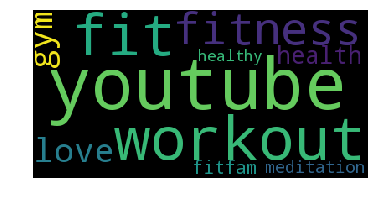

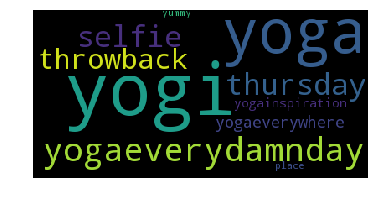

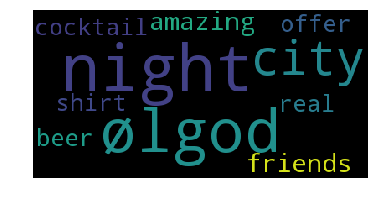

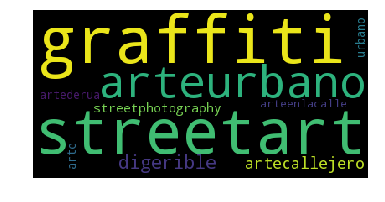

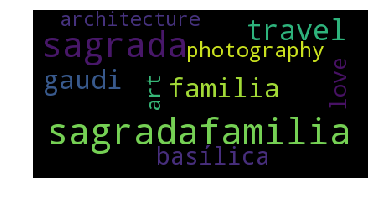

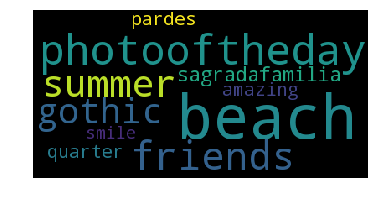

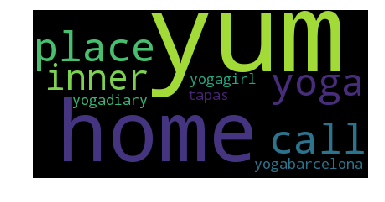

In [80]:
# display wordclouds for the topics
def terms_to_wordcounts(terms, multiplier=1000):
    return  " ".join([" ".join(int(multiplier*i[1]) * [i[0]]) for i in terms])

wordclouds = []
i = 0

for topic in topic_terms:
    wordcloud = WordCloud(background_color="black", collocations=False).generate(terms_to_wordcounts(topic))
    
    _ = plt.imshow(wordcloud)
    _ = plt.axis("off")
    _ = plt.savefig("terms_wordcloud_topic" + str(i))
    _ = plt.show()
    
    i += 1